# Схема проекта

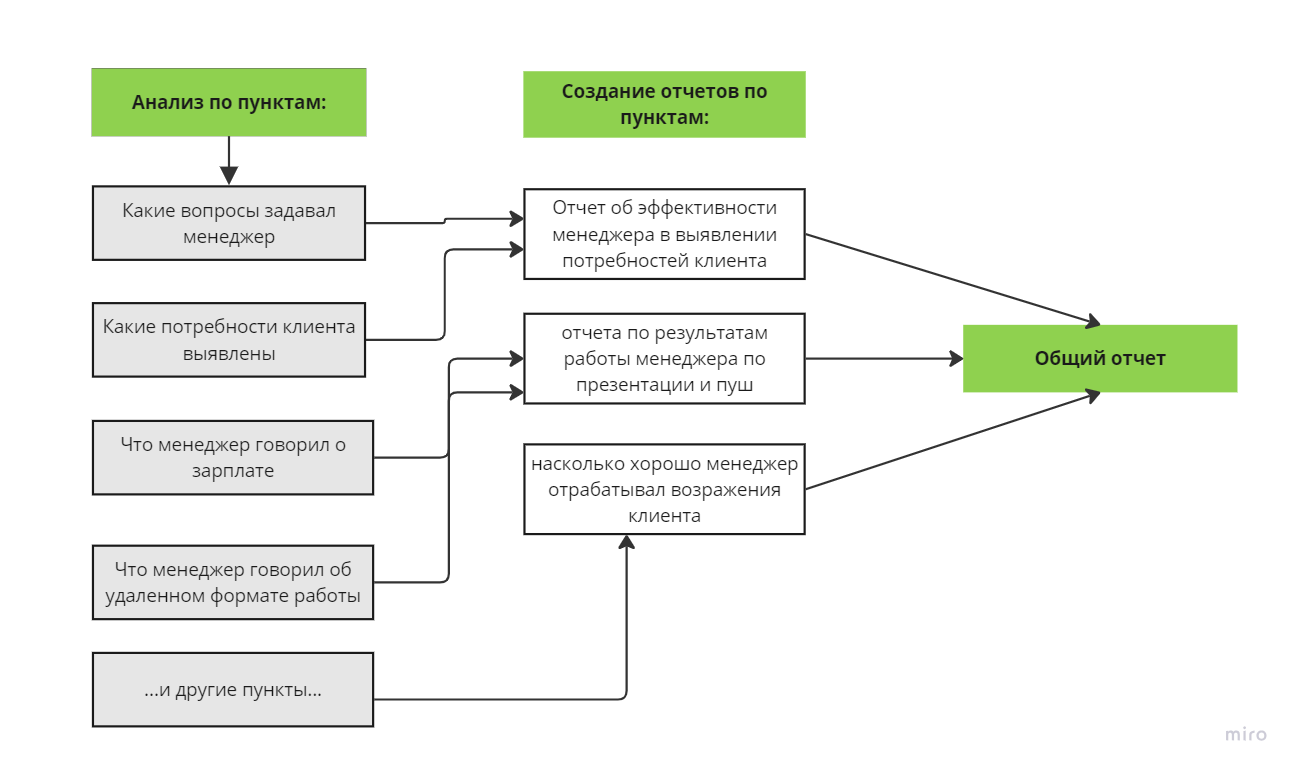

# Запускаем алгоритм

In [ ]:
#@title Установка библиотек
!pip install -q openai==1.61.1 faiss-cpu==1.10.0 langchain==0.3.20 langchain-core==0.3.41 langchain-openai==0.3.7 langchain_community==0.3.19 tiktoken==0.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
#@title Импорт модулей
import os
from google.colab import userdata
from langchain.text_splitter import NLTKTextSplitter
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import tiktoken
from IPython.display import HTML, display
from google.colab import output
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from pprint import pprint
import re
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
#@title Чтение ключа OPENAI_API_KEY
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
client = OpenAI()

In [ ]:
#@title Объявляем общие функции

# определение класса bcolors в Python, который используется для добавления цвета и стилей к тексту, выводимому в терминале.
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Функция load_document_text принимает один параметр file_path, который представляет собой путь к файлу.
# Она открывает файл в режиме чтения с указанием кодировки 'utf-8', читает его содержимое полностью в переменную text, а затем закрывает файл.
# Функция возвращает прочитанное содержимое файла в виде строки.
def load_document_text(file_path) -> str:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Функция create_search_index принимает три параметра: data, chunk_size и chunk_overlap.
# Параметр data представляет собой текстовые данные, которые необходимо индексировать.
# Параметр chunk_size задает размер фрагмента текста, на который необходимо разбить данные, а chunk_overlap - насколько фрагменты будут перекрываться.
# В функции данные сначала разделяются на части по разделителю '\n\n', предполагая разделение на блоки диалогов или абзацы.
# Для каждой части определяется, кто является говорящим (Менеджер или Клиент), и этот тег добавляется к каждому фрагменту текста в последующих операциях.
# Функция использует объект splitter (экземпляр NLTKTextSplitter), чтобы разбить каждую часть текста на фрагменты согласно заданным параметрам chunk_size и chunk_overlap.
# Далее, к каждому фрагменту текста добавляется соответствующий тег говорящего (если это не первый фрагмент в части), и создается объект Document с этим фрагментом текста.
# Все объекты Document собираются в список source_chunks.
# Наконец, используя FAISS и класс OpenAIEmbeddings для векторизации, функция создает и возвращает индекс для быстрого поиска по текстовым фрагментам, хранящимся в source_chunks.
def create_search_index(data, chunk_size, chunk_overlap):
    source_chunks = []
    splitter = NLTKTextSplitter(chunk_size=chunk_size)
    parts = data.split('\n\n')
    last_speaker = ""

    for part in parts:
        speaker_tag = " Менеджер: " if " Менеджер: " in part else " Клиент: "
        last_speaker = part[:len(speaker_tag)]

        for i, chunk in enumerate(splitter.split_text(part)):
            content = last_speaker + chunk if i > 0 else chunk
            source_chunks.append(Document(page_content=content))

    return FAISS.from_documents(source_chunks, OpenAIEmbeddings())

# Функция num_tokens_from_string определяет количество токенов в строке
#   string        - исходная строка
#   encoding_name - кодировка символов
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(string))

# Функция num_tokens_from_messages определяет количество токенов в промпте
#   message - набор инструкций system, user и т.д.
#   model   - модель GPT
def num_tokens_from_messages(messages, model='gpt-4o-mini'):
    encoding = tiktoken.get_encoding('cl100k_base')
    token_counts = {
        "gpt-4o-mini": (4, -1),
        "default": (3, 1)
    }
    tokens_per_message, tokens_per_name = token_counts.get(model, token_counts["default"])
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message + sum(len(encoding.encode(value)) for key, value in message.items())
        if "name" in message:
            num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with assistant
    return num_tokens

# Функция answer_user_question загружает текст базы знаний из указанного URL,
# создает индекс поиска для этого текста и затем вызывает функцию answer_index,
# чтобы сгенерировать ответ на основе документа системы и заданной темы
#   system_doc_text     - инструкция system
#   knowledge_base_url  - путь к текстовому файлу базы знаний
#   topic               - ключевые фразы, по ним выбираем наиболее релевантные отрезки из базы знаний
#   instruction         - инструкция для формирования роли user
#   temperature         - температура
#   verbose             - показывать найденные чанки (в данном проекте не используется, оставлена для совместимости с кодом)
#   k                   - количество релевантных чанков
#   chunk_size          - максимальный размер чанка для формаирования индексной базы
#   chunk_overlap       - перекрытие чанков при формировании индексной базы
#   model               - модель GPT
#   example             - пример ответа (необязательный)
#   format              - формат примера ответа 'json' или 'text;
def answer_user_question(system_doc_text, knowledge_base_url, topic, instructions, temperature, verbose, k, chunk_size, chunk_overlap, model, example = '', format = 'text'):
    knowledge_base_text = load_document_text(knowledge_base_url)
    knowledge_base_index = create_search_index(knowledge_base_text, chunk_size, chunk_overlap)
    return answer_index(system_doc_text, topic, instructions, knowledge_base_index, temperature, verbose, k, model, example, format)

# Функция answer_index выполняет поиск по индексу для получения k
# наиболее релевантных документов по заданной теме, формирует
# сообщения для модели и генерирует ответ с использованием OpenAI API
#   system              - инструкция system
#   topic               - ключевые фразы, по ним выбираем наиболее релевантные отрезки из базы знаний
#   instruction         - инструкция для формирования роли user
#   search_index        - индексная база
#   temp                - температура
#   verbose             - показывать найденные чанки (в данном проекте не используется, оставлена для совместимости с кодом)
#   k                   - количество релевантных чанков
#   model               - модель GPT
#   example             - пример ответа
#   format              - формат примера ответа 'json' или 'text'
def answer_index(system, topic, instructions, search_index, temp, verbose, k, model, example = '', format = 'text'):
    docs = search_index.similarity_search_with_score(topic, k=k)
    response_format = None
    message_content = '\n '.join([f'Отрывок текста №{i+1}\n{doc[0].page_content}' for i, doc in enumerate(docs)])
    messages = [{"role": "system", "content": system}]
    if example != '':
      messages.append({"role": "user", "content": 'Ответь на вопрос' + ' и верни ответ в формате JSON' if format == 'json' else ''})
      messages.append({"role": "assistant", "content": example})
      if format == 'json': response_format = {'type': 'json_object'}
    messages.append({"role": "user", "content": f"{instructions}\n\nТексты для анализа:\n{message_content}"})
    client = OpenAI()
    completion = client.chat.completions.create(model = model, messages = messages, temperature = temp, response_format = response_format)
    return completion.choices[0].message.content

# Функция answer_user_question_from_answer формирует сообщения для модели
# на основе документа системы, инструкций и результатов анализа,
# затем генерирует ответ с использованием OpenAI API
#   system              - инструкция system
#   instruction         - инструкция для формирования роли user
#   answer_content      - результаты предыдущего анализа
#   temp                - температура
#   verbose             - показывать найденные чанки (в данном проекте не используется, оставлена для совместимости с кодом)
#   model               - модель GPT
def answer_user_question_from_answer(system, instructions, answers_content, temp, verbose, model):
    messages = [{"role": "system", "content": system}, {"role": "user", "content": f"{instructions}\n\nРезультаты анализа:\n{answers_content}"}]
    client = OpenAI()
    completion = client.chat.completions.create(model=model, messages=messages, temperature=temp)
    return completion.choices[0].message.content

# Функция переноса теста в output ячейках, для улучшения отображения вывода
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Функция merge_text_files объединяет содержимое двух текстовых файлов,
# добавляя строки из второго файла в конец первого файла
# с обновленной временной отметкой
#   file1_path - путь к первому файлу
#   file2_path - путь ко второму файлу
def merge_text_files(file1_path, file2_path):

    # открываем оба файла
    with open(file1_path, 'r+') as file1, open(file2_path, 'r') as file2:

        # Читаем содержимое первого файла
        file1_lines = file1.readlines()

        # Удаляем пустую строку или символ переноса строки в конце файла, если они есть
        if file1_lines[-1].strip() == '':
            file1_lines.pop()

        # Получаем временную отметку последней строки первого файла
        last_timestamp = file1_lines[-1].split()[0]

        # Читаем содержимое второго файла
        file2_lines = file2.readlines()

        # Обрабатываем каждую строку второго файла
        for line in file2_lines:
            line = line.strip()
            if line == '':
                continue  # Пропускаем пустые строки во втором файле

            timestamp, dialogue = line.split(' ', 1)
            minutes, seconds = map(int, timestamp.split(':'))

            # Если количество секунд больше 59, переходим к следующей минуте
            if seconds > 59:
                minutes += seconds // 60
                seconds %= 60

            # Переводим временную отметку в минуты и секунды
            total_minutes = minutes + int(last_timestamp[:2])
            total_seconds = seconds + int(last_timestamp[3:])

            # Проверяем, если количество секунд превышает 59, добавляем минуту и обновляем секунды
            if total_seconds > 59:
                total_minutes += total_seconds // 60
                total_seconds %= 60

            # Вычисляем время в формате HH:MM
            new_timestamp = f"{total_minutes:02d}:{total_seconds:02d}"

            # Записываем строку с обновленной временной отметкой в первый файл
            file1.write(f"\n\n{new_timestamp} {dialogue}")

        # Добавляем символ переноса строки в конце файла 1, если он отсутствует
        if not file1_lines[-1].endswith('\n'):
            file1.write('\n')


##Диалог

https://disk.yandex.ru/d/IqOQeMnvd6YSKg  ссылка на диалоги менеджера и клиента.



Далее следует код, предназначенный для загрузки и объединения текстовых файлов с Яндекс Диска, содержащих транскрибированные диалоги из аудиозаписей Zoom: в каждой папке 3 текстовых файла: то, что говорил клиент, то, что говорил менеджер и совместный текст.

In [ ]:
#@title Введите ссылку на папку Audio Record в папке zoom презентации с Яндекс диска c текстовыми файлами диалога
folder_url_yadisk = "https://disk.yandex.ru/d/IqOQeMnvd6YSKg" #@param {type:"string"} # Ссылка на основную папку на Яндекс Диске
optional_folder_url_yadisk2 = "" #@param {type:"string"} # Ссылка на дополнительную папку (опционально)
full_url = f'https://getfile.dokpub.com/yandex/get/{folder_url_yadisk}' # Построение полной ссылки для загрузки

# Проверка наличия дополнительной ссылки и построение полной ссылки для неё
if len(optional_folder_url_yadisk2):
  full_url_opt = f'https://getfile.dokpub.com/yandex/get/{optional_folder_url_yadisk2}'

temp_dir = 'temp' # Название временной директории

# Функция для загрузки содержимого по URL
def download_from_url(full_url, temp_dir, opt=False):
  # Создание временной директории, если она не существует
  if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

  # Запись URL во временный файл
  with open("temp/tmp.txt", "w") as f:
      f.write(full_url)

  try:
    # Удаление существующих файлов и папок, если они существуют
    try:
      os.remove("temp.zip")
      if not opt:
        !rm -R '/content/Audio Record/'
      !rm -R '/content/temp/Audio Record/'
    except:
      pass

    # Загрузка и распаковка архива
    !wget -O temp.zip -i temp/tmp.txt
    if opt:
      !unzip '/content/temp.zip' -d '/content/temp/'
    else:
      !unzip '/content/temp.zip' -d '/content/'
    output.clear()
    print('Файлы успешно загружены!')
  except Exception as e:
    print("Ошибка: ", e)

# Загрузка файлов из основной и дополнительной папок
download_from_url(full_url, temp_dir, opt=False)
if len(optional_folder_url_yadisk2):
  download_from_url(full_url_opt, temp_dir, opt=True)

# Пути к текстовым файлам в загруженных папках
base_text_path = '/content/Audio Record'
if len(optional_folder_url_yadisk2):
  base_opt_text_path = '/content/temp/Audio Record'
  # Слияние текстовых файлов с одинаковыми именами
  for first_file in os.listdir(base_text_path):
    file1_path = os.path.join(base_text_path, first_file)
    for second_file in os.listdir(base_opt_text_path):
      file2_path = os.path.join(base_opt_text_path, second_file)
      # Слияние файлов по типам (диалог, клиент, менеджер)
      if '_dialogue' in first_file and '_dialog_' in second_file:
        merge_text_files(file1_path, file2_path)
      elif 'client_' in first_file and '_client_' in second_file:
        merge_text_files(file1_path, file2_path)
      elif 'manager_' in first_file and '_manager_' in second_file:
        merge_text_files(file1_path, file2_path)
  print("Текстовые файлы двух записей объеденены!")

# Определение путей к текстовым файлам и их категоризация
text_path = [os.path.join(base_text_path, file) for file in os.listdir(base_text_path) if file.endswith('.txt')]
base = ''   # Диалог
base1 = '' # Клиент
base2 = '' # Менеджер

# Проверка количества текстовых файлов и их распределение по категориям
if len(text_path) == 3:
  for i_text in text_path:
    if '_dialogue' in i_text:
      base = i_text       # в итоге тут будет храниться путь к текстовому файлу
      print(i_text)
    elif 'client_' in i_text:
      base1 = i_text
      print(i_text)
    elif 'manager_' in i_text:
      base2 = i_text
      print(i_text)
else:
  print('Внимание!!! Количество текстовых файлов не соответствуют количеству равному 3 для правильной их обработки.\nПриведите их в правильный вид.')


Файлы успешно загружены!
/content/Audio Record/client_recogn.txt
/content/Audio Record/merged_dialogue.txt
/content/Audio Record/manager_recogn.txt


In [ ]:
#@title Подсчет токенов и их соотношение в диалоге между клиентом и менджером
num_token_dialog = num_tokens_from_string(load_document_text(base), encoding_name="cl100k_base")
num_token_client = num_tokens_from_string(load_document_text(base1), encoding_name="cl100k_base")
num_token_manager = num_tokens_from_string(load_document_text(base2), encoding_name="cl100k_base")
print('Токенов в Диалог: ', num_token_dialog)
print('Токенов в Client +: ', num_token_client)
print('Токенов в Manager +: ', num_token_manager)
print("Соотношение токенов Клиент/Менеджер %: ", int((num_token_client*100)/num_token_dialog), '/', 100-int((num_token_client*100)/num_token_dialog))

Токенов в Диалог:  12107
Токенов в Client +:  3385
Токенов в Manager +:  8701
Соотношение токенов Клиент/Менеджер %:  27 / 73


**content** - *это выбор из какой базы будет использоваться текст для анализа*

**temperature** - *это значение чем меньше (ближе, либо равно нулю) чем точнее к контексту, чем ближе к 1 тем больше фантазии*

**num_fragment** - *это количество отрезков документа которые отбираются по ключевым фразам и передаются в модель для анализа (сейчас 5 так как при нынешней нарезке влезает в модель по количеству токенов в среднем около 3000, но может варьироваться)*

**system_prompt** - это роль модели и какие то глобальные установки

**instructions** - *это описание задачи что нужно сделать над отобранным контекстом по ключевым фразам*

**topicphrase** - *это ключевые слова для отбора отрывков текста в нужном смысле для анализа*

#B2B или B2C

In [ ]:
#@title 1. B2B или B2C
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Client +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 6 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0442\u0435 \u0442\u0435\u043A\u0441\u0442, \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u043C \u043A\u043B\u0438\u0435\u043D\u0442 \u043E\u0431\u0440\u0430\u0442\u0438\u043B\u0441\u044F \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\" \u0434\u043B\u044F \u043F\u043E\u043A\u0443\u043F\u043A\u0438 \u043A\u0443\u0440\u0441\u043E\u0432 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043F\u043E \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u043C\u0443 \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0443 \u0438 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E. \u0412\u0430\u0448\u0430 \u0437\u0430\u0434\u0430\u0447\u0430 \u0442\u043E\u0447\u043D\u043E \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u0438\u0442\u044C, \u044F\u0432\u043B\u044F\u0435\u0442\u0441\u044F \u043B\u0438 \u043A\u043B\u0438\u0435\u043D\u0442 b2b \u0438\u043B\u0438 b2c. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u0443\u0447\u0438\u0442\u044B\u0432\u0430\u0435\u0442\u0435 \u0447\u0442\u043E \"b2c\" - \u044D\u0442\u043E \u0447\u0435\u043B\u043E\u0432\u0435\u043A \u043A\u043E\u0442\u043E\u0440\u044B\u0439 \u0438\u0449\u0435\u0442 \u043A\u0443\u0440\u0441\u044B \u0434\u043B\u044F \u0441\u0435\u0431\u044F \u0447\u0442\u043E\u0431\u044B \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u044C \u043D\u043E\u0432\u0443\u044E \u0440\u0430\u0431\u043E\u0442\u0443/ \u0437\u0430\u0440\u0430\u0431\u043E\u0442\u0430\u0442\u044C \u0431\u043E\u043B\u044C\u0448\u0443\u044E \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0443/ \u0443\u043B\u0443\u0447\u0448\u0438\u0442\u044C \u0441\u0432\u043E\u0438 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438\u043B\u0438 \u0440\u0430\u0437\u0432\u0438\u0442\u044C\u0441\u044F \u0432 IT-\u0441\u0444\u0435\u0440\u0435/ \u043A\u043E\u0433\u0434\u0430 \u0447\u0435\u043B\u043E\u0432\u0435\u043A \u0433\u043E\u0432\u043E\u0440\u0438\u0442 \u043E \u043B\u0438\u0447\u043D\u043E\u043C \u0438\u043D\u0442\u0435\u0440\u0435\u0441\u0435 \u043A \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C/ \u043A\u043E\u0433\u0434\u0430 \u043E\u043D \u0445\u043E\u0447\u0435\u0442 \u0441\u043E\u0437\u0434\u0430\u0442\u044C \u043F\u0440\u043E\u0435\u043A\u0442 \u0434\u043B\u044F \u0441\u0435\u0431\u044F/\u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0438/\u0433\u0430\u0440\u0430\u043D\u0442\u0438\u044F \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0430/\u0441\u043C\u0435\u043D\u0430 \u0434\u0435\u044F\u0442\u0435\u043B\u044C\u043D\u043E\u0441\u0442\u0438/ \u043A\u043E\u0433\u0434\u0430 \u0432\u044B \u043F\u043E\u043D\u0438\u043C\u0430\u0435\u0442\u0435 \u0447\u0442\u043E \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440 \u0438\u0434\u0435\u0442 \u043E \u043B\u0438\u0447\u043D\u044B\u0445 \u0438\u043D\u0442\u0435\u0440\u0435\u0441\u0430\u0445 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u0443\u0447\u0438\u0442\u044B\u0432\u0430\u0435\u0442\u0435 \u0447\u0442\u043E \"b2b\" - \u044D\u0442\u043E \u043A\u043E\u0433\u0434\u0430 \u0435\u0441\u0442\u044C \u0444\u0440\u0430\u0437\u044B \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u0443\u043A\u0430\u0437\u044B\u0432\u0430\u044E\u0449\u0438\u043C \u043D\u0430 \u0442\u043E \u0447\u0442\u043E \u043A\u043B\u0438\u0435\u043D\u0442 \u044F\u0432\u043D\u043E \u0445\u043E\u0447\u0435\u0442 \u043E\u0431\u0443\u0447\u0438\u0442\u044C \u0441\u0432\u043E\u0438\u0445 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A\u043E\u0432 / \u0441\u043E\u0437\u0434\u0430\u0442\u044C \u043F\u0440\u043E\u0435\u043A\u0442 \u0434\u043B\u044F \u0441\u0432\u043E\u0435\u0439 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 / \u0441 \u0446\u0435\u043B\u044C\u044E \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u044F \u0443\u0441\u043B\u0443\u0433 / \u0443\u0432\u0435\u043B\u0438\u0447\u0435\u043D\u0438\u044F \u0434\u043E\u0445\u043E\u0434\u043E\u0432/ \u043A\u043E\u0433\u0434\u0430 \u043F\u0440\u0435\u0434\u043F\u0440\u0438\u043D\u0438\u043C\u0430\u0442\u0435\u043B\u044C \u0438\u043B\u0438 \u0440\u0443\u043A\u043E\u0432\u043E\u0434\u0438\u0442\u0435\u043B\u044C \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u043E\u0431\u0440\u0430\u0449\u0430\u0435\u0442\u0441\u044F \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E/  \u043A\u043E\u0433\u0434\u0430 \u0432\u044B \u0441\u043B\u044B\u0448\u0438\u0442\u0435 \u0447\u0442\u043E \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440 \u0438\u0434\u0435\u0442 \u043E \u0438\u043D\u0442\u0435\u0440\u0435\u0441\u0430\u0445 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438. \u0412\u044B \u0437\u043D\u0430\u0435\u0442\u0435 \u043D\u0430 100% \u0447\u0442\u043E \u0444\u0440\u0430\u0437\u044B \u043E \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u044F\u0445/ \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u043A\u0435/ \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u0438/\u0434\u0430\u0442\u0430\u0441\u0435\u0442\u043E\u0432/\u0430\u043D\u0430\u043B\u0438\u0442\u0438\u043A\u0430/\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044F/\u0438\u043D\u0441\u0442\u0443\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u043C \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0435/\u0430\u043B\u0433\u043E\u0440\u0438\u0442\u043C\u044B/ \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0435 \u043F\u0440\u043E\u0435\u043A\u0442\u043E\u0432 / \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0438\u0433\u0440 - \u041D\u0418\u041A\u041E\u0413\u0414\u0410 \u041D\u0415 \u041E\u041F\u0420\u0415\u0414\u0415\u041B\u042F\u0415\u0422  \u044F\u0432\u043B\u044F\u0435\u0442\u0441\u044F \u043B\u0438 \u044D\u0442\u043E\u0442 \u043A\u043B\u0438\u0435\u043D\u0442 b2b \u0438\u043B\u0438 b2c. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043F\u0438\u0448\u0435\u0442\u0435 \u043D\u0435 \u0440\u0430\u0432\u043D\u044B\u0435 \u043F\u0440\u043E\u0446\u0435\u043D\u0442\u044B \u0434\u043B\u0435\u043D\u0438\u044F \u043C\u0435\u0436\u0434\u0443 b2b \u0438 b2c. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u0441\u0442\u0440\u043E\u0433\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "Пожалуйста, давайте подумаем шаг за шагом. #01 Первый порядок отчета: проанализируйте пожалуйста все тексты, далее определите является ли клиент b2b или b2c согласно тому что вы знаете, и напишите только вывод: \"b2c: % вероятность, что это b2c\"+\"b2b: % вероятность, что это b2b\" +\"подробное описание до 200 символов, объясняющее, почему это b2b или b2c\". Затем с новой строки сделай свой вывод: \"Клиент: B2B\" или \"Клиент B2C\"" #@param {type:"string"}
topicphrase = '\u043F\u0440\u043E\u0435\u043A\u0442, \u0441\u0435\u0431\u044F, \u0440\u0430\u0437\u0432\u0438\u0432\u0430\u0442\u044C\u0441\u044F, \u0441\u043E\u0437\u0434\u0430\u0442\u044C, \u043E\u0431\u0443\u0447\u0438\u0442\u044C\u0441\u044F, \u043D\u0430\u0432\u043A\u0438, \u0437\u043D\u0430\u043D\u0438\u044F, \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E' #@param {type:"string"}


if content == 'Диалог':
  content_base = base
elif content == 'Client +':
  content_base = base1
elif content == 'Manager +':
  content_base = base2

out = {}
out['B2_1'] = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 1, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

# получаем тип клиента
match = re.search(r'Клиент:\s*(.*)', out['B2_1'])
if match:
  out['B2_2'] = match.group(1)
else:
  out['B2_2'] = 'Тип клиента не определен!'

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print("\nОтвет:\n", out['B2_1'])
print(f"\nТип клиента: {out['B2_2']}")

('system_prompt: Вы анализируете текст, в котором клиент обратился в компанию '
 '"университет искусственного интеллекта" для покупки курсов обучения по '
 'искусственному интеллекту и программированию. Ваша задача точно определить, '
 'является ли клиент b2b или b2c. Вы всегда учитываете что "b2c" - это человек '
 'который ищет курсы для себя чтобы получить новую работу/ заработать большую '
 'зарплату/ улучшить свои навыки или развиться в IT-сфере/ когда человек '
 'говорит о личном интересе к нейронным сетям/ когда он хочет создать проект '
 'для себя/стажировки/гарантия трудоустройства/смена деятельности/ когда вы '
 'понимаете что разговор идет о личных интересах клиента. Вы всегда учитываете '
 'что "b2b" - это когда есть фразы в тексте указывающим на то что клиент явно '
 'хочет обучить своих сотрудников / создать проект для своей компании / с '
 'целью развития услуг / увеличения доходов/ когда предприниматель или '
 'руководитель компании обращается в компанию/  когда вы слыши

#B2C

## Выявление





In [ ]:
#@title 1\. Вопросы менеджера
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-1106"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 936 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 15 #@param {type:"integer"}
system_prompt = " \u0412\u044B \u0443\u043C\u0435\u0435\u0442\u0435 \u0440\u0430\u0441\u043F\u043E\u0437\u043D\u0430\u0432\u0430\u0442\u044C \u0432\u043E\u043F\u0440\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0435 \u0444\u0440\u0430\u0437\u044B/\u0432\u043E\u043F\u0440\u043E\u0441\u044B \u0432 \u0442\u0440\u0430\u043D\u0441\u043A\u0440\u0438\u0431\u0438\u0440\u043E\u0432\u0430\u043D\u043D\u043E\u043C \u0438\u0437 \u0430\u0443\u0434\u0438\u043E - \u0442\u0435\u043A\u0441\u0442\u0435. \u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0441\u043E\u0441\u0440\u0435\u0434\u043E\u0442\u043E\u0447\u044C\u0442\u0435\u0441\u044C \u0432 \u043E\u0441\u043D\u043E\u0432\u043D\u043E\u043C \u043D\u0430 \u0432\u043E\u043F\u0440\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0445 \u043C\u0435\u0441\u0442\u043E\u0438\u043C\u0435\u043D\u0438\u044F\u0445 \u043F\u0440\u0438 \u0440\u0430\u0441\u043F\u043E\u0437\u043D\u0430\u0432\u0430\u043D\u0438\u0438 \u0432\u043E\u043F\u0440\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0445 \u0444\u0440\u0430\u0437." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439 \u043C\u044B\u0441\u043B\u0438\u0442\u044C \u043F\u043E\u0448\u0430\u0433\u043E\u0432\u043E. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0442\u0435\u043A\u0441\u0442 \u0438 \u043D\u0430\u0439\u0434\u0438 \u0432\u0441\u0435 \u0444\u0440\u0430\u0437\u044B, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u0441 \u0432\u0435\u0440\u043E\u044F\u0442\u043D\u043E\u0441\u0442\u044C\u044E \u0431\u043E\u043B\u0435\u0435 95% \u044F\u0432\u043B\u044F\u044E\u0442\u0441\u044F \u0432\u043E\u043F\u0440\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u043C\u0438. \u0414\u0430\u043B\u0435\u0435 \u043D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E, \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0432 \u043E\u0442\u0447\u0435\u0442\u0430\u0445: #01 \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0432\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438 \u043A\u0440\u0430\u0442\u043A\u043E \u0438\u0437 \u0446\u0438\u0442\u0430\u0442 \u044F\u0432\u043D\u044B\u0445 \u0432\u043E\u043F\u0440\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0445 \u0444\u0440\u0430\u0437 / \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 + \u0443\u043A\u0430\u0436\u0438 \u0432\u0440\u0435\u043C\u044F \u0432 \u0442\u0435\u043A\u0441\u0442\u0435, \u0433\u0434\u0435 \u0442\u044B \u043D\u0430\u0448\u0435\u043B \u0432\u043E\u043F\u0440\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u0443\u044E \u0444\u0440\u0430\u0437\u0443 / \u0432\u043E\u043F\u0440\u043E\u0441. #02 \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u0442\u0435\u0431\u0435 \u0437\u0430\u043F\u0440\u0435\u0449\u0435\u043D\u043E \u0432 \u0441\u043F\u0438\u0441\u043A\u0435 \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430 \u043F\u0438\u0441\u0430\u0442\u044C \u043E\u0434\u0438\u043D\u0430\u043A\u043E\u0432\u044B\u0435 \u0432\u043E\u043F\u0440\u043E\u0441\u044B." #@param {type:"string"}
topicphrase = '\u043A\u0430\u043A , \u0441\u043A\u043E\u043B\u044C\u043A\u043E, \u0432\u0435\u0440\u043D\u043E, \u0441\u043A\u0430\u0436\u0438\u0442\u0435, \u0445\u043E\u0442\u0438\u0442\u0435, \u0437\u043D\u0430\u0435\u0442\u0435, \u043A\u043E\u0433\u0434\u0430, \u043A\u0430\u043A\u043E\u0439, \u043A\u0430\u043A\u0430\u044F, \u0447\u0442\u043E, \u043F\u043E\u0447\u0435\u043C\u0443, \u0437\u0430\u0447\u0435\u043C, \u043A\u0443\u0434\u0430, \u043E\u0442\u043A\u0443\u0434\u0430, \u0447\u0435\u0439, \u043A\u0442\u043E,  \u0433\u0434\u0435, \u0447\u0435\u043C,  ?' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

out['выявление_1'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print("\nОтвет:\n", out['выявление_1'])

('system_prompt:  Вы умеете распознавать вопросительные фразы/вопросы в '
 'транскрибированном из аудио - тексте. Пожалуйста, сосредоточьтесь в основном '
 'на вопросительных местоимениях при распознавании вопросительных фраз.')

('instructions: Пожалуйста, давай мыслить пошагово. Проанализируй текст и '
 'найди все фразы, которые с вероятностью более 95% являются вопросительными. '
 'Далее напиши только то, что указано написать в отчетах: #01 Порядок первого '
 'ответа: напиши один список пунктами кратко из цитат явных вопросительных '
 'фраз / вопросов + укажи время в тексте, где ты нашел вопросительную фразу / '
 'вопрос. #02 Примечание: тебе запрещено в списке первого отчета писать '
 'одинаковые вопросы.')

('topicphrase: как , сколько, верно, скажите, хотите, знаете, когда, какой, '
 'какая, что, почему, зачем, куда, откуда, чей, кто,  где, чем,  ?')

Ответ:
 #01 Порядок первого ответа:
1. Скажите, пожалуйста, у нас сейчас есть демонстрация на выбор той темы, которая была бы инте

In [ ]:
#@title 1.1. Отчет по выявлению
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-1106"]
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u044B \u043D\u0430 100% \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0448\u044C\u0441\u044F \u0432 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u043C \u0437\u0430\u0434\u0430\u0432\u0430\u043D\u0438\u0438 \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u0434\u043B\u044F \u0432\u044B\u044F\u0432\u043B\u0435\u043D\u0438\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0420\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 - \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u043A\u043E\u0442\u043E\u0440\u044B\u0435 GPT \u043D\u0430\u0448\u0435\u043B \u0438 \u0432\u044B\u0434\u0435\u043B\u0438\u043B \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430. \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043D\u0430\u0439\u0442\u0438 \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0435 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E\u0437\u0432\u043E\u043B\u044F\u044E\u0442 \u043B\u0443\u0447\u0448\u0435 \u043F\u043E\u043D\u044F\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u0438 \u0432\u044B\u044F\u0432\u0438\u0442\u044C \u0435\u0433\u043E \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438. " #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0438 \u0441\u043E\u0441\u0442\u0430\u0432\u044C \u0441\u043F\u0438\u0441\u043E\u043A \u0442\u043E\u043B\u044C\u043A\u043E \u0438\u0437 \u0442\u0435\u0445 \u0444\u0440\u0430\u0437 \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u044F\u0432\u043B\u044F\u044E\u0442\u0441\u044F \u0432\u043E\u043F\u0440\u043E\u0441\u0430\u043C\u0438." #@param {type:"string"}
answer = out['выявление_1'] + '\n'

out['выявление_1_1'] = answer_user_question_from_answer(
  system_prompt, instructions, answer,
  temperature, 1, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'answer: {answer[:200]}...')
print("\nОтвет:\n", out['выявление_1_1'])

('system_prompt: Ты на 100% разбираешься в качественном задавании вопросов '
 'клиенту для выявления потребностей клиента. Результат анализа - вопросы '
 'которые GPT нашел и выделил в тексте общения клиента и менеджера. Твоя '
 'задача - найти вопросы в результате анализа которые позволяют лучше понять '
 'клиента и выявить его потребности. ')

('instructions: Пожалуйста давай подумаем шаг за шагом. Проанализируй '
 'результаты анализа и составь список только из тех фраз которые являются '
 'вопросами.')

('answer: #01 Порядок первого ответа:\n'
 '1. Скажите, пожалуйста, у нас сейчас есть демонстрация на выбор той темы, '
 'которая была бы интересна. (00:10)\n'
 '2. Остались ли возможно по нему какие-то вопросы уточняющие? (0...')

Ответ:
 Вот список вопросов, выделенных из результатов анализа:

1. Скажите, пожалуйста, у нас сейчас есть демонстрация на выбор той темы, которая была бы интересна?
2. Остались ли возможно по нему какие-то вопросы уточняющие?
3. Вы уже знаете как меня зову

In [ ]:
#@title 1.2. Отчет по выявлению
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u044B \u043D\u0430 100% \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0448\u044C\u0441\u044F \u0432 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u043C \u0437\u0430\u0434\u0430\u0432\u0430\u043D\u0438\u0438 \u0432\u043E\u043F\u0440\u043E\u0441\u0430\u0445 \u043F\u0440\u0438 \u043F\u0440\u043E\u0434\u0430\u0436\u0435 \u043A\u0443\u0440\u0441\u043E\u0432 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F. \u0420\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 - \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u043A\u043E\u0442\u043E\u0440\u044B\u0435 GPT \u043D\u0430\u0448\u0435\u043B \u0438 \u0432\u044B\u0434\u0435\u043B\u0438\u043B \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430. \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043D\u0430\u0439\u0442\u0438 \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0435 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E\u0437\u0432\u043E\u043B\u044F\u044E\u0442 \u043B\u0443\u0447\u0448\u0435 \u043F\u043E\u043D\u044F\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u0438 \u0432\u044B\u044F\u0432\u0438\u0442\u044C \u0435\u0433\u043E \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438.  \u0422\u044B \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u044F\u0435\u0448\u044C \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u043E \u0437\u0430\u0434\u0430\u043D\u043D\u044B\u0445 \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u043E\u0442 100% \u0434\u043E 0% \u043F\u043E \u0433\u0440\u0430\u0434\u0430\u0446\u0438\u0438: - 100% - \u0435\u0441\u043B\u0438 \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0435 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0438\u0437 \u043E\u0431\u0449\u0435\u0433\u043E \u0447\u0438\u0441\u043B\u0430 \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u0442\u044B \u043D\u0430\u0448\u0435\u043B \u0431\u043E\u043B\u0435\u0435 \u0432\u043E\u0441\u044C\u043C\u0438 \u0448\u0442\u0443\u043A \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E\u0437\u0432\u043E\u043B\u044F\u044E\u0442 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0435\u043D\u043D\u043E \u0432\u044B\u044F\u0432\u0438\u0442\u044C \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438 \u0436\u0435\u043B\u0430\u043D\u0438\u044F \u0438 \u0431\u043E\u043B\u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u0438 \u043B\u0443\u0447\u0448\u0435 \u0443\u0437\u043D\u0430\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0430,  - 0% - \u0435\u0441\u043B\u0438 \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0435 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0438\u0437 \u043E\u0431\u0449\u0435\u0433\u043E \u0447\u0438\u0441\u043B\u0430 \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u0442\u044B \u043D\u0430\u0448\u0435\u043B  \u043D\u043E\u043B\u044C \u0448\u0442\u0443\u043A \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E\u0437\u0432\u043E\u043B\u044F\u044E\u0442 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0435\u043D\u043D\u043E \u0432\u044B\u044F\u0432\u0438\u0442\u044C \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438 \u0436\u0435\u043B\u0430\u043D\u0438\u044F \u0438 \u0431\u043E\u043B\u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u0438 \u043B\u0443\u0447\u0448\u0435 \u0443\u0437\u043D\u0430\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041D\u0435 \u0432\u0430\u0436\u043D\u043E \u043A\u0430\u043A\u043E\u0435 \u043A\u043E\u043B\u0438\u0447\u0435\u0441\u0442\u0432\u043E \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0435 \u0430\u043D\u0430\u043B\u0438\u0437\u0430, \u0446\u0438\u0444\u0440\u0443 \u043E\u0446\u0435\u043D\u043A\u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043D\u0430\u0434\u043E \u043F\u0438\u0441\u0430\u0442\u044C \u0441\u0442\u0440\u043E\u0433\u043E \u043E\u0440\u0438\u0435\u043D\u0442\u0438\u0440\u0443\u044F\u0441\u044C \u043D\u0430 \u0433\u0440\u0430\u0434\u0430\u0446\u0438\u044E. \u0422\u044B \u0430\u0431\u0441\u043E\u043B\u044E\u0442\u043D\u043E \u0432\u0441\u0435\u0433\u0434\u0430 \u043D\u0430 100% \u0441\u043E\u0431\u043B\u044E\u0434\u0430\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043E\u043A \u043E\u0442\u0447\u0435\u0442\u043E\u0432!" #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \u043E\u0442\u0447\u0435\u0442\u043E\u0432: #01\u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \"quality\": \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u043D\u0430\u0439\u0434\u0435\u043D\u043D\u044B\u0445 \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u043E\u0442 0% \u0434\u043E 100% \u043D\u0430\u043F\u0438\u0441\u0430\u043D\u043D\u0430\u044F \u0441\u0442\u0440\u043E\u0433\u043E \u043F\u043E \u0433\u0440\u0430\u0434\u0430\u0446\u0438\u0438. #02 \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0438 \u043E\u0431\u0449\u0438\u043C\u0438 \u0441\u043B\u043E\u0432\u0430\u043C\u0438 \u043E\u043F\u0438\u0448\u0438 \u043E\u043F\u0438\u0448\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u043F\u043E \u043F\u0435\u0440\u0432\u043E\u043C\u0443 \u043E\u0442\u0447\u0435\u0442\u0443. #03 \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0442\u0440\u0435\u0442\u044C\u0435\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \"count\": \u043D\u0430\u043F\u0438\u0448\u0438 \u043A\u043E\u043B\u0438\u0447\u0435\u0441\u0442\u0432\u043E \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u0435\u0445 \u0432\u043E\u043F\u0440\u043E\u0441\u043E\u0432 \u0432 \u0441\u043F\u0438\u0441\u043A\u0435 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E\u043C\u043E\u0433\u0430\u044E\u0442 \u0432\u044B\u044F\u0432\u0438\u0442\u044C \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0431\u043E\u043B\u0438 \u0438 \u0436\u0435\u043B\u0430\u043D\u0438\u044F \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041F\u0435\u0440\u0432\u044B\u0439, \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043E\u0442\u0434\u0435\u043B\u0438 \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430." #@param {type:"string"}
answer = out['выявление_1_1'] + '\n'
out['выявление_1_2'] = answer_user_question_from_answer(
    system_prompt, instructions, answer, temperature, 1, model
)
pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'answer: {answer}'[:300])
print("\nОтвет:\n", out['выявление_1_2'])

('system_prompt: Ты на 100% разбираешься в качественном задавании вопросах при '
 'продаже курсов обучения. Результат анализа - вопросы которые GPT нашел и '
 'выделил в тексте общения клиента и менеджера. Твоя задача - найти вопросы в '
 'результате анализа которые позволяют лучше понять клиента и выявить его '
 'потребности.  Ты определяешь качество заданных вопросов от 100% до 0% по '
 'градации: - 100% - если в результате анализа из общего числа вопросов ты '
 'нашел более восьми штук вопросов которые позволяют качественно выявить '
 'потребности желания и боли клиента и лучше узнать клиента,  - 0% - если в '
 'результате анализа из общего числа вопросов ты нашел  ноль штук вопросов '
 'которые позволяют качественно выявить потребности желания и боли клиента и '
 'лучше узнать клиента. Не важно какое количество вопросов в результате '
 'анализа, цифру оценки качества надо писать строго ориентируясь на градацию. '
 'Ты абсолютно всегда на 100% соблюдаешь порядок отчетов!')

('instru

In [ ]:
#@title 2\. Потребности. Выявление конкретных указанных нами потребностей.
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Client +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 992 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 10 #@param {type:"integer"}
system_prompt = " Вы превосходно разбираетесь в общении между менеджером по продажам и клиентом. Менеджер по продажам работает в компании, которая продает обучение программированию на Python и искусственному интеллекту для нейронных сетей. Перед вами текст, содержащий только ответы и заявления клиента. Ваша основная задача - определить потребности клиента из предложенного списка. Вы всегда очень точно следуете порядку отчета. Ты не исползуешь MarkDown." #@param {type:"string"}
instructions = "\u0414\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C, \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439\u0442\u0435 \u0432\u0435\u0441\u044C \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u043D\u0430\u043B\u0438\u0447\u0438\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439 \u0438 \u043D\u0430\u043F\u0438\u0448\u0438\u0442\u0435 \u0442\u043E\u043B\u044C\u043A\u043E 1 \u043E\u0442\u0447\u0435\u0442 \u043F\u043E \u0432\u0441\u0435\u043C \u043F\u0430\u0440\u0430\u043C\u0435\u0442\u0440\u0430\u043C:  \u0422\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0435 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0422\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u0412\u044B\u0441\u043E\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0432\u044B\u0441\u043E\u043A\u043E\u0439 \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0435 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0412\u044B\u0441\u043E\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u0423\u0434\u0430\u043B\u0435\u043D\u043D\u0430\u044F \u0440\u0430\u0431\u043E\u0442\u0430: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u043E\u0439 \u0440\u0430\u0431\u043E\u0442\u0435 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0423\u0434\u0430\u043B\u0435\u043D\u043D\u0430\u044F \u0440\u0430\u0431\u043E\u0442\u0430: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u041B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u043E\u0435 \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u043B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u043E\u043C \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0438 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u041B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u043E\u0435 \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u0420\u0430\u0437\u0432\u0438\u0442\u0438\u0435 \u0432 \u0441\u0444\u0435\u0440\u0435 \u0418\u0422: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0438 \u0432 \u0441\u0444\u0435\u0440\u0435 \u0418\u0422 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0420\u0430\u0437\u0432\u0438\u0442\u0438\u0435 \u0432 \u0441\u0444\u0435\u0440\u0435 \u0418\u0422: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u0421\u043C\u0435\u043D\u0430 \u0434\u0435\u044F\u0442\u0435\u043B\u044C\u043D\u043E\u0441\u0442\u0438: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0441\u043C\u0435\u043D\u0435 \u0434\u0435\u044F\u0442\u0435\u043B\u044C\u043D\u043E\u0441\u0442\u0438 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0421\u043C\u0435\u043D\u0430 \u0434\u0435\u044F\u0442\u0435\u043B\u044C\u043D\u043E\u0441\u0442\u0438: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u041A\u0430\u0440\u044C\u0435\u0440\u043D\u044B\u0439 \u0440\u043E\u0441\u0442: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u043A\u0430\u0440\u044C\u0435\u0440\u043D\u043E\u043C \u0440\u043E\u0441\u0442\u0435 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u041A\u0430\u0440\u044C\u0435\u0440\u043D\u044B\u0439 \u0440\u043E\u0441\u0442: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u0421\u043E\u0437\u0434\u0430\u043D\u0438\u0435 \u043F\u0440\u043E\u0435\u043A\u0442\u0430: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0438 \u043F\u0440\u043E\u0435\u043A\u0442\u0430 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0421\u043E\u0437\u0434\u0430\u043D\u0438\u0435 \u043F\u0440\u043E\u0435\u043A\u0442\u0430: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u0423\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u0435 \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \u0442\u0435\u043A\u0443\u0449\u0435\u0439 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0443\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u0438 \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \u0442\u0435\u043A\u0443\u0449\u0435\u0439 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0423\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u0435 \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \u0442\u0435\u043A\u0443\u0449\u0435\u0439 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u041F\u0440\u0438\u0431\u044B\u043B\u044C \u043E\u0442 \u043F\u0440\u043E\u0435\u043A\u0442\u0430: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u043F\u043E\u043B\u0443\u0447\u0435\u043D\u0438\u0438 \u043F\u0440\u0438\u0431\u044B\u043B\u0438 \u043E\u0442 \u043F\u0440\u043E\u0435\u043A\u0442\u0430 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u041F\u0440\u0438\u0431\u044B\u043B\u044C \u043E\u0442 \u043F\u0440\u043E\u0435\u043A\u0442\u0430: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  \u0424\u0440\u0438\u043B\u0430\u043D\u0441: \u0423\u043A\u0430\u0436\u0438\u0442\u0435, \u0435\u0441\u0442\u044C \u043B\u0438 \u0432\u043E \u0432\u0441\u0435\u0445 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C \u0432 \u0444\u0440\u0438\u043B\u0430\u043D\u0441\u0435 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \"\u0424\u0440\u0438\u043B\u0430\u043D\u0441: \"\u0434\u0430/\u043D\u0435\u0442\" + \u0446\u0438\u0442\u0430\u0442\u044B, \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445." #@param {type:"string"}
topicphrase = '\u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E, \u0432\u044B\u0441\u043E\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0444\u043E\u0440\u043C\u0430\u0442 \u0440\u0430\u0431\u043E\u0442\u044B, \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435, \u0441\u043C\u0435\u043D\u0430 \u0434\u0435\u044F\u0442\u0435\u043B\u044C\u043D\u043E\u0441\u0442\u0438, \u0440\u043E\u0441\u0442 \u043A\u0430\u0440\u044C\u0435\u0440\u044B, \u043F\u0440\u043E\u0435\u043A\u0442, \u0440\u0430\u0431\u043E\u0442\u0430 \u0432 \u0442\u0435\u043A\u0443\u0449\u0435\u0439 \u043A\u0430\u043C\u043F\u0430\u043D\u0438\u0438, \u0444\u0440\u0438\u043B\u0430\u043D\u0441' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

# бывшее 'выявление_1_3'
out['выявление_2'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print("\nОтвет:\n", out['выявление_2'])

('system_prompt:  Вы превосходно разбираетесь в общении между менеджером по '
 'продажам и клиентом. Менеджер по продажам работает в компании, которая '
 'продает обучение программированию на Python и искусственному интеллекту для '
 'нейронных сетей. Перед вами текст, содержащий только ответы и заявления '
 'клиента. Ваша основная задача - определить потребности клиента из '
 'предложенного списка. Вы всегда очень точно следуете порядку отчета. Ты не '
 'исползуешь MarkDown.')

('instructions: Давайте подумаем шаг за шагом, пожалуйста. Проанализируйте '
 'весь текст на предмет наличия потребностей и напишите только 1 отчет по всем '
 'параметрам:  Трудоустройство: Укажите, есть ли во всех текстах потребность в '
 'трудоустройстве в формате: "Трудоустройство: "да/нет" + цитаты, упомянутые в '
 'текстах.  Высокая зарплата: Укажите, есть ли во всех текстах потребность в '
 'высокой зарплате в формате: "Высокая зарплата: "да/нет" + цитаты, упомянутые '
 'в текстах.  Удаленная работа: Укаж

In [ ]:
#@title 2.1. Отчет итого
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u0412\u044B\u0434\u0435\u043B\u0438\u0442\u0435 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u0435 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438 \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0431\u044B\u043B\u0438 \u043D\u0430\u0439\u0434\u0435\u043D\u044B \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0438 \u0438 \u043A\u043E\u0442\u043E\u0440\u044B\u043C \u0435\u0441\u0442\u044C \u0446\u0438\u0442\u0430\u0442\u044B (\u0442\u0430\u043C, \u0433\u0434\u0435 \u0435\u0441\u0442\u044C \u043E\u0442\u043C\u0435\u0442\u043A\u0430 \"\u0434\u0430\" , \u043D\u0430\u043F\u0440\u0438\u043C\u0435\u0440, \"01 \u0422\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E: \"\u0434\u0430\"\"). \u041F\u0435\u0440\u0435\u0432\u0435\u0434\u0438\u0442\u0435 \u043D\u0430\u0437\u0432\u0430\u043D\u0438\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439 \u043D\u0430 \u0440\u0443\u0441\u0441\u043A\u0438\u0439 \u044F\u0437\u044B\u043A.  \u041D\u0430\u043F\u0438\u0448\u0438\u0442\u0435 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0442\u043E\u043B\u044C\u043A\u043E \u0441\u043F\u0438\u0441\u043E\u043A \u043D\u0430\u0439\u0434\u0435\u043D\u043D\u044B\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439. " #@param {type:"string"}
answer = f'{out["выявление_2"]}\n'

out['выявление_2_1'] = answer_user_question_from_answer(
  system_prompt, instructions, answer,
  temperature, 1, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'answer: {answer}'[:300])
print("\nОтвет:\n", out['выявление_2_1'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Менеджер по продажам работает в компании которая продает '
 'обучение программированию на python и нейронным сетям. Вы всегда очень точно '
 'следуете порядку отчета.')

('instructions: Выделите только те потребности которые по результатам анализа '
 'были найдены в текстах и и которым есть цитаты (там, где есть отметка "да" , '
 'например, "01 Трудоустройство: "да""). Переведите названия потребностей на '
 'русский язык.  Напишите пожалуйста только список найденных потребностей. ')

('answer: Трудоустройство: да + "подкупает ваша гарантия трудоустройства. Это '
 'важно чувствовать, что хотя бы первый этап или старт тебе дадут."\n'
 '\n'
 'Высокая зарплата: да + "Двести тысяч. Если я сменю сферу деятельности, то, в '
 'целом, я понимаю, что в новом направлении у меня не будет сразу такого '
 'дохода да')

Ответ:
 1. Трудоустройство
2. Высокая зарплата
3. Удаленная работа
4. Личностное раз

In [ ]:
#@title 2.2. Потребности. Выявление потребностей без конкретизации.
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Client +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 232 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 10 #@param {type:"integer"}
system_prompt = "\u0423 \u0432\u0430\u0441 \u0441\u0430\u043C\u043E\u0435 \u043B\u0443\u0447\u0448\u0435\u0435 \u043F\u043E\u043D\u0438\u043C\u0430\u043D\u0438\u0435 \u0442\u043E\u0433\u043E, \u043A\u0430\u043A \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043E\u0431\u0449\u0435\u043D\u0438\u0435 \u043C\u0435\u0436\u0434\u0443 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u043E\u043C \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u043E\u043C. \u0412\u044B \u0432\u0438\u0434\u0438\u0442\u0435 \u0442\u0435\u043A\u0441\u0442 \u043C\u043E\u043D\u043E\u043B\u043E\u0433\u0430 \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u043A\u043E\u0442\u043E\u0440\u044B\u0439 \u0438\u0437\u0432\u043B\u0435\u0447\u0435\u043D \u0438\u0437 \u043E\u0431\u0449\u0435\u0433\u043E \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u043C\u0435\u0436\u0434\u0443 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u043E\u043C \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u043E\u043C. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u0432 \u043E\u0442\u0447\u0435\u0442\u0435." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043C\u044B\u0441\u043B\u0438\u0442\u044C \u043F\u043E\u0441\u043B\u0435\u0434\u043E\u0432\u0430\u0442\u0435\u043B\u044C\u043D\u043E. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439\u0442\u0435 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u043D\u0430\u043B\u0438\u0447\u0438\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439. \u211601 \u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u043D\u0430\u043F\u0438\u0448\u0438\u0442\u0435 \u043F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442 \u0432 \u0441\u0442\u0440\u043E\u0433\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435: \u0441\u043F\u0438\u0441\u043E\u043A, \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0442\u043E\u043B\u044C\u043A\u043E \u0438\u0437 \u043A\u0440\u0430\u0442\u043A\u0438\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u043E\u0447\u0435\u043D\u044C \u044F\u0432\u043D\u044B\u0445 \u043E\u0441\u043D\u043E\u0432\u043D\u044B\u0445 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0420\u044F\u0434\u043E\u043C \u0441 \u043A\u0430\u0436\u0434\u043E\u0439 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C\u044E \u0432 \u0441\u043F\u0438\u0441\u043A\u0435, \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0443\u043A\u0430\u0436\u0438\u0442\u0435 \u0432\u0440\u0435\u043C\u044F, \u043A\u043E\u0433\u0434\u0430 \u043E\u043D\u0430 \u0431\u044B\u043B\u0430 \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u0430. \u041D\u0430\u043F\u0440\u0438\u043C\u0435\u0440: (21:34). \u211602 \u0417\u0430\u043F\u0440\u0435\u0449\u0430\u0435\u0442\u0441\u044F \u0432\u043A\u043B\u044E\u0447\u0430\u0442\u044C \u0432 \u043F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442 \u0447\u0442\u043E-\u043B\u0438\u0431\u043E, \u0447\u0442\u043E \u043D\u0435 \u044F\u0432\u043B\u044F\u0435\u0442\u0441\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C\u044E. \u211603 \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044C - \u044D\u0442\u043E \u0442\u043E, \u0447\u0442\u043E \u043A\u043B\u0438\u0435\u043D\u0442 \u0445\u043E\u0447\u0435\u0442 \u0438\u043B\u0438 \u0447\u0442\u043E \u0435\u043C\u0443 \u043D\u0440\u0430\u0432\u0438\u0442\u0441\u044F, \u0438 \u044D\u0442\u043E \u043F\u043E\u0432\u043B\u0438\u044F\u0435\u0442 \u043D\u0430 \u043F\u043E\u043A\u0443\u043F\u043A\u0443 \u043A\u0443\u0440\u0441\u043E\u0432 \u043F\u043E \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u043C\u0443 \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0443. \u041F\u043E\u0434 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u044F\u043C\u0438 \u043F\u043E\u043D\u0438\u043C\u0430\u044E\u0442\u0441\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043C\u043E\u0433\u0443\u0442 \u0431\u044B\u0442\u044C \u0443\u0434\u043E\u0432\u043B\u0435\u0442\u0432\u043E\u0440\u0435\u043D\u044B \u043F\u0443\u0442\u0435\u043C \u043F\u043E\u043A\u0443\u043F\u043A\u0438 \u043A\u0443\u0440\u0441\u043E\u0432 \u043F\u043E \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u043C\u0443 \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0443. \u211604 \u0417\u0430\u043F\u0440\u0435\u0449\u0430\u0435\u0442\u0441\u044F \u0432\u043A\u043B\u044E\u0447\u0430\u0442\u044C \u0432 \u043F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442 \u043F\u043E\u0432\u0442\u043E\u0440\u0435\u043D\u0438\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439. " #@param {type:"string"}
topicphrase = '\u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E, \u0432\u044B\u0441\u043E\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0444\u043E\u0440\u043C\u0430\u0442 \u0440\u0430\u0431\u043E\u0442\u044B, \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435, \u0441\u043C\u0435\u043D\u0430 \u0434\u0435\u044F\u0442\u0435\u043B\u044C\u043D\u043E\u0441\u0442\u0438, \u0440\u043E\u0441\u0442 \u043A\u0430\u0440\u044C\u0435\u0440\u044B, \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0435 \u043F\u0440\u043E\u0435\u043A\u0442\u0430, \u0440\u0430\u0431\u043E\u0442\u0430 \u0432 \u0442\u0435\u043A\u0443\u0449\u0435\u0439 \u043A\u0430\u043C\u043F\u0430\u043D\u0438\u0438' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

# бывшее 'выявление_1_5'
out['выявление_2_2'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print("\nОтвет:\n", out['выявление_2_2'])

('system_prompt: У вас самое лучшее понимание того, как анализировать общение '
 'между менеджером по продажам и клиентом. Вы видите текст монолога клиента, '
 'который извлечен из общего диалога между менеджером по продажам и клиентом. '
 'Вы всегда точно следуете порядку в отчете.')

('instructions: Пожалуйста, давайте мыслить последовательно. Проанализируйте '
 'текст на предмет наличия потребностей. №01 Пожалуйста, напишите первый отчет '
 'в строгом порядке: список, состоящий только из кратких описаний очень явных '
 'основных потребностей клиента. Рядом с каждой потребностью в списке, '
 'пожалуйста, укажите время, когда она была упомянута. Например: (21:34). №02 '
 'Запрещается включать в первый отчет что-либо, что не является потребностью. '
 '№03 Примечание: потребность - это то, что клиент хочет или что ему нравится, '
 'и это повлияет на покупку курсов по искусственному интеллекту. Под '
 'потребностями понимаются потребности клиента, которые могут быть '
 'удовлетворены пут

## Закрытие потребностей

In [ ]:
#@title 1\. Трудоустройство. Анализ, что в диалоге говорилось о трудоустройстве
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 608 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = " Вы - лучший в анализе общения менеджера по продажам и клиента. Клиент должен быть осведомлен о возможностях трудоустройства после завершения курсов. Вы всегда точно следуете порядку, указанному в отчете." #@param {type:"string"}
instructions = "\u0414\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u043F\u0438\u0448\u0438\u0442\u0435 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E, \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u0432 \u043E\u0442\u0447\u0451\u0442\u0430\u0445! \u211601 \u041F\u0435\u0440\u0432\u043E\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u0435 \u043E\u0442\u0447\u0451\u0442\u0430: \u0441\u043E\u0441\u0442\u0430\u0432\u044C\u0442\u0435 \u0441\u043F\u0438\u0441\u043E\u043A, \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043E \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0435, \u0438\u0441\u043F\u043E\u043B\u044C\u0437\u0443\u044F \u043C\u0430\u0440\u043A\u0438\u0440\u043E\u0432\u0430\u043D\u043D\u044B\u0435 \u0441\u043F\u0438\u0441\u043A\u0438. \u0414\u0435\u043B\u0430\u0439\u0442\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u043A\u0440\u0430\u0442\u043A\u0438\u043C\u0438. \u211602 \u0412\u0442\u043E\u0440\u043E\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u0435 \u043E\u0442\u0447\u0451\u0442\u0430: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0430 \u0438\u043B\u0438 nan (\u0428\u043A\u0430\u043B\u0430: 100% - \u044F\u0441\u043D\u043E\u0435 \u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0430, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u0438 \u043D\u0435\u044F\u0441\u043D\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \"nan\" - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0430 \u043D\u0435 \u043F\u0440\u0435\u0434\u043E\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043E). \u211603 \u0422\u0440\u0435\u0442\u044C\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u0435 \u043E\u0442\u0447\u0451\u0442\u0430: \u043E\u0431\u044A\u044F\u0441\u043D\u0438\u0442\u0435, \u043F\u043E\u0447\u0435\u043C\u0443 \u0432\u044B \u0434\u0430\u043B\u0438 \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0451\u0442\u0435. \u211604 \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u0435\u0440\u0432\u044B\u0439, \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0451\u0442\u044B \u0434\u043E\u043B\u0436\u043D\u044B \u0431\u044B\u0442\u044C \u043D\u0430\u043F\u0438\u0441\u0430\u043D\u044B \u043E\u0442\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430. " #@param {type:"string"}
topicphrase = '\u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E, \u0440\u0430\u0431\u043E\u0442\u0430, \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u0443\u0441\u0442\u0440\u043E\u0438\u0442\u044C\u0441\u044F, \u0440\u0435\u0437\u044E\u043C\u0435, \u0432\u0430\u043A\u0430\u043D\u0441\u0438\u044F' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase, instructions, temperature, 0,
  num_fragment, chunk_size, chunk_overlap, model,
  answer_example, answer_format
)
out['закрытие_1'] = json.loads(result)
out['закрытие_1_total'] = ' '.join(out['закрытие_1']['reports'][0]['text_report'])

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_1_total'])

('system_prompt:  Вы - лучший в анализе общения менеджера по продажам и '
 'клиента. Клиент должен быть осведомлен о возможностях трудоустройства после '
 'завершения курсов. Вы всегда точно следуете порядку, указанному в отчете.')

('instructions: Давайте подумаем шаг за шагом. Пожалуйста, пишите только то, '
 'что указано в отчётах! №01 Первое задание отчёта: составьте список, '
 'состоящий из явных описаний в текстах о трудоустройстве, используя '
 'маркированные списки. Делайте описания краткими. №02 Второе задание отчёта: '
 '"quality": только одна общая оценка качества описания трудоустройства или '
 'nan (Шкала: 100% - ясное и качественное описание трудоустройства, 0% - '
 'плохое и неясное описание, "nan" - описание трудоустройства не '
 'предоставлено). №03 Третье задание отчёта: объясните, почему вы дали такую '
 'оценку во втором отчёте. №04 Примечание: первый, второй и третий отчёты '
 'должны быть написаны отдельно друг от друга. ')

'topicphrase: трудоустройство, работа, 

In [ ]:
#@title 2\. Зарплата. Что менеджер говорил о ЗП
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 500 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 10 #@param {type:"integer"}
system_prompt = "Вы лучше всех разбираетесь в анализе общения менеджера по продажам и клиента. Менеджеру нужно рассказать о возможностях заработной платы, зарплаты которую можно получить при трудоустройстве после прохождения курсов. Вы всегда очень точно следуете порядку отчета." #@param {type:"string"}
instructions = "Пожалуйста, давайте подумаем шаг за шагом. Пожалуйста проанализируйте текст на предмет наличия явных фраз о заработной плате. Отчет №01 Порядок первого отчета: Напиши один список пунктами, состоящий из явных фраз в текстах только о заработной плате. Описания напиши кратко. Отчет №02 Порядок второго отчета: напиши \"quality\": только одна общая оценка качества описания заработной платы по всему списку или nan (Градация: 100% -  описания о заработной плате понятные и качественные,  0% - плохое и не понятное описание заработной платы, \"nan\"- не было описания зарплаты).. Отчет №03 Порядок третьего отчета: напиши пожалуйста почему ты поставил такую оценку во втором отчете. # Примечание: первый второй и третий отчеты надо написать раздельно друг от друга." #@param {type:"string"}
topicphrase = '\u0432\u044B\u0441\u043E\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u043E\u043F\u0430\u0442\u0430 \u0442\u0440\u0443\u0434\u0430 , \u0440\u0430\u0431\u043E\u0442\u0430, \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u0434\u043E\u0445\u043E\u0434, \u0434\u0435\u043D\u044C\u0433\u0438, \u0440\u0443\u0431\u043B\u0435\u0439, \u0442\u044B\u0441\u044F\u0447' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_2'] = json.loads(result)
out['закрытие_2_total'] = ' '.join(out['закрытие_2']['reports'][0]['text_report'])

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_2_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Менеджеру нужно рассказать о возможностях заработной '
 'платы, зарплаты которую можно получить при трудоустройстве после прохождения '
 'курсов. Вы всегда очень точно следуете порядку отчета.')

('instructions: Пожалуйста, давайте подумаем шаг за шагом. Пожалуйста '
 'проанализируйте текст на предмет наличия явных фраз о заработной плате. '
 'Отчет №01 Порядок первого отчета: Напиши один список пунктами, состоящий из '
 'явных фраз в текстах только о заработной плате. Описания напиши кратко. '
 'Отчет №02 Порядок второго отчета: напиши "quality": только одна общая оценка '
 'качества описания заработной платы по всему списку или nan (Градация: 100% '
 '-  описания о заработной плате понятные и качественные,  0% - плохое и не '
 'понятное описание заработной платы, "nan"- не было описания зарплаты).. '
 'Отчет №03 Порядок третьего отчета: напиши пожалуйста почему ты поставил '
 'такую оце

In [ ]:
#@title 3\. Удаленка. Что менеджер говорил про удаленный формат
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 544 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 7 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0443 \u043D\u0443\u0436\u043D\u043E \u0440\u0430\u0441\u0441\u043A\u0430\u0437\u0430\u0442\u044C \u043E\u0431 \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u043E\u043C \u0433\u0440\u0430\u0444\u0438\u043A\u0435 \u0440\u0430\u0431\u043E\u0442\u044B. \u0412\u0430\u0448\u0430 \u0446\u0435\u043B\u044C - \u043D\u0430\u0439\u0442\u0438 \u0444\u0440\u0430\u0437\u044B \u0441\u043E \u0441\u043B\u043E\u0432\u0430\u043C\u0438 \u043E\u0431 \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u043E\u043C \u0433\u0440\u0430\u0444\u0438\u043A\u0435 \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445. \u0412\u044B \u0437\u043D\u0430\u0435\u0442\u0435, \u0447\u0442\u043E \u0442\u043E\u043B\u044C\u043A\u043E \u044D\u0442\u043E \u044F\u0432\u043D\u044B\u0435 \u0438 \u0442\u043E\u0447\u043D\u044B\u0435 \u0444\u0440\u0430\u0437\u044B \u043F\u0440\u043E \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0433\u0440\u0430\u0444\u0438\u043A: \"\u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0433\u0440\u0430\u0444\u0438\u043A\", \"\u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0444\u043E\u0440\u043C\u0430\u0442 \u0440\u0430\u0431\u043E\u0442\u044B\", \"\u0440\u0430\u0431\u043E\u0442\u0430 \u0438\u0437 \u0434\u043E\u043C\u0430\", \"\u0440\u0430\u0431\u043E\u0442\u0430 \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u0430\u044F\", \"\u0443\u0434\u0430\u043B\u0435\u043D\u043A\u0430\". \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430%." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439\u0442\u0435 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u043D\u0430\u043B\u0438\u0447\u0438\u044F \u0444\u0440\u0430\u0437 \u043F\u0440\u043E \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0433\u0440\u0430\u0444\u0438\u043A \u0440\u0430\u0431\u043E\u0442\u044B \u0438 \u0441\u0434\u0435\u043B\u0430\u0439 \u043E\u0431 \u044D\u0442\u043E\u043C 3 \u043E\u0442\u0447\u0435\u0442\u0430:  #\u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u043E \u043F\u0443\u043D\u043A\u0442\u0430\u043C, \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043E\u0431 \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u043E\u043C \u0433\u0440\u0430\u0444\u0438\u043A\u0435 \u0440\u0430\u0431\u043E\u0442\u044B \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u0442\u044B \u043D\u0430\u0448\u0435\u043B \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445.  #\u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u043F\u0440\u043E \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0433\u0440\u0430\u0444\u0438\u043A \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: \"nan\"- \u043D\u0435\u0442 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u044F\u0432\u043D\u044B\u0445 \u0438 \u0442\u043E\u0447\u043D\u044B\u0445 \u0444\u0440\u0430\u0437 \u043F\u0440\u043E \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0433\u0440\u0430\u0444\u0438\u043A \u0440\u0430\u0431\u043E\u0442\u044B, 100% -  \u0435\u0441\u0442\u044C \u044F\u0432\u043D\u044B\u0435 \u0438 \u0442\u043E\u0447\u043D\u044B\u0435 \u0444\u0440\u0430\u0437\u044B \u0441\u043E \u0441\u043B\u043E\u0432\u0430\u043C\u0438 \u043E\u0431 \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u043E\u043C \u0433\u0440\u0430\u0444\u0438\u043A\u0435 \u0440\u0430\u0431\u043E\u0442\u044B \u0438 \u043E\u043D\u0438 \u0445\u043E\u0440\u043E\u0448\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u044B,  0% -  \u0435\u0441\u0442\u044C \u044F\u0432\u043D\u044B\u0435 \u0438 \u0442\u043E\u0447\u043D\u044B\u0435 \u0444\u0440\u0430\u0437\u044B \u043F\u0440\u043E \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439  \u0433\u0440\u0430\u0444\u0438\u043A \u043D\u043E \u043F\u043B\u043E\u0445\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u044B).  #\u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0431\u0449\u0435\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435. \u041F\u0435\u0440\u0432\u044B\u0439 \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043D\u0430\u0434\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430. \u0417\u0430\u043F\u0440\u0435\u0449\u0435\u043D\u043E \u043E\u0442\u043D\u043E\u0441\u0438\u0442\u044C \u043A \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u043E\u043C\u0443 \u0433\u0440\u0430\u0444\u0438\u043A\u0443 \u0440\u0430\u0431\u043E\u0442\u044B - \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E, \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0438, \u043F\u0440\u043E\u0435\u043A\u0442 \u0438 \u0424\u0440\u0435\u0439\u043C\u0432\u043E\u0440\u043A\u0438." #@param {type:"string"}
topicphrase = '\u0443\u0434\u0430\u043B\u0435\u043D\u043A\u0430. \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u0430\u044F \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u044F, \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0444\u043E\u0440\u043C\u0430\u0442 \u0440\u0430\u0431\u043E\u0442\u044B, \u0443\u0434\u0430\u043B\u0435\u043D\u043D\u044B\u0439 \u0433\u0440\u0430\u0444\u0438\u043A' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_3'] = json.loads(result)
out['закрытие_3_total'] = ' '.join(out['закрытие_3']['reports'][0]['text_report'])

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_3_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Менеджеру нужно рассказать об удаленном графике работы. '
 'Ваша цель - найти фразы со словами об удаленном графике работы в текстах. Вы '
 'знаете, что только это явные и точные фразы про удаленный график: "удаленный '
 'график", "удаленный формат работы", "работа из дома", "работа удаленная", '
 '"удаленка". Вы всегда следуете порядку отчета%.')

('instructions: Пожалуйста, давайте подумаем шаг за шагом. Проанализируйте '
 'текст на предмет наличия фраз про удаленный график работы и сделай об этом 3 '
 'отчета:  #Первый отчет: Напиши один список по пунктам, состоящий из явных '
 'описаний в текстах об удаленном графике работы которые ты нашел в текстах.  '
 '#Второй отчет: "quality": только одна общая оценка качества описания про '
 'удаленный график или nan (Градация: "nan"- нет в текстах явных и точных фраз '
 'про удаленный график работы, 100% -  есть явные и точные фразы со словами 

In [ ]:
#@title 4\. Развитие. Что менеджер говорил про личное развитие
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 568 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u043F\u043E\u043D\u0438\u043C\u0430\u0435\u0442\u0435 \u043A\u0430\u043A \u0432 \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440\u0435 \u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u044F\u0432\u0438\u0442\u044C\u0441\u044F \u0436\u0435\u043B\u0430\u043D\u0438\u0435 \u043B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u043E\u0433\u043E \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u044F.  \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u043B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u043E\u0433\u043E \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u044F.  #01 \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438, \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u043B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u043E\u043C \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0438 + \u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435.  #02 \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u0441\u043C\u0435\u043D\u044B \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u0438 \u0438\u043B\u0438 nan  (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% -  \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u0447\u0442\u043E\u0431\u044B \u0431\u044B\u043B\u043E \u043F\u043E\u043D\u044F\u0442\u043D\u043E \u0447\u0442\u043E \u043A\u0443\u0440\u0441\u044B \u0434\u0430\u044E\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u043B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u043E\u0435 \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435, \u043F\u0440\u0438 \u044D\u0442\u043E\u043C \u0434\u0440\u0443\u0433\u0438\u0435 \u0444\u0440\u0430\u0437\u044B - \u043D\u0435 \u0443\u043C\u0435\u043D\u044C\u0448\u0430\u044E\u0442 \u043E\u0446\u0435\u043D\u043A\u0443, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438 \u043E\u043D\u043E \u043D\u0435 \u0431\u044B\u043B\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E).  #03 \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0442\u0440\u0435\u0442\u044C\u0435\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435. \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u0435\u0440\u0432\u044B\u0439 \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043D\u0430\u0434\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430." #@param {type:"string"}
topicphrase = '\u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435, \u043B\u0438\u0447\u043D\u044B\u0439 \u0440\u043E\u0441\u0442, \u0440\u0430\u0437\u0432\u0438\u0432\u0430\u0442\u044C\u0441\u044F, \u0441\u0442\u0430\u043D\u043E\u0432\u0438\u0442\u044C\u0441\u044F \u043B\u0443\u0447\u0448\u0435' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_4'] = json.loads(result)
out['закрытие_4_total'] = ' '.join(
  item['description'] for item in out['закрытие_4']['reports'][0]['text_report']
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_4_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Вы понимаете как в разговоре может проявиться желание '
 'личностного развития.  Вы всегда очень точно следуете порядку отчета.')

('instructions: Пожалуйста, давайте подумаем шаг за шагом. Проанализируй текст '
 'на предмет личностного развития.  #01 Первый отчет: Напиши один список '
 'пунктами, состоящий из явных описаний в текстах только о личностном развитии '
 '+ время когда было описание.  #02 Второй отчет: "quality": только одна общая '
 'оценка качества описания смены профессии или nan  (Градация: 100% -  '
 'описаний достаточно, чтобы было понятно что курсы дают клиенту личностное '
 'развитие, при этом другие фразы - не уменьшают оценку, 0% - плохое описание, '
 '"nan"- не было возражения и оно не было отработано).  #03 Порядок третьего '
 'отчета: напиши почему ты поставил такую оценку во втором отчете. Примечание: '
 'первый второй и третий отчеты надо написать раздельно друг

In [ ]:
#@title 5\. Развитие в IT. Что менеджер говорил про развитие в IT сфере
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 560 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 3 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u043F\u043E\u043D\u0438\u043C\u0430\u0435\u0442\u0435 \u043A\u0430\u043A \u0432 \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440\u0435 \u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u044F\u0432\u0438\u0442\u044C\u0441\u044F \u0436\u0435\u043B\u0430\u043D\u0438\u0435 \u0440\u0430\u0437\u0432\u0438\u0432\u0430\u0442\u044C\u0441\u044F \u0432 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u0438.  \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439\u0442\u0435 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u044F \u0432 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u0438.  #01 \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438 \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u044F \u0432 IT \u0441\u0444\u0435\u0440\u0435 + \u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435.  #02 \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u043E \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0438 \u0432 IT \u0441\u0444\u0435\u0440\u0435 \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% -  \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u0447\u0442\u043E\u0431\u044B \u0431\u044B\u043B\u043E \u043F\u043E\u043D\u044F\u0442\u043D\u043E \u0447\u0442\u043E \u043A\u0443\u0440\u0441\u044B \u0434\u0430\u044E\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435 \u0432 IT, \u043F\u0440\u0438 \u044D\u0442\u043E\u043C \u0434\u0440\u0443\u0433\u0438\u0435 \u0444\u0440\u0430\u0437\u044B - \u043D\u0435 \u0443\u043C\u0435\u043D\u044C\u0448\u0430\u044E\u0442 \u043E\u0446\u0435\u043D\u043A\u0443, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438 \u043E\u043D\u043E \u043D\u0435 \u0431\u044B\u043B\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E)).  #03 \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435.   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u0435\u0440\u0432\u044B\u0439 \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043D\u0430\u0434\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430." #@param {type:"string"}
topicphrase = '\u0440\u0430\u0437\u0432\u0438\u0442\u0438\u0435 \u043A\u0430\u043A \u0430\u0439\u0442\u0438 \u0441\u043F\u0435\u0446\u0438\u0430\u043B\u0438\u0441\u0442\u0430, \u0443\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u0435 \u043D\u0430\u0432\u044B\u043A\u043E\u0432 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044F \u0438\u043B\u0438 \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u043A\u0438, \u0443\u043B\u0443\u0447\u0448\u0435\u0438\u0435 \u043C\u0430\u0441\u0442\u0435\u0440\u0441\u0442\u0432\u0430' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_5'] = json.loads(result)
out['закрытие_5_total'] = ' '.join(
  item['description'] for item in out['закрытие_5']['reports'][0]['text_report']
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_5_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Вы понимаете как в разговоре может проявиться желание '
 'развиваться в программировании.  Вы всегда очень точно следуете порядку '
 'отчета.')

('instructions: Пожалуйста, давайте подумаем шаг за шагом. Пожалуйста '
 'проанализируйте текст на предмет развития в программировании.  #01 Первый '
 'отчет: Напиши пожалуйста один список пунктами состоящий из явных описаний в '
 'текстах только о развития в IT сфере + время когда было описание.  #02 '
 'Второй отчет: "quality": только одна общая оценка качества описания о '
 'развитии в IT сфере или nan (Градация: 100% -  описаний достаточно, чтобы '
 'было понятно что курсы дают клиенту развитие в IT, при этом другие фразы - '
 'не уменьшают оценку, 0% - плохое описание, "nan"- не было возражения и оно '
 'не было отработано)).  #03 Третий отчет: напиши почему ты поставил такую '
 'оценку во втором отчете.   Примечание: первый второй и третий 

In [ ]:
#@title 6\. Смена деятельности
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 672 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439\u0442\u0435 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u0441\u043C\u0435\u043D\u044B \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u0438.  #01 \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438 \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u0441\u043C\u0435\u043D\u0435 \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u0438 + \u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435.  #02 \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u043E \u0441\u043C\u0435\u043D\u0435 \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u0438 \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% -  \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u0447\u0442\u043E\u0431\u044B \u0431\u044B\u043B\u043E \u043F\u043E\u043D\u044F\u0442\u043D\u043E \u0447\u0442\u043E \u043A\u0443\u0440\u0441\u044B \u043F\u043E\u043C\u043E\u0433\u0430\u044E\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u0432 \u0441\u043C\u0435\u043D\u0435 \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u0438, \u043F\u0440\u0438 \u044D\u0442\u043E\u043C \u0434\u0440\u0443\u0433\u0438\u0435 \u0444\u0440\u0430\u0437\u044B - \u043D\u0435 \u0443\u043C\u0435\u043D\u044C\u0448\u0430\u044E\u0442 \u043E\u0446\u0435\u043D\u043A\u0443, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u043D\u0438\u0439).  #03 \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435.   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u0435\u0440\u0432\u044B\u0439 \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043D\u0430\u0434\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430." #@param {type:"string"}
topicphrase = '\u0441\u043C\u0435\u043D\u0430 \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u0438, \u0441\u043C\u0435\u043D\u0430 \u0434\u0435\u044F\u0442\u0435\u043B\u044C\u043D\u043E\u0441\u0442\u0438, \u0440\u0430\u0437\u043D\u043E\u043E\u0431\u0440\u0430\u0437\u0438\u0435 \u0432 \u0440\u0430\u0431\u043E\u0442\u0435' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_6'] = json.loads(result)
out['закрытие_6_total'] = ' '.join(
  item['description'] for item in out['закрытие_6']['reports'][0]['text_report']
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_6_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Вы всегда очень точно следуете порядку отчета.')

('instructions: Пожалуйста, давайте подумаем шаг за шагом. Пожалуйста '
 'проанализируйте текст на предмет смены профессии.  #01 Первый отчет: Напиши '
 'пожалуйста один список пунктами состоящий из явных описаний в текстах только '
 'о смене профессии + время когда было описание.  #02 Второй отчет: "quality": '
 'только одна общая оценка качества описания о смене профессии или nan '
 '(Градация: 100% -  описаний достаточно, чтобы было понятно что курсы '
 'помогают клиенту в смене профессии, при этом другие фразы - не уменьшают '
 'оценку, 0% - плохое описание, "nan"- не было упоминаний).  #03 Третий отчет: '
 'напиши почему ты поставил такую оценку во втором отчете.   Примечание: '
 'первый второй и третий отчеты надо написать раздельно друг от друга.')

'topicphrase: смена профессии, смена деятельности, разнообразие в работе'

Ответ:
 {

In [ ]:
#@title 7\. Хобби. Где менеджер рассказывал про занятия нейронками как хобби
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 592 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u043F\u043E\u043D\u0438\u043C\u0430\u0435\u0442\u0435 \u043A\u0430\u043A \u0432 \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440\u0435 \u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u044F\u0432\u0438\u0442\u044C\u0441\u044F \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440 \u043E \u0445\u043E\u0431\u0431\u0438. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0425\u043E\u0431\u0431\u0438 - \u044D\u0442\u043E \u043A\u043E\u0433\u0434\u0430 \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u0438\u043D\u0442\u0435\u0440\u0435\u0441\u043D\u043E \u043A\u0430\u043A \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u044B\u0439 \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442 \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438, \u043E\u043D \u0445\u043E\u0447\u0435\u0442 \u0438\u0437\u0443\u0447\u0438\u0442\u044C \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438, \u043F\u043E\u0442\u043E\u043C\u0443 \u0447\u0442\u043E \u0435\u043C\u0443 \u043B\u044E\u0431\u043E\u043F\u044B\u0442\u043D\u043E \u0438 \u0438\u043D\u0442\u0435\u0440\u0435\u0441\u043D\u043E \u044D\u0442\u043E \u0434\u0435\u043B\u0430\u0442\u044C, \u0445\u043E\u0447\u0435\u0442 \u0443\u0447\u0430\u0441\u0442\u0432\u043E\u0432\u0430\u0442\u044C \u0432 \u0445\u0430\u043A\u0430\u0442\u043E\u043D\u0430\u0445, \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430\u0445. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u043D\u0438\u0439 \u0437\u0430\u043D\u044F\u0442\u0438\u0439 IT, \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C\u0438 \u0441\u0435\u0442\u044F\u043C\u0438 \u0438 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u0435\u043C \u043A\u0430\u043A \u0445\u043E\u0431\u0431\u0438, \u0434\u043B\u044F \u043B\u0438\u0447\u043D\u043E\u0433\u043E \u0443\u0434\u043E\u0432\u043E\u043B\u044C\u0441\u0442\u0432\u0438\u044F, \u043F\u043E\u0442\u043E\u043C\u0443 \u0447\u0442\u043E \u044D\u0442\u043E \u043D\u0440\u0430\u0432\u0438\u0442\u0441\u044F.  #01 \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438 \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u0445\u043E\u0431\u0431\u0438 + \u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435.  #02 \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u043E \u0445\u043E\u0431\u0431\u0438 \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% -  \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u0447\u0442\u043E\u0431\u044B \u0431\u044B\u043B\u043E \u043F\u043E\u043D\u044F\u0442\u043D\u043E \u0447\u0442\u043E \u043A\u0443\u0440\u0441\u044B \u043C\u043E\u0436\u043D\u043E \u0440\u0430\u0441\u0441\u043C\u0430\u0442\u0440\u0438\u0432\u0430\u0442\u044C \u043A\u0430\u043A \u0445\u043E\u0431\u0431\u0438, \u043C\u043E\u0436\u043D\u043E \u0437\u0430\u043D\u0438\u043C\u0430\u0442\u044C\u0441\u044F IT \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C\u0438 \u0441\u0435\u0442\u044F\u043C\u0438 \u0434\u043B\u044F \u0441\u043E\u0431\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0443\u0434\u043E\u0432\u043E\u043B\u044C\u0441\u0442\u0432\u0438\u044F, \u043A\u0430\u043A \u0445\u043E\u0431\u0431\u0438, \u043F\u043E\u0442\u043E\u043C\u0443, \u0447\u0442\u043E \u044D\u0442\u043E \u043D\u0440\u0430\u0432\u0438\u0442\u0441\u044F \u0438 \u043A\u0440\u0443\u0442\u043E, \u043F\u0440\u0438 \u044D\u0442\u043E\u043C \u0434\u0440\u0443\u0433\u0438\u0435 \u0444\u0440\u0430\u0437\u044B - \u043D\u0435 \u0443\u043C\u0435\u043D\u044C\u0448\u0430\u044E\u0442 \u043E\u0446\u0435\u043D\u043A\u0443, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u043D\u0438\u0439).  #03 \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435.   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u0435\u0440\u0432\u044B\u0439 \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043D\u0430\u0434\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430." #@param {type:"string"}
topicphrase = '\u0445\u043E\u0431\u0431\u0438, \u0442\u0432\u043E\u0440\u0447\u0435\u0441\u0442\u0432\u043E, \u0443\u0447\u0430\u0441\u0442\u0438\u0435 \u0432 \u0445\u0430\u043A\u0430\u0442\u043E\u043D\u0430\u0445, \u0443\u0447\u0430\u0441\u0442\u0438\u0435 \u0432 \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430\u0445, \u0438\u043D\u0442\u0435\u0440\u0435\u0441\u043D\u043E, \u043B\u044E\u0431\u044B\u043F\u044B\u0442\u043D\u043E, \u043D\u0435\u043E\u0431\u044B\u0447\u043D\u043E, \u0437\u0434\u043E\u0440\u043E\u0432\u043E' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_7'] = json.loads(result)
out['закрытие_7_total'] = '. '.join(
  item['description'] for item in out['закрытие_7']['reports'][0]['text_report']
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_7_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Вы понимаете как в разговоре может проявиться разговор о '
 'хобби. Ты знаешь, что Хобби - это когда клиенту интересно как работает '
 'искусственный интеллект и нейронные сети, он хочет изучить нейронные сети, '
 'потому что ему любопытно и интересно это делать, хочет участвовать в '
 'хакатонах, стажировках. Вы всегда очень точно следуете порядку отчета.')

('instructions: Пожалуйста, давай подумаем шаг за шагом. Проанализируй текст '
 'на предмет упоминаний занятий IT, нейронными сетями и программированием как '
 'хобби, для личного удовольствия, потому что это нравится.  #01 Первый отчет: '
 'Напиши пожалуйста один список пунктами состоящий из явных описаний в текстах '
 'только о хобби + время когда было описание.  #02 Второй отчет: "quality": '
 'только одна общая оценка качества описания о хобби или nan (Градация: 100% '
 '-  описаний достаточно, чтобы было понятно что курсы можно 

In [ ]:
#@title 8\. Карьера
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 504 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u043F\u043E\u043D\u0438\u043C\u0430\u0435\u0442\u0435 \u043A\u0430\u043A \u0432 \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440\u0435 \u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u044F\u0432\u0438\u0442\u044C\u0441\u044F \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440 \u043E \u043A\u0430\u0440\u044C\u0435\u0440\u043D\u043E\u043C \u0440\u043E\u0441\u0442\u0435.  \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u043D\u0430\u043B\u0438\u0447\u0438\u044F \u0444\u0440\u0430\u0437 \u043E \u043A\u0430\u0440\u044C\u0435\u0440\u043D\u043E\u043C \u0440\u043E\u0441\u0442\u0435.  #01 \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438 \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u043A\u0430\u0440\u044C\u0435\u0440\u043D\u043E\u043C \u0440\u043E\u0441\u0442\u0435 + \u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435.  #02 \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u043E \u043A\u0430\u0440\u044C\u0435\u0440\u043D\u043E\u043C \u0440\u043E\u0441\u0442\u0435  \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% -  \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u0447\u0442\u043E\u0431\u044B \u0431\u044B\u043B\u043E \u043F\u043E\u043D\u044F\u0442\u043D\u043E \u0447\u0442\u043E \u043A\u0443\u0440\u0441\u044B \u043C\u043E\u0436\u043D\u043E \u0440\u0430\u0441\u0441\u043C\u0430\u0442\u0440\u0438\u0432\u0430\u0442\u044C \u043A\u0430\u043A \u0441\u043F\u043E\u0441\u043E\u0431 \u043A\u0430\u0440\u044C\u0435\u0440\u043D\u043E\u0433\u043E \u0440\u043E\u0441\u0442\u0430, \u043A\u0443\u0440\u0441\u044B \u043F\u043E\u043C\u043E\u0433\u0430\u044E\u0442 \u0432 \u043A\u0430\u0440\u044C\u0435\u0440\u043D\u043E\u043C \u0440\u043E\u0441\u0442\u0435, \u043F\u0440\u0438 \u044D\u0442\u043E\u043C \u0434\u0440\u0443\u0433\u0438\u0435 \u0444\u0440\u0430\u0437\u044B - \u043D\u0435 \u0443\u043C\u0435\u043D\u044C\u0448\u0430\u044E\u0442 \u043E\u0446\u0435\u043D\u043A\u0443, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u043D\u0438\u0439).  #03 \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435.   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u0435\u0440\u0432\u044B\u0439 \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043D\u0430\u0434\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430" #@param {type:"string"}
topicphrase = '\u043A\u0430\u0440\u044C\u0435\u0440\u043D\u044B\u0439 \u0440\u043E\u0441\u0442, \u043F\u0440\u043E\u0434\u0432\u0438\u0436\u0435\u043D\u0438\u0435 \u043F\u043E \u0441\u043B\u0443\u0436\u0431\u0435, \u043F\u043E\u0432\u044B\u0448\u0435\u043D\u0438\u0435' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_8'] = json.loads(result)
out['закрытие_8_total'] = '. '.join(
  item['description'] for item in out['закрытие_8']['reports'][0]['text_report']
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_8_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Вы понимаете как в разговоре может проявиться разговор о '
 'карьерном росте.  Вы всегда очень точно следуете порядку отчета.')

('instructions: Пожалуйста, давай подумаем шаг за шагом. Проанализируй текст '
 'на предмет наличия фраз о карьерном росте.  #01 Первый отчет: Напиши '
 'пожалуйста один список пунктами состоящий из явных описаний в текстах только '
 'о карьерном росте + время когда было описание.  #02 Второй отчет: "quality": '
 'только одна общая оценка качества описания о карьерном росте  или nan '
 '(Градация: 100% -  описаний достаточно, чтобы было понятно что курсы можно '
 'рассматривать как способ карьерного роста, курсы помогают в карьерном росте, '
 'при этом другие фразы - не уменьшают оценку, 0% - плохое описание, "nan"- не '
 'было упоминаний).  #03 Третий отчет: напиши, почему ты поставил такую оценку '
 'во втором отчете.   Примечание: первый второй и третий отчет

In [ ]:
#@title 9\. Проект. Что менеджер говорил про создание собственного проекта
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 624 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u043F\u043E\u043D\u0438\u043C\u0430\u0435\u0442\u0435 \u043A\u0430\u043A \u0432 \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440\u0435 \u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u044F\u0432\u0438\u0442\u044C\u0441\u044F \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440 \u043E \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0438 \u043F\u0440\u043E\u0435\u043A\u0442\u0430.  \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u043F\u0440\u0435\u0434\u043C\u0435\u0442 \u043D\u0430\u043B\u0438\u0447\u0438\u044F \u0444\u0440\u0430\u0437 \u043E \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0438 \u0441\u043E\u0431\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u043F\u0440\u043E\u0435\u043A\u0442\u0430.  #01 \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438 \u0441\u043E\u0441\u0442\u043E\u044F\u0449\u0438\u0439 \u0438\u0437 \u044F\u0432\u043D\u044B\u0445 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0438 \u0441\u043E\u0431\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u043F\u0440\u043E\u0435\u043A\u0442\u0430 + \u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435.  #02 \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u043E \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0438 \u0441\u043E\u0431\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u043F\u0440\u043E\u0435\u043A\u0442\u0430  \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% -  \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0439 \u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u0447\u0442\u043E\u0431\u044B \u0431\u044B\u043B\u043E \u043F\u043E\u043D\u044F\u0442\u043D\u043E \u0447\u0442\u043E \u043A\u0443\u0440\u0441\u044B \u043C\u043E\u0436\u043D\u043E \u0440\u0430\u0441\u0441\u043C\u0430\u0442\u0440\u0438\u0432\u0430\u0442\u044C \u0434\u043B\u044F \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u044F \u0441\u043E\u0431\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u043F\u0440\u043E\u0435\u043A\u0442\u0430, \u043A\u0443\u0440\u0441\u044B \u043F\u043E\u043C\u043E\u0433\u0430\u044E\u0442 \u0432 \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0438 \u0441\u043E\u0431\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u043F\u0440\u043E\u0435\u043A\u0442\u0430, \u043F\u0440\u0438 \u044D\u0442\u043E\u043C \u0434\u0440\u0443\u0433\u0438\u0435 \u0444\u0440\u0430\u0437\u044B - \u043D\u0435 \u0443\u043C\u0435\u043D\u044C\u0448\u0430\u044E\u0442 \u043E\u0446\u0435\u043D\u043A\u0443, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u043D\u0438\u0439).  #03 \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435.   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u0435\u0440\u0432\u044B\u0439 \u0432\u0442\u043E\u0440\u043E\u0439 \u0438 \u0442\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442\u044B \u043D\u0430\u0434\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044C\u043D\u043E \u0434\u0440\u0443\u0433 \u043E\u0442 \u0434\u0440\u0443\u0433\u0430." #@param {type:"string"}
topicphrase = '\u041F\u0440\u043E\u0435\u043A\u0442, \u0441\u043E\u0437\u0434\u0430\u043D\u0438\u0435 \u043F\u0440\u043E\u0435\u043A\u0442\u0430, \u0432\u043D\u0435\u0434\u0440\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0435\u043A\u0442\u0430, \u0431\u0438\u0437\u043D\u0435\u0441, \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044F' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['закрытие_9'] = json.loads(result)
out['закрытие_9_total'] = ' '.join(
  item['description'] for item in out['закрытие_9']['reports'][0]['text_report']
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['закрытие_9_total'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Вы понимаете как в разговоре может проявиться разговор о '
 'создании проекта.  Вы всегда очень точно следуете порядку отчета.')

('instructions: Пожалуйста, давай подумаем шаг за шагом. Проанализируй текст '
 'на предмет наличия фраз о создании собственного проекта.  #01 Первый отчет: '
 'Напиши один список пунктами состоящий из явных описаний в текстах только о '
 'создании собственного проекта + время когда было описание.  #02 Второй '
 'отчет: "quality": только одна общая оценка качества описания о создании '
 'собственного проекта  или nan (Градация: 100% -  описаний достаточно, чтобы '
 'было понятно что курсы можно рассматривать для создания собственного '
 'проекта, курсы помогают в создании собственного проекта, при этом другие '
 'фразы - не уменьшают оценку, 0% - плохое описание, "nan"- не было '
 'упоминаний).  #03 Третий отчет: напиши, почему ты поставил такую оценку во '
 'в

##Презентация

In [ ]:
#@title 1\. Преимущества обучения на курсе, называнные МП ВЕРНО

model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 560 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 20 #@param {type:"integer"}
system_prompt = "Вы лучший в мире эксперт по оценке качества общения между менеджером по продажам и клиентом. Вы всегда очень точно соблюдаете порядок отчета." #@param {type:"string"}
instructions = "Давайте подумаем пошагово. Проанализируйте текст на наличие явных преимуществ обучения на курсах. Напишите именно то, что указано в порядке отчета.  #01 Строгий порядок первого отчета: Напишите список в виде маркеров, состоящий только из явных преимуществ, упомянутых в текстах: \"название преимущества\" + \"цитата упомянутого преимущества\" + \"время, когда было упомянуто преимущество (23:19)\".  #02 Строгий порядок второго отчета: Напишите: \"качество\": одно число от 0% до 100% (Градация: 100% - более 6 полезных преимуществ, упомянутых для продаж, 0% - плохое описание, не поможет в продажах).  #03 Пожалуйста, опишите, почему вы назначили такой процент качества во втором отчете.  #04 Исключите из отчета: \"отрывок текста №\", повторяющиеся преимущества, неуказанные преимущества, неупомянутые преимущества.  Все отчеты, пожалуйста, пишите на русском языке." #@param {type:"string"}
topicphrase = '\u043A\u0443\u0440\u0430\u0442\u043E\u0440, \u0434\u0438\u043F\u043B\u043E\u043C, \u0433\u0430\u0440\u0430\u043D\u0442\u0438\u044F,  \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E, \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430, \u0442\u0440\u0435\u043D\u0438\u0440\u043E\u0432\u043A\u0438, \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B, \u0430\u043D\u0433\u043B\u0438\u0439\u0441\u043A\u043E\u043C, \u0421\u0428\u0410, \u043E\u043F\u044B\u0442\u043D\u0430\u044F \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044F, \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u0432 \u0443\u0434\u043E\u0431\u043D\u043E\u043C \u0442\u0435\u043C\u043F\u0435, \u0443\u0434\u043E\u0431\u043D\u043E\u0435 \u0432\u0440\u0435\u043C\u044F, \u043F\u0430\u043D\u0435\u043B\u044C \u043D\u0435\u0439\u0440\u043E\u0441\u0435\u0442\u0435\u0439, \u0432\u044B\u043A\u0443\u043F \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438, \u0441\u043F\u0435\u0446\u0438\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u043D\u043D\u044B\u0435 \u043D\u0430 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u044F\u0445, \u041C\u0413\u0423, \u0420\u0410\u041D, \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u0447\u0435\u0441\u0442\u0432\u043E, \u0441\u0430\u043C\u0438 \u0434\u0435\u043B\u0430\u0435\u043C \u043F\u0440\u043E\u0435\u043A\u0442\u044B, \u0443\u0434\u043E\u0431\u043D\u0430\u044F \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

out['презентация_1'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', out['презентация_1'])

('system_prompt: Вы лучший в мире эксперт по оценке качества общения между '
 'менеджером по продажам и клиентом. Вы всегда очень точно соблюдаете порядок '
 'отчета.')

('instructions: Давайте подумаем пошагово. Проанализируйте текст на наличие '
 'явных преимуществ обучения на курсах. Напишите именно то, что указано в '
 'порядке отчета.  #01 Строгий порядок первого отчета: Напишите список в виде '
 'маркеров, состоящий только из явных преимуществ, упомянутых в текстах: '
 '"название преимущества" + "цитата упомянутого преимущества" + "время, когда '
 'было упомянуто преимущество (23:19)".  #02 Строгий порядок второго отчета: '
 'Напишите: "качество": одно число от 0% до 100% (Градация: 100% - более 6 '
 'полезных преимуществ, упомянутых для продаж, 0% - плохое описание, не '
 'поможет в продажах).  #03 Пожалуйста, опишите, почему вы назначили такой '
 'процент качества во втором отчете.  #04 Исключите из отчета: "отрывок текста '
 '№", повторяющиеся преимущества, неуказанные преимущ

In [ ]:
#@title 1.2. Отчет итого
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0442\u044B \u0437\u043D\u0430\u0435\u0448\u044C \u0430\u0431\u0441\u043E\u043B\u044E\u0442\u043D\u043E \u0432\u0441\u0435 \u0438 \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u043F\u0440\u043E \u043E\u0431\u0449\u0435\u043D\u0438\u0435 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430. " #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C \u0438 \u0441\u0434\u0435\u043B\u0430\u0435\u043C \u0432\u0441\u0435 \u0432 \u0442\u043E\u0447\u043D\u043E\u0441\u0442\u0438 \u043A\u0430\u043A \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \u043E\u0442\u0432\u0435\u0442\u043E\u0432. \u041D\u0430\u0439\u0434\u0438 \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0435 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043A\u043E\u043B\u0438\u0447\u0435\u0441\u0442\u0432\u043E \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432 \u0438 % \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0439 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0441\u043E\u0433\u043B\u0430\u0441\u043D\u043E \u0438\u043D\u0441\u0442\u0440\u0443\u043A\u0446\u0438\u044F\u043C. \u041D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u043B\u044C\u043A\u043E \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0432 \u043E\u0442\u0447\u0435\u0442\u0430\u0445.  1. \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u201Dcount\": \u0438\u043D\u0441\u0442\u0440\u0443\u043A\u0446\u0438\u044F:  \u0442\u044B \u0434\u043E\u043B\u0436\u0435\u043D \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u043E \u0447\u0438\u0441\u043B\u043E \u043A\u043E\u043B\u0438\u0447\u0435\u0441\u0442\u0432\u0430 \u0443\u043D\u0438\u043A\u0430\u043B\u044C\u043D\u044B\u0445 \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432 \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430. 2. \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \"quality\": \u0438\u043D\u0441\u0442\u0440\u0443\u043A\u0446\u0438\u044F: \u0442\u044B \u0434\u043E\u043B\u0436\u0435\u043D \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0443 \u0446\u0438\u0444\u0440\u0443 \u043F\u0440\u043E\u0446\u0435\u043D\u0442\u0430 \u043E\u0446\u0435\u043D\u043A\u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043F\u043E \u0433\u0440\u0430\u0434\u0430\u0446\u0438\u0438 \u043E\u0442 0% \u0434\u043E 100%." #@param {type:"string"}
answer = out['презентация_1'] + '\n'

# бывшая 'презентация_2'
out['презентация_1_2'] = answer_user_question_from_answer(
  system_prompt, instructions, answer, temperature, 1, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'answer: {answer[:300]}...')
print('\nОтвет:\n', out['презентация_1_2'])

('system_prompt: ты знаешь абсолютно все и лучше всех про общение менеджера по '
 'продажам и клиента. Менеджер работает в компании, которая продает обучение '
 'программированию на python и нейронным сетям. Ты всегда очень точно следуешь '
 'порядку отчета. ')

('instructions: Пожалуйста давай подумаем шаг за шагом и сделаем все в '
 'точности как указано в порядке ответов. Найди в результате анализа '
 'количество преимуществ и % качества и сделай 2 отчета согласно инструкциям. '
 'Напиши только что указано написать в отчетах.  1. Первый отчет: ”count": '
 'инструкция:  ты должен написать только одно число количества уникальных '
 'преимуществ по результатам анализа. 2. Второй отчет: "quality": инструкция: '
 'ты должен написать только одну цифру процента оценки качества по результатам '
 'анализа по градации от 0% до 100%.')

('answer: #01 Явные преимущества обучения на курсах:\n'
 '\n'
 '- "Дополнительные занятия" + "которые вас сделают специалистом в данной '
 'сфере, помогут реша

In [ ]:
#@title 2\. Преимущества, называнные МП. Сравнение названных МП преимуществ обучения со списком значимых преимуществ
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 616 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 24 #@param {type:"integer"}
system_prompt = "Вы лучший в мире эксперт по оценке качества общения между менеджером по продажам и клиентом. Вы в совершенстве владеете английским и русским языками. Менеджер работает в компании, которая продает обучение программированию на Python и нейронным сетям. Вы всегда очень точно соблюдаете порядок составления отчета." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u0421\u043D\u0430\u0447\u0430\u043B\u0430 \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 \u044F\u0432\u043D\u043E\u0435 \u043D\u0430\u043B\u0438\u0447\u0438\u0435 \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432 \u0438\u0437 \u0434\u0430\u043D\u043D\u043E\u0433\u043E \u0441\u043F\u0438\u0441\u043A\u0430:   1 \u041A\u0443\u0440\u0430\u0442\u043E\u0440, \u043A\u043E\u0442\u043E\u0440\u044B\u0439 \u043E\u0442\u0432\u0435\u0447\u0430\u0435\u0442 \u043D\u0430 \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u0430,  2 \u041F\u043E\u043B\u0443\u0447\u0435\u043D\u0438\u0435 \u0414\u0438\u043F\u043B\u043E\u043C\u0430, \u043F\u043E\u0441\u043B\u0435 \u043E\u043A\u043E\u043D\u0447\u0430\u043D\u0438\u044F \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F,  3 \u041A\u0443\u0440\u0430\u0442\u043E\u0440, \u043A\u043E\u0442\u043E\u0440\u044B\u0439 \u0432\u0435\u0434\u0435\u0442 \u043F\u043E \u0434\u0438\u043F\u043B\u043E\u043C\u043D\u043E\u043C\u0443 \u043F\u0440\u043E\u0435\u043A\u0442\u0443,  4 \u0413\u0430\u0440\u0430\u043D\u0442\u0438\u044F \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0430 \u043F\u043E\u0441\u043B\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F,  5 \u0421\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430 \u043F\u043E\u0441\u043B\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F,  6 \u041A\u043E\u043D\u0441\u0443\u043B\u044C\u0442\u0430\u0446\u0438\u044F \u043F\u0435\u0440\u0441\u043E\u043D\u0430\u043B\u044C\u043D\u043E\u0433\u043E \u043A\u0443\u0440\u0430\u0442\u043E\u0440\u0430,  7 \u0422\u0440\u0435\u043D\u0438\u0440\u043E\u0432\u043A\u0438 \u043D\u0430 \u0442\u0435\u0441\u0442\u043E\u0432\u044B\u0445 \u0437\u0430\u0434\u0430\u043D\u0438\u044F\u0445 \u043F\u0435\u0440\u0435\u0434 \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E\u043C,  8 \u0414\u043E\u043F\u043E\u043B\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0435 \u0443\u0447\u0435\u0431\u043D\u044B\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u0432\u043E \u0432\u0440\u0435\u043C\u044F \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F,  9 \u041A\u0443\u0440\u0441\u044B \u043D\u0430 \u0430\u043D\u0433\u043B\u0438\u0439\u0441\u043A\u043E\u043C,  10 \u0421\u0435\u0440\u0442\u0438\u0444\u0438\u043A\u0430\u0442 \u043D\u0430 \u0430\u043D\u0433\u043B\u0438\u0439\u0441\u043A\u043E\u043C,  11 \u0422\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E \u0432 USA,  12 \u0411\u043E\u043B\u044C\u0448\u043E\u0439 \u043E\u043F\u044B\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u0432 \u043E\u0431\u043B\u0430\u0441\u0442\u0438 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430 \u0442\u043E \u0435\u0441\u0442\u044C \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044F \u043E\u0447\u0435\u043D\u044C \u043A\u043E\u043C\u043F\u0435\u0442\u0435\u043D\u0442\u043D\u0430\u044F \u0432 \u0441\u0432\u043E\u0435\u0439 \u043E\u0431\u043B\u0430\u0441\u0442\u0438,  13 \u0421\u043F\u0435\u0446\u0438\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u043D\u043D\u044B\u0435 \u043D\u0430 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u044F\u0445, \u0442\u043E \u0435\u0441\u0442\u044C \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044F \u043E\u0447\u0435\u043D\u044C \u043A\u043E\u043C\u043F\u0435\u0442\u0435\u043D\u0442\u043D\u0430\u044F \u0432 \u0441\u0432\u043E\u0435\u0439 \u043E\u0431\u043B\u0430\u0441\u0442\u0438,  14 \u041E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u0432 \u0441\u0432\u043E\u0435\u043C \u0442\u0435\u043C\u043F\u0435 \u0432 \u0443\u0434\u043E\u0431\u043D\u043E\u0435 \u0432\u0440\u0435\u043C\u044F \u0434\u043B\u044F \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u0430,  15 \u0421\u0432\u043E\u044F \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u043E\u043D\u043D\u0430\u044F \u043F\u0430\u043D\u0435\u043B\u044C \u043D\u0435\u0439\u0440\u043E\u0441\u0435\u0442\u0435\u0439,  16 \u0412\u044B\u043A\u0443\u043F \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043F\u043E\u0441\u043B\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F,  17 \u0411\u043E\u043B\u044C\u0448\u043E\u0435 \u043A\u043E\u043B\u0438\u0447\u0435\u0441\u0442\u0432\u043E \u0443\u0440\u043E\u043A\u043E\u0432 \u043D\u0430 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u0431\u0430\u0437\u0430 \u0443\u0440\u043E\u043A\u043E\u0432 \u0431\u043E\u043B\u044C\u0448\u0435 \u0447\u0435\u043C \u0443 \u043A\u043E\u0433\u043E-\u043B\u0438\u0431\u043E,  18 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u0447\u0435\u0441\u0442\u0432\u043E \u0441 \u041C\u0413\u0423 \u0438 \u0420\u0410\u041D (\u0440\u043E\u0441\u0441\u0438\u0439\u0441\u043A\u043E\u0439 \u0430\u043A\u0430\u0434\u0435\u043C\u0438\u0435\u0439 \u043D\u0430\u0443\u043A),  19 \u0423\u0434\u043E\u0431\u043D\u0430\u044F \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0430 \u0434\u043B\u044F \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F,  20 \u043F\u0440\u0438\u0435\u043C \u043D\u0430 \u0440\u0430\u0431\u043E\u0442\u0443 \u0432 \u043D\u0430\u0448 \u0436\u0435 \u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u043D\u0430\u0448\u0438\u0445 \u0436\u0435 \u0432\u044B\u043F\u0443\u0441\u043A\u043D\u0438\u043A\u043E\u0432.   \u041F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u043F\u0440\u043E\u0432\u0435\u0434\u0435\u043D\u0438\u044F \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0442\u0447\u0435\u0442: \u043F\u0435\u0440\u0435\u0447\u0435\u043D\u044C \u044F\u0432\u043D\u044B\u0445 \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432 \u0438\u0437 \u0441\u043F\u0438\u0441\u043A\u0430 \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435: \u043D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432\u0430 \u0442\u0435\u043A\u0441\u0442\u043E\u043C \u0438\u0437 \u0441\u043F\u0438\u0441\u043A\u0430 \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432: \u043D\u0435\u0442/\u0434\u0430+\u0446\u0438\u0442\u0430\u0442\u0430 \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432\u0430. \u041E\u0431\u044F\u0437\u0430\u0442\u0435\u043B\u044C\u043D\u043E \u043F\u0440\u0438\u0432\u0435\u0434\u0438 \u0446\u0438\u0442\u0430\u0442\u0443 \u0438\u0437 \u043E\u0442\u0440\u044B\u0432\u043A\u0430, \u0433\u0434\u0435 \u0433\u043E\u0432\u043E\u0440\u0438\u0442\u0441\u044F \u043E \u0442\u043E\u043C \u0438\u043B\u0438 \u0438\u043D\u043E\u043C \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432\u0435. \u041F\u0440\u0438\u043C\u0435\u0440: \u201C\u041A\u0443\u0440\u0430\u0442\u043E\u0440, \u043A\u043E\u0442\u043E\u0440\u044B\u0439 \u043E\u0442\u0432\u0435\u0447\u0430\u0435\u0442 \u043D\u0430 \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u0430: \u0434\u0430    \u0426\u0438\u0442\u0430\u0442\u0430: \"\u0418 \u0442\u0430\u043A\u0436\u0435 \u0442\u0430\u043C \u0435\u0441\u0442\u044C \u0442\u0430\u043A\u0438\u0435 \u0437\u0430\u043D\u044F\u0442\u0438\u044F \u0438 \u0431\u043B\u043E\u043A\u0438, \u043A\u0430\u043A \u043F\u0440\u043E\u0434\u0430\u0436\u0430 \u043F\u0440\u043E\u0435\u043A\u0442\u043E\u0432 \u043D\u0430 \u0430\u0443\u0442\u0441\u043E\u0440\u0441, \u043A\u0430\u043A \u0441\u0430\u043C\u043E\u0441\u0442\u043E\u044F\u0442\u0435\u043B\u044C\u043D\u043E \u0443\u0436\u0435 \u0441\u043E\u0437\u0434\u0430\u0432\u0430\u0442\u044C \u043A\u043E\u043C\u0430\u043D\u0434\u0443.\"" #@param {type:"string"}
topicphrase = '\u043A\u0443\u0440\u0430\u0442\u043E\u0440, \u0434\u0438\u043F\u043B\u043E\u043C, \u0433\u0430\u0440\u0430\u043D\u0442\u0438\u044F,  \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E, \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430, \u0442\u0440\u0435\u043D\u0438\u0440\u043E\u0432\u043A\u0438, \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B, \u0430\u043D\u0433\u043B\u0438\u0439\u0441\u043A\u043E\u043C, \u0421\u0428\u0410, \u043E\u043F\u044B\u0442\u043D\u0430\u044F \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044F, \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u0432 \u0443\u0434\u043E\u0431\u043D\u043E\u043C \u0442\u0435\u043C\u043F\u0435, \u0443\u0434\u043E\u0431\u043D\u043E\u0435 \u0432\u0440\u0435\u043C\u044F, \u043F\u0430\u043D\u0435\u043B\u044C \u043D\u0435\u0439\u0440\u043E\u0441\u0435\u0442\u0435\u0439, \u0432\u044B\u043A\u0443\u043F \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438, \u0441\u043F\u0435\u0446\u0438\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u043D\u043D\u044B\u0435 \u043D\u0430 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u044F\u0445, \u041C\u0413\u0423, \u0420\u0410\u041D, \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u0447\u0435\u0441\u0442\u0432\u043E, \u0441\u0430\u043C\u0438 \u0434\u0435\u043B\u0430\u0435\u043C \u043F\u0440\u043E\u0435\u043A\u0442\u044B, \u0443\u0434\u043E\u0431\u043D\u0430\u044F \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

# бывшая 'презентация_3'
out['презентация_2'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', out['презентация_2'])

('system_prompt: Вы лучший в мире эксперт по оценке качества общения между '
 'менеджером по продажам и клиентом. Вы в совершенстве владеете английским и '
 'русским языками. Менеджер работает в компании, которая продает обучение '
 'программированию на Python и нейронным сетям. Вы всегда очень точно '
 'соблюдаете порядок составления отчета.')

('instructions: Пожалуйста давай подумаем шаг за шагом. Сначала проанализируй '
 'текст на явное наличие преимуществ из данного списка:   1 Куратор, который '
 'отвечает на вопросы студента,  2 Получение Диплома, после окончания '
 'обучения,  3 Куратор, который ведет по дипломному проекту,  4 Гарантия '
 'трудоустройства после обучения,  5 Стажировка после обучения,  6 '
 'Консультация персонального куратора,  7 Тренировки на тестовых заданиях '
 'перед трудоустройством,  8 Дополнительные учебные материалы во время '
 'обучения,  9 Курсы на английском,  10 Сертификат на английском,  11 '
 'Трудоустройство в USA,  12 Большой опыт компании в обл

In [ ]:
#@title 2.1. Отчет итого - о тех преимуществах, о которых явно говорил менеджер
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u044B \u0443\u043C\u0435\u0435\u0448\u044C \u0434\u0435\u043B\u0430\u0442\u044C \u0441\u043E\u0440\u0442\u0438\u0440\u043E\u0432\u043A\u0443 \u0438 \u0432\u044B\u044F\u0432\u043B\u044F\u0442\u044C \u0442\u043E \u0447\u0442\u043E \u043F\u0440\u043E\u0441\u044F\u0442 \u0432\u044B\u044F\u0432\u0438\u0442\u044C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430. " #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0441\u0434\u0435\u043B\u0430\u0439 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E, \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \u043E\u0442\u0447\u0435\u0442\u0430.  \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043E\u0442\u0447\u0435\u0442\u0430: \u0441\u043F\u0438\u0441\u043E\u043A \u0442\u043E\u043B\u044C\u043A\u043E \u043D\u0430\u0439\u0434\u0435\u043D\u043D\u044B\u0445 \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432, \u0442\u043E \u0435\u0441\u0442\u044C \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u0435 \u043F\u0443\u043D\u043A\u0442\u044B, \u0433\u0434\u0435 \u201C\u0434\u0430\u201D." #@param {type:"string"}
answer = out['презентация_2'] + '\n'

out['презентация_2_1'] = answer_user_question_from_answer(
  system_prompt, instructions, answer, temperature, 1, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'answer: {answer[:300]}...')
print("\nОтвет:\n", out['презентация_2_1'])

('system_prompt: Ты умеешь делать сортировку и выявлять то что просят выявить. '
 'Ты всегда очень точно следуешь порядку отчета. ')

('instructions: Пожалуйста сделай только то, что указано в порядке отчета.  '
 'Порядок отчета: список только найденных преимуществ, то есть только те '
 'пункты, где “да”.')

('answer: ### Отчет по анализу текста на наличие преимуществ\n'
 '\n'
 '1. **Куратор, который отвечает на вопросы студента**: да  \n'
 '   Цитата: "И учебная часть, которая отвечает на ваши вопросы."\n'
 '\n'
 '2. **Получение Диплома, после окончания обучения**: нет  \n'
 '   Цитата: "..."\n'
 '\n'
 '3. **Куратор, который ведет по дипломному проект...')

Ответ:
 ### Найденные преимущества

1. Куратор, который отвечает на вопросы студента
2. Гарантия трудоустройства после обучения
3. Стажировка после обучения
4. Консультация персонального куратора
5. Большой опыт компании в области искусственного интеллекта
6. Специализированные на нейронных сетях
7. Своя демонстрационная панель ней

In [ ]:
#@title 3\. Презентация демонстрационной панели - делал ли менеджер
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0443\u043C\u0435\u0435\u0448\u044C \u043D\u0430\u0445\u043E\u0434\u0438\u0442\u044C \u0432 \u0434\u0438\u0430\u043B\u043E\u0433\u0435 \u044F\u0432\u043D\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u043E\u043D\u043D\u043E\u0439 \u043F\u0430\u043D\u0435\u043B\u0438 \u043D\u0435\u0439\u0440\u043E \u0441\u0435\u0442\u0435\u0439. \"\u0414\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u044D\u043A\u0440\u0430\u043D\u0430\" \u0438 \"\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u043F\u0430\u043D\u0435\u043B\u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439\" - \u044D\u0442\u043E \u0410\u0411\u0421\u041E\u041B\u042E\u0422\u041D\u041E \u0420\u0410\u0417\u041D\u042B\u0415 \u0412\u0415\u0429\u0418.\u041F\u0430\u043D\u0435\u043B\u044C \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439 \u044D\u0442\u043E \u0438\u043D\u0442\u0435\u0440\u043D\u0435\u0442 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0430 \u0433\u0434\u0435 \u0440\u0430\u0437\u043C\u0435\u0449\u0435\u043D\u044B \u0434\u043B\u044F \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u0440\u0430\u0437\u043B\u0438\u0447\u043D\u044B\u0435 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C \"\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u043F\u0430\u043D\u0435\u043B\u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439\" \u044D\u0442\u043E \u0441\u0442\u0440\u043E\u0433\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u041F\u0410\u041D\u0415\u041B\u0418 \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439 \u043D\u0430\u043F\u0440\u0438\u043C\u0435\u0440: \u0444\u0438\u043A\u0441\u0430\u0446\u0438\u044F \u0434\u0432\u0438\u0436\u0435\u043D\u0438\u044F \u043B\u044E\u0434\u0435\u0439, \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u0435\u043D\u0438\u0435 \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438 \u043A\u0432\u0430\u0440\u0442\u0438\u0440\u044B \u0432 \u041C\u043E\u0441\u043A\u0432\u0435, \u0440\u0430\u0441\u043F\u043E\u0437\u043D\u0430\u0432\u0430\u043D\u0438\u0435 \u0442\u043E\u0432\u0430\u0440\u043E\u0432 \u0434\u043B\u044F \u043C\u0430\u0433\u0430\u0437\u0438\u043D\u043E\u0432 \u0431\u0435\u0437 \u043A\u0430\u0441\u0441, \u043E\u0431\u043D\u0430\u0440\u0443\u0436\u0435\u043D\u0438\u0435 \u0432\u043E\u0437\u0433\u043E\u0440\u0430\u043D\u0438\u044F, \u0440\u0430\u0441\u043F\u043E\u0437\u043D\u0430\u0432\u0430\u043D\u0438\u0435 \u043C\u0430\u0439\u043E\u043D\u0435\u0437\u0430 \u043D\u0430 \u043F\u043E\u043B\u043A\u0430\u0445, \u043F\u0435\u0440\u0435\u0432\u043E\u0434 \u0438\u0437\u043E\u0431\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438\u0437 \u0447\u0435\u0440\u043D\u043E\u0433\u043E \u0432 \u0446\u0432\u0435\u0442\u043D\u043E\u0435, \u0441\u0435\u0433\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F \u043B\u044E\u0434\u0435\u0439 \u043F\u043E \u0444\u043E\u0442\u043E, \u0441\u0435\u0433\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F \u0442\u0435\u043A\u0441\u0442\u0430 \u0432 \u044E\u0440\u0438\u0434\u0438\u0447\u0435\u0441\u043A\u0438\u0445 \u0434\u043E\u043A\u0443\u043C\u0435\u043D\u0442\u0430\u0445, \u0437\u0430\u043C\u0435\u043D\u0430 \u043D\u0435\u0431\u0430 \u043D\u0430 \u0444\u043E\u0442\u043E \u0438 \u0432\u0438\u0434\u0435\u043E \u0438 \u0442\u0430\u043A \u0434\u0430\u043B\u0435\u0435.  \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C \u0447\u0442\u043E  \"\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u044D\u043A\u0440\u0430\u043D\u0430\" \u041D\u0418\u041A\u041E\u0413\u0414\u0410 \u041D\u0415 \u042F\u0412\u041B\u042F\u0415\u0422\u0421\u042F \u0418 \u041D\u0415 \u041E\u041D\u041E\u0421\u0418\u0422\u0421\u042F \u043A \"\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u043F\u0430\u043D\u0435\u043B\u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439\". \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C \u0447\u0442\u043E \u0440\u0430\u0437\u0433\u043E\u0432\u043E\u0440\u044B \u043E \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u044F\u0445 \u044D\u0442\u043E \u041D\u0418\u041A\u041E\u0413\u0414\u0410 \u041D\u0415 \u042F\u0412\u041B\u042F\u0415\u0422\u0421\u042F \u0418 \u041D\u0415 \u041E\u041D\u041E\u0421\u0418\u0422\u0421\u042F \u043A \"\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u043F\u0430\u043D\u0435\u043B\u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439\". \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E, \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0432 \u043E\u0442\u0447\u0435\u0442\u0430\u0445:  \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u0439\u0434\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0432\u0441\u044E \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u0442\u043E\u043B\u044C\u043A\u043E \u043E \"\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u043F\u0430\u043D\u0435\u043B\u0435\u0439 \u043D\u0435\u0439\u0440\u043E \u0441\u0435\u0442\u0435\u0439\". \u041F\u043E \u043D\u0430\u0439\u0434\u0435\u043D\u043D\u043E\u0439 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0431\u0449\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u0434\u0435\u043B\u0430\u043B \u043B\u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044E \u043F\u0430\u043D\u0435\u043B\u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439? \u041A\u0430\u043A\u0438\u043C \u043E\u0431\u0440\u0430\u0437\u043E\u043C \u043F\u0440\u043E\u0432\u043E\u0434\u0438\u043B\u0430\u0441\u044C \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u043F\u0430\u043D\u0435\u043B\u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439?  \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442:  \u043D\u0430\u043F\u0438\u0448\u0438 \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \"quality\": \u0434\u0430\u043B\u0435\u0435 \u043E\u0434\u043D\u0430 \u0446\u0438\u0444\u0440\u0430 \u043E\u0446\u0435\u043D\u043A\u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0442 0% \u0434\u043E 100% \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043E\u0442\u043B\u0438\u0447\u043D\u043E\u0435 \u0432\u043A\u043B\u044E\u0447\u0430\u0435\u0442 \u0432 \u0441\u0435\u0431\u044F \u043F\u043E\u043B\u043D\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0432\u043E\u0437\u043C\u043E\u0436\u043D\u043E\u0441\u0442\u0435\u0439 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u043F\u043E\u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C,  0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043D\u0435 \u043F\u043E\u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C \u0438\u043B\u0438 \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u0432\u043E\u0432\u0441\u0435 \u043D\u0435\u0442, nan - \u043D\u0435 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u043E\u043D\u043D\u043E\u0439 \u043F\u0430\u043D\u0435\u043B\u0438\"). \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438, \u0432 \u0441\u0432\u044F\u0437\u0438 \u0441 \u0447\u0435\u043C \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443, \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430." #@param {type:"string"}
topicphrase = '\u0434\u0435\u043C\u043E \u043F\u0430\u043D\u0435\u043B\u044C \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439, \u0434\u0435\u043C\u043A\u0430, \u0434\u0435\u043C\u043A\u0438, \u0434\u0435\u043C\u043E\u043D\u0442\u0440\u0430\u0446\u0438\u043E\u043D\u043D\u0430\u044F \u043F\u0430\u043D\u0435\u043B\u044C' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['презентация_3'] = json.loads(result)
out['презентация_3_total'] = out['презентация_3']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['презентация_3_total'])

('system_prompt: Ты умеешь находить в диалоге явное описание менеджера '
 'демонстрационной панели нейро сетей. "Демонстрация экрана" и "демонстрация '
 'панели нейронных сетей" - это АБСОЛЮТНО РАЗНЫЕ ВЕЩИ.Панель нейронных сетей '
 'это интернет платформа где размещены для демонстрации различные нейронные '
 'сети. Ты знаешь "демонстрация панели нейронных сетей" это строго описание '
 'демонстрации ПАНЕЛИ и нейронных сетей например: фиксация движения людей, '
 'определение стоимости квартиры в Москве, распознавание товаров для магазинов '
 'без касс, обнаружение возгорания, распознавание майонеза на полках, перевод '
 'изображения из черного в цветное, сегментация людей по фото, сегментация '
 'текста в юридических документах, замена неба на фото и видео и так далее.  '
 'Ты знаешь что  "демонстрация экрана" НИКОГДА НЕ ЯВЛЯЕТСЯ И НЕ ОНОСИТСЯ к '
 '"демонстрация панели нейронных сетей". Ты знаешь что разговоры о нейронных '
 'сетях это НИКОГДА НЕ ЯВЛЯЕТСЯ И НЕ ОНОСИТСЯ к "демонстрация п

In [ ]:
#@title 4\. Платформа обучения
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0438\u0434\u0435\u0442 \u043F\u043E \u0433\u0440\u0430\u0434\u0430\u0446\u0438\u0438: 100% - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043E\u0442\u043B\u0438\u0447\u043D\u043E\u0435 \u0438 \u0432\u043A\u043B\u044E\u0447\u0430\u0435\u0442 \u0432 \u0441\u0435\u0431\u044F \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0432\u043E\u0437\u043C\u043E\u0436\u043D\u043E\u0441\u0442\u0435\u0439 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, 50% - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0431\u044B\u043B\u043E \u043D\u043E \u043D\u0435\u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E \u0438 \u0441\u0440\u0435\u0434\u043D\u0435\u0433\u043E \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0438\u043B\u0438 \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u0432\u043E\u0432\u0441\u0435 \u043D\u0435\u0442. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0441\u0430\u0439\u0442, \u043D\u0430 \u043A\u043E\u0442\u043E\u0440\u043E\u0439 \u043D\u0430\u0445\u043E\u0434\u044F\u0442\u0441\u044F \u0443\u0440\u043E\u043A\u0438 \u043F\u043E \u0438\u0437\u0443\u0447\u0435\u043D\u0438\u044E \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430 \u0438 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E, \u041D\u0430 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043F\u0440\u043E\u0438\u0441\u0445\u043E\u0434\u0438\u0442 \u043F\u0440\u043E\u0446\u0435\u0441\u0441 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u0442\u0430\u043A \u043A\u0430\u043A \u0442\u0430\u043C \u0440\u0430\u0441\u043F\u043E\u043B\u043E\u0436\u0435\u043D\u044B \u043E\u0431\u0443\u0447\u0430\u044E\u0449\u0438\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B, \u0447\u0430\u0442 \u0441 \u043A\u0443\u0440\u0430\u0442\u043E\u0440\u0430\u043C\u0438 \u0438 \u0432\u043E\u0437\u043C\u043E\u0436\u043D\u043E\u0441\u0442\u044C \u0441\u0434\u0430\u0432\u0430\u0442\u044C \u0434\u043E\u043C\u0430\u0448\u043D\u0438\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u044F, \u041F\u0440\u0438 \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043F\u043E\u043A\u0430\u0437\u044B\u0432\u0430\u0435\u0442\u0441\u044F \u044D\u0442\u043E\u0442 \u0441\u0430\u0439\u0442 \u0441 \u043E\u0431\u044A\u044F\u0441\u043D\u0435\u043D\u0438\u0435\u043C, \u043A\u0430\u043A \u043F\u0440\u043E\u0438\u0441\u0445\u043E\u0434\u0438\u0442 \u0441\u0430\u043C\u043E \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435, \u043A\u0430\u043A \u0432\u044B\u0433\u043B\u044F\u0434\u044F\u0442 \u0443\u0440\u043E\u043A\u0438 \u0438 \u0434\u043E\u043C\u0430\u0448\u043D\u0438\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u044F." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E, \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0432 \u043E\u0442\u0447\u0435\u0442\u0430\u0445:  \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u0439\u0434\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0432\u0441\u044E \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u041F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F. \u041F\u043E \u043D\u0430\u0439\u0434\u0435\u043D\u043D\u043E\u0439 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0431\u0449\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u0434\u0435\u043B\u0430\u043B \u043B\u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044E \u041F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F? \u041A\u0430\u043A\u0438\u043C \u043E\u0431\u0440\u0430\u0437\u043E\u043C \u043F\u0440\u043E\u0432\u043E\u0434\u0438\u043B\u0430\u0441\u044C \u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u044F \u041F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F?  \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442:  \u043D\u0430\u043F\u0438\u0448\u0438 \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \"quality\": \u0434\u0430\u043B\u0435\u0435 \u043E\u0434\u043D\u0430 \u0446\u0438\u0444\u0440\u0430 \u043E\u0446\u0435\u043D\u043A\u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0442 0% \u0434\u043E 100% \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043E\u0442\u043B\u0438\u0447\u043D\u043E\u0435 \u0432\u043A\u043B\u044E\u0447\u0430\u0435\u0442 \u0432 \u0441\u0435\u0431\u044F \u043F\u043E\u043B\u043D\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0432\u043E\u0437\u043C\u043E\u0436\u043D\u043E\u0441\u0442\u0435\u0439 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u043F\u043E\u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C,  0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043D\u0435 \u043F\u043E\u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C, nan - \u043D\u0435 \u0431\u044B\u043B\u043E \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u041F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F\"). \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438, \u0432 \u0441\u0432\u044F\u0437\u0438 \u0441 \u0447\u0435\u043C \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443, \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430." #@param {type:"string"}
topicphrase = '\u041F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u0437\u0430\u043D\u044F\u0442\u0438\u044F, \u043F\u0440\u043E\u0431\u043D\u044B\u0435 \u0437\u0430\u043D\u044F\u0442\u0438\u0435, \u0443\u0440\u043E\u043A\u0438' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 0, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['презентация_4'] = json.loads(result)
out['презентация_4_total'] = out['презентация_4']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['презентация_4_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Ты знаешь, что оценка качества идет по '
 'градации: 100% - описание отличное и включает в себя описание возможностей '
 'платформы обучения, 50% - описание было но недостаточно и среднего качества, '
 '0% - плохое описание или презентации вовсе нет. Менеджер работает в '
 'компании, которая продает обучение программированию на python и нейронным '
 'сетям. Ты всегда очень точно следуешь порядку отчета. Ты знаешь, что '
 'платформа обучения - это сайт, на которой находятся уроки по изучению '
 'искусственного интеллекта и программированию, На платформе обучения '
 'происходит процесс обучения, так как там расположены обучающие материалы, '
 'чат с кураторами и возможность сдавать домашние задания, При презентации '
 'платформы обучения показывается этот сайт с объяснением, как происходит само '
 'обучение, как выглядят уроки и домашние задания.')

('instructions: Пожалуйста 

In [ ]:
#@title 5\. Примеры
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0438\u0434\u0435\u0442 \u043F\u043E \u0433\u0440\u0430\u0434\u0430\u0446\u0438\u0438: 100% - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043E\u0442\u043B\u0438\u0447\u043D\u043E\u0435 \u0438 \u0432\u043A\u043B\u044E\u0447\u0430\u0435\u0442 \u0432 \u0441\u0435\u0431\u044F \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0432\u043E\u0437\u043C\u043E\u0436\u043D\u043E\u0441\u0442\u0435\u0439 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, 50% - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0431\u044B\u043B\u043E \u043D\u043E \u043D\u0435\u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E \u0438 \u0441\u0440\u0435\u0434\u043D\u0435\u0433\u043E \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430, 0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0438\u043B\u0438 \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u0432\u043E\u0432\u0441\u0435 \u043D\u0435\u0442. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0441\u0430\u0439\u0442, \u043D\u0430 \u043A\u043E\u0442\u043E\u0440\u043E\u0439 \u043D\u0430\u0445\u043E\u0434\u044F\u0442\u0441\u044F \u0443\u0440\u043E\u043A\u0438 \u043F\u043E \u0438\u0437\u0443\u0447\u0435\u043D\u0438\u044E \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430 \u0438 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E, \u041D\u0430 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043F\u0440\u043E\u0438\u0441\u0445\u043E\u0434\u0438\u0442 \u043F\u0440\u043E\u0446\u0435\u0441\u0441 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u0442\u0430\u043A \u043A\u0430\u043A \u0442\u0430\u043C \u0440\u0430\u0441\u043F\u043E\u043B\u043E\u0436\u0435\u043D\u044B \u043E\u0431\u0443\u0447\u0430\u044E\u0449\u0438\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B, \u0447\u0430\u0442 \u0441 \u043A\u0443\u0440\u0430\u0442\u043E\u0440\u0430\u043C\u0438 \u0438 \u0432\u043E\u0437\u043C\u043E\u0436\u043D\u043E\u0441\u0442\u044C \u0441\u0434\u0430\u0432\u0430\u0442\u044C \u0434\u043E\u043C\u0430\u0448\u043D\u0438\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u044F, \u041F\u0440\u0438 \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043F\u043E\u043A\u0430\u0437\u044B\u0432\u0430\u0435\u0442\u0441\u044F \u044D\u0442\u043E\u0442 \u0441\u0430\u0439\u0442 \u0441 \u043E\u0431\u044A\u044F\u0441\u043D\u0435\u043D\u0438\u0435\u043C, \u043A\u0430\u043A \u043F\u0440\u043E\u0438\u0441\u0445\u043E\u0434\u0438\u0442 \u0441\u0430\u043C\u043E \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435, \u043A\u0430\u043A \u0432\u044B\u0433\u043B\u044F\u0434\u044F\u0442 \u0443\u0440\u043E\u043A\u0438 \u0438 \u0434\u043E\u043C\u0430\u0448\u043D\u0438\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u044F." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E, \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0432 \u043E\u0442\u0447\u0435\u0442\u0430\u0445:  \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041D\u0430\u0439\u0434\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0432\u0441\u044E \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u0442\u043E\u043B\u044C\u043A\u043E \u043E \u043F\u0440\u0438\u043C\u0435\u0440\u0430\u0445 \u0432\u044B\u043F\u0443\u0441\u043A\u043D\u0438\u043A\u043E\u0432, \u043E\u0431\u0443\u0447\u0438\u0432\u0448\u0438\u0445\u0441\u044F \u043D\u0430 \u043A\u0443\u0440\u0441\u0430\u0445. \u041F\u043E \u043D\u0430\u0439\u0434\u0435\u043D\u043D\u043E\u0439 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0431\u0449\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u0440\u0430\u0441\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043B \u043B\u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E \u0432\u044B\u043F\u0443\u0441\u043A\u043D\u0438\u043A\u0430\u0445, \u043E\u0431\u0443\u0447\u0438\u0432\u0448\u0438\u0445\u0441\u044F \u043D\u0430 \u043A\u0443\u0440\u0441\u0430\u0445, \u043A\u0430\u043A\u0438\u0445 \u0443\u0441\u043F\u0435\u0445\u043E\u0432 \u043E\u043D\u0438 \u0434\u043E\u0441\u0442\u0438\u0433\u043B\u0438, \u0432 \u043A\u0430\u043A\u0438\u0435 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u0443\u0441\u0442\u0440\u043E\u0438\u043B\u0438\u0441\u044C \u0431\u043B\u0430\u0433\u043E\u0434\u0430\u0440\u044F \u043A\u0443\u0440\u0441\u0443? \u041A\u0430\u043A\u0438\u043C \u043E\u0431\u0440\u0430\u0437\u043E\u043C \u043E\u043D \u0440\u0430\u0441\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043B \u043E \u0432\u044B\u043F\u0443\u0441\u043A\u043D\u0438\u043A\u0430\u0445, \u043E\u0431\u0443\u0447\u0438\u0432\u0448\u0438\u0445\u0441\u044F \u043D\u0430 \u043A\u0443\u0440\u0441\u0430\u0445?  \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442:  \u043D\u0430\u043F\u0438\u0448\u0438 \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \"quality\": \u0434\u0430\u043B\u0435\u0435 \u043E\u0434\u043D\u0430 \u0446\u0438\u0444\u0440\u0430 \u043E\u0446\u0435\u043D\u043A\u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0442 0% \u0434\u043E 100% \u0438\u043B\u0438 nan (\u0413\u0440\u0430\u0434\u0430\u0446\u0438\u044F: 100% - \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043E\u0442\u043B\u0438\u0447\u043D\u043E\u0435 \u0432\u043A\u043B\u044E\u0447\u0430\u0435\u0442 \u0432 \u0441\u0435\u0431\u044F \u043F\u043E\u043B\u043D\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u0432\u043E\u0437\u043C\u043E\u0436\u043D\u043E\u0441\u0442\u0435\u0439 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u044B \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u043F\u043E\u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C,  0% - \u043F\u043B\u043E\u0445\u043E\u0435 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435 \u043D\u0435 \u043F\u043E\u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C, nan - \u043D\u0435 \u0431\u044B\u043B\u043E \u0440\u0430\u0441\u0441\u043A\u0430\u0437\u0430 \u043E \u0432\u044B\u043F\u0443\u0441\u043A\u043D\u0438\u043A\u0430\u0445, \u043E\u0431\u0443\u0447\u0438\u0432\u0448\u0438\u0445\u0441\u044F \u043D\u0430 \u043A\u0443\u0440\u0441\u0430\u0445\"). \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u043D\u0430\u043F\u0438\u0448\u0438, \u0432 \u0441\u0432\u044F\u0437\u0438 \u0441 \u0447\u0435\u043C \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443, \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430." #@param {type:"string"}
topicphrase = '\u041F\u0440\u0438\u043C\u0435\u0440, \u0432\u044B\u043F\u0443\u0441\u043A\u043D\u0438\u043A\u0438, \u0443\u0447\u0435\u043D\u0438\u043A\u0438, \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u0447\u0438\u043A\u0438' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['презентация_5'] = json.loads(result)
out['презентация_5_total'] = out['презентация_5']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['презентация_5_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Ты знаешь, что оценка качества идет по '
 'градации: 100% - описание отличное и включает в себя описание возможностей '
 'платформы обучения, 50% - описание было но недостаточно и среднего качества, '
 '0% - плохое описание или презентации вовсе нет. Менеджер работает в '
 'компании, которая продает обучение программированию на python и нейронным '
 'сетям. Ты всегда очень точно следуешь порядку отчета. Ты знаешь, что '
 'платформа обучения - это сайт, на которой находятся уроки по изучению '
 'искусственного интеллекта и программированию, На платформе обучения '
 'происходит процесс обучения, так как там расположены обучающие материалы, '
 'чат с кураторами и возможность сдавать домашние задания, При презентации '
 'платформы обучения показывается этот сайт с объяснением, как происходит само '
 'обучение, как выглядят уроки и домашние задания.')

('instructions: Пожалуйста 

##Тарифы, пуш, варианты оплаты

In [ ]:
#@title 1\. Генерация ответа с поиском по контексту для "Тарифы"
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 536 #@param {type: "slider", min: 0, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 12 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u043E\u0442\u043B\u0438\u0447\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u0442\u0435\u043A\u0441\u0442 \u0438 \u043D\u0430\u0445\u043E\u0434\u0438\u0442\u044C \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u0430\u0440\u0438\u0444\u044B. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C \u0447\u0442\u043E \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044F \u043C\u043E\u0436\u0435\u0442 \u043F\u0440\u0435\u0434\u043E\u0441\u0442\u0430\u0432\u0438\u0442\u044C \u0442\u0430\u043A\u0438\u0435 \u0442\u0430\u0440\u0438\u0444\u044B \u043D\u043E \u043F\u0440\u0438 \u044D\u0442\u043E\u043C \u0438\u0445 \u043C\u043E\u0436\u0435\u0442 \u043D\u0435 \u0431\u044B\u0442\u044C \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445:  \"\u0431\u0430\u0437\u043E\u0432\u044B\u0439 \u0442\u0430\u0440\u0438\u0444\", \"\u043F\u0440\u043E\u0434\u0432\u0438\u043D\u0443\u0442\u044B\u0439 \u0442\u0430\u0440\u0438\u0444\", \"\u043E\u0441\u043D\u043E\u0432\u043D\u043E\u0439 \u0442\u0430\u0440\u0438\u0444\", \"\u0440\u0430\u0441\u0448\u0438\u0440\u0435\u043D\u043D\u044B\u0439 \u0442\u0430\u0440\u0438\u0444\", \"\u043F\u0430\u0439\u0442\u043E\u043D-\u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u0447\u0438\u043A\", \"\u044D\u043A\u0441\u043F\u0440\u0435\u0441\u0441-\u043A\u0443\u0440\u0441 \u043F\u043E \u0410\u0419/\u044D\u0439\u0430\u0439\", \"\u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0438\", \"\u043D\u043E\u0432\u044B\u0439 \u0442\u0430\u0440\u0438\u0444\", \"\u0444\u0440\u0435\u0439\u043C\u0432\u043E\u0440\u043A\u0438\", \"\u0447\u0430\u0442  \u0434\u0436\u0438\u043F\u0438\u0442\u0438 (\u0434\u0436\u0438\u043F\u0438\u0442\u0438 = \u0447\u0430\u0441 \u043F\u044F\u0442\u0438/\u0447\u0430\u0442 \u043F\u044F\u0442\u0438/\u0447\u0430\u0442 \u0438 \u043F\u044F\u0442\u044C/\u0447\u0430\u0442 \u0434\u0435\u0442\u0438)\" . \u0422\u044B \u0443\u043A\u0430\u0437\u044B\u0432\u0430\u0435\u0448\u044C \u0442\u0430\u0440\u0438\u0444\u044B \u0442\u043E\u043B\u044C\u043A\u043E \u0435\u0441\u043B\u0438 \u0434\u0435\u0439\u0441\u0442\u0432\u0438\u0442\u0435\u043B\u044C\u043D\u043E \u043D\u0430\u0448\u0435\u043B \u0438\u0445 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445. " #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u0439\u0434\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u043D\u0438\u0435 \u0442\u0430\u0440\u0438\u0444\u043E\u0432 \u0438 \u0441\u0434\u0435\u043B\u0430\u0439 \u043E\u0431 \u044D\u0442\u043E\u043C \u043E\u0442\u0447\u0435\u0442 \u0441\u043B\u0435\u0434\u0443\u044E\u0449\u0435\u0433\u043E \u0441\u043E\u0434\u0435\u0440\u0436\u0430\u043D\u0438\u044F: \u041D\u0430\u043F\u0438\u0448\u0438 \u0441\u043F\u0438\u0441\u043A\u043E\u043C \u0442\u0435 \u0442\u0430\u0440\u0438\u0444\u044B, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u0442\u043E\u0447\u043D\u043E \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u044E\u0442\u0441\u044F \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445: \"\u041D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \u0442\u0430\u0440\u0438\u0444\u0430\"+\u0432\u0440\u0435\u043C\u044F, \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B \u043D\u0430\u0437\u0432\u0430\u043D \u0442\u0430\u0440\u0438\u0444 (23:19)+\u043A\u043E\u0440\u043E\u0442\u043A\u0430\u044F \u0446\u0438\u0442\u0430\u0442\u0430 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u044F \u043E \u0442\u0430\u0440\u0438\u0444\u0435,   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435:  \u0435\u0441\u043B\u0438 \u0442\u0430\u0440\u0438\u0444 \u043D\u0430\u0437\u044B\u0432\u0430\u043B\u0441\u044F \u043D\u0435\u0441\u043A\u043E\u043B\u044C\u043A\u043E \u0440\u0430\u0437, \u0442\u043E \u043D\u0430\u043F\u0438\u0448\u0438 \u0435\u0433\u043E \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u0438\u043D \u0440\u0430\u0437 \u0432 \u043F\u0435\u0440\u0432\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435.  " #@param {type:"string"}
topicphrase = '\u0442\u0430\u0440\u0438\u0444, \u043E\u0441\u043D\u043E\u0432\u043D\u043E\u0439, \u0431\u0430\u0437\u043E\u0432\u044B\u0439, \u0440\u0430\u0441\u0448\u0438\u0440\u0435\u043D\u043D\u044B\u0439, \u043F\u0440\u043E\u0435\u043A\u0442 \u043F\u043E\u0434 \u043A\u043B\u044E\u0447, \u043A\u0443\u0440\u0441, \u043F\u0440\u043E\u0434\u0432\u0438\u043D\u0443\u0442\u044B\u0439, \u043F\u0440\u043E\u0435\u043A\u0442 \u043F\u043E\u0434 \u043A\u043B\u044E\u0447, \u043F\u0430\u0439\u0442\u043E\u043D \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u0447\u0438\u043A, \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430, \u0444\u0440\u0435\u0439\u043C\u0432\u043E\u0440\u043A, \u0421\u043E\u0437\u0434\u0430\u043D\u0438\u0435 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439 \u0441 \u043F\u043E\u043C\u043E\u0449\u044C\u044E \u0447\u0430\u0442\u0430  GTP' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

out['тарифы_1'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print("\nОтвет:\n", out['тарифы_1'])

('system_prompt: Ты отлично умеешь анализировать текст и находить в текстах '
 'тарифы. Ты знаешь что компания может предоставить такие тарифы но при этом '
 'их может не быть в текстах:  "базовый тариф", "продвинутый тариф", "основной '
 'тариф", "расширенный тариф", "пайтон-разработчик", "экспресс-курс по '
 'АЙ/эйай", "стажировки", "новый тариф", "фреймворки", "чат  джипити (джипити '
 '= час пяти/чат пяти/чат и пять/чат дети)" . Ты указываешь тарифы только если '
 'действительно нашел их в текстах. ')

('instructions: Пожалуйста давай подумаем шаг за шагом. Найди в текстах '
 'упоминание тарифов и сделай об этом отчет следующего содержания: Напиши '
 'списком те тарифы, которые точно упоминаются в текстах: "Название '
 'тарифа"+время, когда был назван тариф (23:19)+короткая цитата высказывания о '
 'тарифе,   Примечание:  если тариф назывался несколько раз, то напиши его '
 'только один раз в первом отчете.  ')

('topicphrase: тариф, основной, базовый, расширенный, проект под ключ,

In [ ]:
#@title 2\. Генерация ответа с поиском по контексту для "ПУШ"
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 760 #@param {type: "slider", min: 0, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C \u0447\u0442\u043E \"\u043F\u0443\u0448\" - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0439 \u0438 \u044F\u0432\u043D\u044B\u0439 \u043F\u0440\u0438\u0437\u044B\u0432 \u043A \u043E\u043F\u043B\u0430\u0442\u0435/ \u043F\u0440\u0438\u0437\u044B\u0432 \u043A \u0432\u044B\u0431\u043E\u0440\u0443 \u0442\u0430\u0440\u0438\u0444\u0430 / \u043F\u0440\u0438\u0437\u044B\u0432 \u043A \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044E.  \u0422\u0432\u043E\u044F \u043F\u0440\u044F\u043C\u0430\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043D\u0430\u0445\u043E\u0434\u0438\u0442\u044C \u044F\u0432\u043D\u044B\u0435 \u043F\u0443\u0448 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0438 \u043F\u0438\u0441\u0430\u0442\u044C \u043F\u043E \u043D\u0438\u043C \u0437\u0430\u0434\u0430\u043D\u043D\u044B\u0435 \u043E\u0442\u0447\u0435\u0442\u044B." #@param {type:"string"}
instructions = "Пожалуйста давайте подумаем шаг за шагом. Сделай 3 отчета по наличию пуш в текстах.  Напишите только то что описано в порядке отчетов. Отчет №01: Найди в текстах все очень явные пуш. Напиши один список самых явных пуш пунктами: \"Цитаты пуш + время отрывка, по которому ты делаешь вывод (например, 23:19 отдельным элементом словаря)\". Не забудь указать тайминг, когда менеджером произнесен пуш. Отчет №02: общая оценка качества описания от 0% до 100% (100% - когда более трех пуш найдены в текстах и  пуш отличный способный убедить присоединиться к курсам и произвести оплату, 50% - описание пуш было, но не убедительное, 0% - описания пуш не было). Отчет №03:  посчитай количество пуш.  Примечание: тебе запрещено писать в первом отчете пуш, которые повторяются." #@param {type:"string"}
topicphrase = '\u0432\u044B\u0431\u0438\u0440\u0430\u0435\u0442\u0435, \u0433\u043E\u0442\u043E\u0432\u044B, \u041E\u043F\u043B\u0430\u0442\u0430, \u0440\u0430\u0441\u0441\u0440\u043E\u0447\u043A\u0430, \u043A\u0440\u0435\u0434\u0438\u0442, \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u044C, \u0446\u0435\u043D\u0430, \u0442\u0430\u0440\u0438\u0444, \u043F\u043B\u0430\u0442\u0435\u0436, \u0441\u043A\u0438\u0434\u043A\u0430, \u043F\u0440\u0438\u0441\u043E\u0435\u0434\u0438\u043D\u0438\u0442\u0435\u0441\u044C, \u043F\u0440\u0438\u0433\u043B\u0430\u0448\u0430\u044E, \u0447\u0442\u043E \u0441\u043A\u0430\u0436\u0435\u0442\u0435?, \u041A\u0430\u043A\u043E\u0439 \u0442\u0430\u0440\u0438\u0444 \u043D\u0440\u0430\u0432\u0438\u0442\u0441\u044F?' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['тарифы_2'] = json.loads(result)
out['тарифы_2_total'] = ' '.join(item['quote'] for item in out['тарифы_2']['reports'][0]['text_report'])

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['тарифы_2_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Ты знаешь что "пуш" - это прямой и '
 'явный призыв к оплате/ призыв к выбору тарифа / призыв к обучению.  Твоя '
 'прямая задача - находить явные пуш в текстах и писать по ним заданные '
 'отчеты.')

('instructions: Пожалуйста давайте подумаем шаг за шагом. Сделай 3 отчета по '
 'наличию пуш в текстах.  Напишите только то что описано в порядке отчетов. '
 'Отчет №01: Найди в текстах все очень явные пуш. Напиши один список самых '
 'явных пуш пунктами: "Цитаты пуш + время отрывка, по которому ты делаешь '
 'вывод (например, 23:19 отдельным элементом словаря)". Не забудь указать '
 'тайминг, когда менеджером произнесен пуш. Отчет №02: общая оценка качества '
 'описания от 0% до 100% (100% - когда более трех пуш найдены в 

In [ ]:
#@title 3\. Варианты оплат
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 616 #@param {type: "slider", min: 0, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 8 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. " #@param {type:"string"}
instructions = "\u041A\u0430\u043A\u0438\u0435 \u0432\u0430\u0440\u0438\u0430\u043D\u0442\u044B \u043E\u043F\u043B\u0430\u0442\u044B \u043F\u0440\u0435\u0434\u043B\u0430\u0433\u0430\u043B \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440? \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043E\u0442\u0447\u0435\u0442\u0430: \"\u0432\u0430\u0440\u0438\u0430\u043D\u0442 \u043E\u043F\u043B\u0430\u0442\u044B, \u043A\u043E\u0442\u043E\u0440\u044B\u0439 \u043D\u0430\u0439\u0434\u0435\u043D \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445+\u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0431\u044B\u043B\u0430 \u043D\u0430\u0437\u0432\u0430\u043D \u0432\u0430\u0440\u0438\u0430\u043D\u0442 \u043E\u043F\u043B\u0430\u0442\u044B\". \u0414\u0443\u0431\u043B\u0438\u0440\u0443\u044E\u0449\u0438\u0435\u0441\u044F \u0432\u0430\u0440\u0438\u0430\u043D\u0442\u044B \u043E\u043F\u043B\u0430\u0442 - \u043D\u0435 \u0432\u043A\u043B\u044E\u0447\u0430\u0439 \u0432 \u043E\u0442\u0447\u0435\u0442. " #@param {type:"string"}
topicphrase = '\u041E\u043F\u043B\u0430\u0442\u0430. \u0440\u0430\u0441\u0441\u0440\u043E\u0447\u043A\u0430, \u043A\u0440\u0435\u0434\u0438\u0442, \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u044C, \u0446\u0435\u043D\u0430, \u043F\u043B\u0430\u0442\u0435\u0436, \u0441\u043A\u0438\u0434\u043A\u0430, \u043F\u0440\u0438\u0441\u043E\u0435\u0434\u0438\u043D\u0438\u0442\u0435\u0441\u044C, \u043F\u0440\u0438\u0433\u043B\u0430\u0448\u0430\u044E, \u0447\u0442\u043E \u0441\u043A\u0430\u0436\u0435\u0442\u0435? \u041A\u0430\u043A\u043E\u0439 \u0442\u0430\u0440\u0438\u0444 \u043D\u0440\u0430\u0432\u0438\u0442\u0441\u044F?' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

out['тарифы_3'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print("\nОтвет:\n", out['тарифы_3'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. ')

('instructions: Какие варианты оплаты предлагал менеджер? Порядок отчета: '
 '"вариант оплаты, который найден в текстах+время когда была назван вариант '
 'оплаты". Дублирующиеся варианты оплат - не включай в отчет. ')

('topicphrase: Оплата. рассрочка, кредит, стоимость, цена, платеж, скидка, '
 'присоединитесь, приглашаю, что скажете? Какой тариф нравится?')

Ответ:
 Вот варианты оплаты, которые были предложены менеджером, с указанием времени их упоминания:

1. Единовременная оплата - 28:35
2. Банковская рассрочка - 28:35
3. Частичная оплата по месяцам - 28:35


##Возражения

In [ ]:
#@title 1\. Возражения клиента
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Client +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 10 #@param {type:"integer"}
system_prompt = "\u0412\u044B \u043B\u0443\u0447\u0448\u0435 \u0432\u0441\u0435\u0445 \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0442\u0435\u0441\u044C \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u0443\u043C\u0435\u0435\u0442\u0435 \u043D\u0430\u0445\u043E\u0434\u0438\u0442\u044C \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u044F\u0432\u043D\u044B\u0435 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0412\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0442\u0435 \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u0439\u0434\u0438 \u044F\u0432\u043D\u044B\u0435 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0438 \u0441\u0434\u0435\u043B\u0430\u0439 \u043E\u0431 \u044D\u0442\u043E\u043C \u043E\u0442\u0447\u0435\u0442 \u0432 \u0441\u043B\u0435\u0434\u0443\u044E\u0449\u0435\u043C \u0444\u043E\u0440\u043C\u0430\u0442\u0435: \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A \u044F\u0432\u043D\u044B\u0445 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0439 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438: \u043E\u0431\u043E\u0431\u0449\u0435\u043D\u043D\u043E\u0435 \u043D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u043E\u0435 \u0435\u0441\u0442\u044C \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445+\u043A\u043E\u0440\u043E\u0442\u043A\u0430\u044F \u0446\u0438\u0442\u0430\u0442\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438\u0437 \u0442\u0435\u043A\u0441\u0442\u043E\u0432+\u0432\u0440\u0435\u043C\u044F \u043A\u043E\u0433\u0434\u0430 \u0441\u043A\u0430\u0437\u0430\u043D\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435(23:19).   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043F\u043E\u0432\u0442\u043E\u0440\u044F\u044E\u0449\u0438\u0435\u0441\u044F \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u0438\u0441\u043A\u043B\u044E\u0447\u0438 \u0438\u0437 \u043E\u0442\u0447\u0435\u0442\u0430.   \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u0444\u0440\u0430\u0437\u044B \u043D\u0435 \u044F\u0432\u043B\u044F\u044E\u0449\u0438\u0435\u0441\u044F \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F\u043C\u0438 - \u0438\u0441\u043A\u043B\u044E\u0447\u0438 \u0438\u0437 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
topicphrase = '\u0434\u043E\u0440\u043E\u0433\u043E, \u043E\u0442\u0437\u044B\u0432\u044B, \u043D\u0435 \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u0441\u044F, \u043C\u0430\u043B\u043E \u0432\u0440\u0435\u043C\u0435\u043D\u0438, \u043D\u0430\u043F\u043E\u043B\u043D\u0435\u043D\u0438\u0435, \u043F\u043E\u0434\u0443\u043C\u0430\u0442\u044C, \u043D\u0430\u0432\u044B\u043A \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044F, \u0441\u0440\u043E\u043A\u0438, \u043F\u043E\u0441\u043E\u0432\u0435\u0442\u043E\u0432\u0430\u0442\u044C\u0441\u044F, \u043D\u0435 \u043F\u043E\u0434\u0445\u043E\u0434\u0438\u0442, \u0434\u043E\u0433\u043E\u0432\u043E\u0440, \u0434\u043E\u043A\u0443\u043C\u0435\u043D\u0442\u044B, \u0434\u043E\u043B\u0433\u043E, \u0434\u043B\u0438\u043D\u043D\u044B\u0439 \u0441\u0440\u043E\u043A, \u043C\u0430\u043B\u0435\u043D\u044C\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u043D\u0443\u0436\u043D\u043E \u043E\u043F\u0440\u043E\u0431\u043E\u0432\u0430\u0442\u044C, \u0432\u044B\u0441\u043E\u043A\u0430\u044F \u0446\u0435\u043D\u0430, \u043D\u0435 \u0445\u0432\u0430\u0442\u0438\u0442 \u043E\u043F\u044B\u0442\u0430' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

out['возражения_1'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', out['возражения_1'])

('system_prompt: Вы лучше всех разбираетесь в анализе общения менеджера по '
 'продажам и клиента. Вы умеете находить в текстах явные возражения клиента. '
 'Вы всегда точно следуете порядку отчета.')

('instructions: Пожалуйста, давай подумаем шаг за шагом. Найди явные '
 'возражения в текстах и сделай об этом отчет в следующем формате: напиши один '
 'список явных возражений в текстах пунктами: обобщенное название возражения, '
 'которое есть в текстах+короткая цитата возражения из текстов+время когда '
 'сказано возражение(23:19).   Примечание: повторяющиеся возражения - исключи '
 'из отчета.   Примечание: фразы не являющиеся возражениями - исключи из '
 'отчета.')

('topicphrase: дорого, отзывы, не получится, мало времени, наполнение, '
 'подумать, навык программирования, сроки, посоветоваться, не подходит, '
 'договор, документы, долго, длинный срок, маленькая зарплата, нужно '
 'опробовать, высокая цена, не хватит опыта')

Ответ:
 ### Отчет о явных возражениях клиента

1. **Неув

In [ ]:
#@title 2\. Негативные отзывы. Было ли возражение о негативных отзывах о компании в текстах
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 552 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u0442\u043E, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439: \u0411\u044B\u043B\u043E \u043B\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u043E \u043D\u0435\u0433\u0430\u0442\u0438\u0432\u043D\u044B\u0445 \u043E\u0442\u0437\u044B\u0432\u0430\u0445 \u043E \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0438 \u0441\u0434\u0435\u043B\u0430\u0439 \u043E\u0431 \u044D\u0442\u043E\u043C 3 \u043E\u0442\u0447\u0435\u0442\u0430, \u0441\u043B\u0435\u0434\u0443\u044F \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430. \u0415\u0441\u043B\u0438 \u0431\u044B\u043B\u043E, \u0442\u043E \u043A\u0430\u043A \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043B \u044D\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435? \u041D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E, \u0447\u0442\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u043D\u043E \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \u043E\u0442\u0447\u0435\u0442\u043E\u0432:  \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A, \u0431\u044B\u043B\u0438 \u043B\u0438 \u043D\u0430\u0437\u0432\u0430\u043D\u044B  \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u043E \u043D\u0435\u0433\u0430\u0442\u0438\u0432\u043D\u044B\u0445 \u043E\u0442\u0437\u044B\u0432\u0430\u0445 \u043E \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043F\u043E \u0432\u0441\u0435\u043C \u0442\u0435\u043A\u0441\u0442\u0430\u043C: \"\u0434\u0430 / \u043D\u0435\u0442\",\"\u043A\u043E\u0440\u043E\u0442\u043A\u0430\u044F \u0446\u0438\u0442\u0430\u0442\u0430 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u043E\u043C, \u0435\u0441\u043B\u0438 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0431\u044B\u043B\u0430\",\"\u0432\u0440\u0435\u043C\u044F \u043E\u0442\u0440\u044B\u0432\u043A\u0430 \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u043C \u0431\u044B\u043B\u0430 \u0432\u0437\u044F\u0442\u0430 \u0446\u0438\u0442\u0430\u0442\u0430(23:19)\"  \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438\u043B\u0438 nan (100% - \u0443\u0431\u0435\u0434\u0438\u0442\u0435\u043B\u044C\u043D\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435, 0% - \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u0431\u044B\u043B\u043E \u0438 \u0435\u0433\u043E \u043D\u0435 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043B\u0438, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438 \u043E\u043D\u043E \u043D\u0435 \u0431\u044B\u043B\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E).  \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0442\u0440\u0435\u0442\u044C\u0435\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430 \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435. " #@param {type:"string"}
topicphrase = '\u043D\u0435\u0433\u0430\u0442\u0438\u0432\u043D\u044B\u0435 \u043E\u0442\u0437\u044B\u0432\u044B, \u043F\u043B\u043E\u0445\u043E \u043E\u0442\u0437\u044B\u0432\u0430\u043B\u0438\u0441\u044C' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_2'] = json.loads(result)
out['возражения_2_total'] = out['возражения_2']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_2_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета. Ты знаешь, что возражение - это то, что '
 'не устраивает клиента. Ты знаешь, что отработка возражения - это '
 'аргументация, которая нивелирует возражение.')

('instructions: Пожалуйста, давай подумаем шаг за шагом. Проанализируй: Было '
 'ли возражение о негативных отзывах о компании в текстах и сделай об этом 3 '
 'отчета, следуя порядку отчета. Если было, то как менеджер отработал это '
 'возражение? Напиши только то, что написано в порядке отчетов:  Первый отчет: '
 'Порядок первого отчета: напиши один список, были ли названы  возражение о '
 'негативных отзывах о компании в текстах по всем текстам: "да / '
 'нет","короткая цитата отработки возражения менеджером, если отработка '
 'возражения была","время отрывка в 

In [ ]:
#@title 3\. Трудоустройство
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 760 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439: \u0411\u044B\u043B\u043E \u043B\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435  \u043E \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445? \u0415\u0441\u043B\u0438 \u0431\u044B\u043B\u043E, \u0442\u043E \u043A\u0430\u043A \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043B \u044D\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435, \u0447\u0442\u043E \u043E\u043D \u043E\u0442\u0432\u0435\u0442\u0438\u043B \u043A\u043B\u0438\u0435\u043D\u0442\u0443?  \u0414\u0430\u043B\u0435\u0435 \u043D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u0447\u043D\u043E \u0442\u0430\u043A \u043A\u0430\u043A \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \u043E\u0442\u0447\u0435\u0442\u043E\u0432:  \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A: \"\u0434\u0430 / \u043D\u0435\u0442\" - \u0431\u044B\u043B\u043E \u043B\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0435 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445, \u0430 \u0442\u0430\u043A\u0436\u0435 \u043F\u0440\u0438\u0432\u0435\u0434\u0438 \u043A\u043E\u0440\u043E\u0442\u043A\u0443\u044E \u0446\u0438\u0442\u0430\u0442\u0443 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u043E\u043C, \u0435\u0441\u043B\u0438 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0431\u044B\u043B\u0430, \u0432\u0440\u0435\u043C\u044F \u043E\u0442\u0440\u044B\u0432\u043A\u0430, \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u043C \u0431\u044B\u043B\u0430 \u0432\u0437\u044F\u0442\u0430 \u0446\u0438\u0442\u0430\u0442\u0430(23:19).  \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \u0415\u0441\u043B\u0438 \u0432 \u043F\u0435\u0440\u0432\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435 \u0442\u044B \u0443\u043A\u0430\u0437\u0430\u043B, \u0447\u0442\u043E \u0431\u044B\u043B\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u043E \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0435, \u0442\u043E \u043E\u0446\u0435\u043D\u0438, \u043A\u0430\u043A \u044D\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u0431\u044B\u043B\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u043E\u043C. \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438\u043B\u0438 nan (100% - \u0443\u0431\u0435\u0434\u0438\u0442\u0435\u043B\u044C\u043D\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435, 0% - \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u0431\u044B\u043B\u043E \u0438 \u0435\u0433\u043E \u043D\u0435 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043B\u0438, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438 \u043E\u043D\u043E \u043D\u0435 \u0431\u044B\u043B\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E).  \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0442\u0440\u0435\u0442\u044C\u0435\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435. " #@param {type:"string"}
topicphrase = '\u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u043E, \u043D\u0435 \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u0441\u044F \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0438\u0442\u0441\u044F,  \u043D\u0430\u0439\u043C\u0443\u0442, ' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_3'] = json.loads(result)
out['возражения_3_total'] = out['возражения_3']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_3_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Пожалуйста, давай подумаем шаг за шагом. Пожалуйста '
 'проанализируй: Было ли возражение  о трудоустройстве в текстах? Если было, '
 'то как менеджер отработал это возражение, что он ответил клиенту?  Далее '
 'напиши точно так как в порядке отчетов:  Первый отчет: Порядок первого '
 'отчета: напиши один список: "да / нет" - было ли возражение клиента о '
 'трудоустройстве в текстах, а также приведи короткую цитату отработки '
 'возражения менеджером, если отработка

In [ ]:
#@title 4\. Не получится
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 16 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 7 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "\u041D\u0430\u043F\u0438\u0448\u0438 3 \u043E\u0442\u0447\u0435\u0442\u0430 \u043E \u0442\u043E\u043C, \u0431\u044B\u043B\u043E \u043B\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u0432 \u0442\u043E\u043C, \u0447\u0442\u043E \u0443 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043D\u0435 \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u0441\u044F \u0441\u0442\u0430\u0442\u044C \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u0447\u0438\u043A\u043E\u043C, \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \u043E\u0442\u0447\u0435\u0442\u0430 \u0444\u043E\u0440\u043C\u0430\u0442\u0435.  \u0415\u0441\u043B\u0438 \u0431\u044B\u043B\u043E, \u0442\u043E \u043A\u0430\u043A \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043B \u044D\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435?   \u041F\u0435\u0440\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u0438\u043D \u0441\u043F\u0438\u0441\u043E\u043A: \"\u0434\u0430 / \u043D\u0435\u0442\",\"\u043A\u043E\u0440\u043E\u0442\u043A\u0430\u044F \u0446\u0438\u0442\u0430\u0442\u0430 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u043E\u043C, \u0435\u0441\u043B\u0438 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0431\u044B\u043B\u0430\",\"\u0432\u0440\u0435\u043C\u044F \u043E\u0442\u0440\u044B\u0432\u043A\u0430 \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u043C \u0431\u044B\u043B\u0430 \u0432\u0437\u044F\u0442\u0430 \u0446\u0438\u0442\u0430\u0442\u0430(23:19)\"  \u0412\u0442\u043E\u0440\u043E\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \"quality\": \u0442\u043E\u043B\u044C\u043A\u043E \u043E\u0434\u043D\u0430 \u043E\u0431\u0449\u0430\u044F \u043E\u0446\u0435\u043D\u043A\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0438 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438\u043B\u0438 nan (100% - \u0443\u0431\u0435\u0434\u0438\u0442\u0435\u043B\u044C\u043D\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435, 0% - \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 \u0431\u044B\u043B\u043E \u0438 \u0435\u0433\u043E \u043D\u0435 \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043B\u0438, \"nan\"- \u043D\u0435 \u0431\u044B\u043B\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438 \u043E\u043D\u043E \u043D\u0435 \u0431\u044B\u043B\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043E).  \u0422\u0440\u0435\u0442\u0438\u0439 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0442\u0440\u0435\u0442\u044C\u0435\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430 \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u043F\u043E\u0441\u0442\u0430\u0432\u0438\u043B \u0442\u0430\u043A\u0443\u044E \u043E\u0446\u0435\u043D\u043A\u0443 \u0432\u043E \u0432\u0442\u043E\u0440\u043E\u043C \u043E\u0442\u0447\u0435\u0442\u0435. " #@param {type:"string"}
topicphrase = '\u041D\u0435 \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u0441\u044F , \u043D\u0435 \u0443\u0432\u0435\u0440\u0435\u043D, \u043D\u0435 \u0445\u0432\u0430\u0442\u0438\u0442 \u043E\u043F\u044B\u0442\u0430, \u043D\u0435 \u0445\u0432\u0430\u0442\u0438\u0442 \u0437\u043D\u0430\u043D\u0438\u0439, \u043D\u0435 \u0445\u0432\u0430\u0442\u0438\u0442 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u0435\u0439' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_4'] = json.loads(result)
out['возражения_4_total'] = out['возражения_4']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_4_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета о том, было ли возражение в том, что у клиента '
 'не получится стать разработчиком, в указанном в порядке отчета формате.  '
 'Если было, то как менеджер отработал это возражение?   Первый отчет: Порядок '
 'первого отчета: напиши один список: "да / нет","короткая цитата отработки '
 'возражения менеджером, если отработка возражения была","время отрывка в '
 'котором была взята цитата(23:19)"  Второй отчет: Порядок второго отчета: '
 '"quality": толь

In [ ]:
#@title 5\. Наполнение курсов
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 536 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета о том, было ли у Клиента возражение, что наполнение курсов недостаточное или что в курсе не хватает информации/уроков на важные для освоения профессии темы, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах менеджера. Отчет №01: напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №02: оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, \"nan\"- не было возражения и оно не было отработано).  Отчет №03: напиши, почему ты поставил такую оценку во втором отчете. " #@param {type:"string"}
topicphrase = '\u043D\u0430\u043F\u043E\u043B\u043D\u0435\u043D\u0438\u0435 \u043A\u0443\u0440\u0441\u043E\u0432, \u0441\u043E\u0434\u0435\u0440\u0436\u0430\u043D\u0438\u0435 \u043A\u0443\u0440\u0441\u043E\u0432, \u043E\u0431\u044A\u0435\u043C \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438, \u043A\u043E\u043B\u0438\u0447\u0435\u0441\u0442\u0432\u043E \u043A\u043E\u043D\u0442\u0435\u043D\u0442\u0430, \u043C\u0430\u043B\u043E \u0442\u0435\u043E\u0440\u0438\u0438 \u0432 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0438, \u043C\u0430\u043B\u043E \u0437\u043D\u0430\u043D\u0438\u0439, \u043C\u0430\u043B\u043E \u0443\u0440\u043E\u043A\u043E\u0432, \u043D\u0435\u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u0430 \u0434\u043B\u044F' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_5'] = json.loads(result)
out['возражения_5_total'] = out['возражения_5']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_5_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета о том, было ли у Клиента возражение, что '
 'наполнение курсов недостаточное или что в курсе не хватает информации/уроков '
 'на важные для освоения профессии темы, в указанном в порядке отчета '
 'формате.  Если было, то как менеджер отработал это возражение?  То есть, '
 'возражение тебе нужно искать в словах Клиента, а отработку возражения - в '
 'словах менеджера. Отчет №01: напиши один список: "да / нет", короткая '
 'цитата, как было сказано это

In [ ]:
#@title 6\. Цена
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 544 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета о том, было ли у Клиента возражение, что курсы слишком дорого стоят, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах менеджера. не путай доход клиента  и тариф (стоимость) курса - это разные вещи. Тебе нужно проанализировать именно возражения по поводу цены курса (если оно было) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, \"nan\"- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": напиши, почему ты поставил такую оценку во втором отчете. " #@param {type:"string"}
topicphrase = '\u0434\u043E\u0440\u043E\u0433\u043E, \u0446\u0435\u043D\u0430, \u0432\u044B\u0441\u043E\u043A\u0430\u044F \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u044C, \u0441\u043A\u0438\u0434\u043A\u0430, \u0434\u0435\u0448\u0435\u0432\u043B\u0435, \u043E\u043F\u043B\u0430\u0442\u0438\u0442\u044C' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_6'] = json.loads(result)
out['возражения_6_total'] = out['возражения_6']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_6_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета о том, было ли у Клиента возражение, что курсы '
 'слишком дорого стоят, в указанном в порядке отчета формате.  Если было, то '
 'как менеджер отработал это возражение?  То есть, возражение тебе нужно '
 'искать в словах Клиента, а отработку возражения - в словах менеджера. не '
 'путай доход клиента  и тариф (стоимость) курса - это разные вещи. Тебе нужно '
 'проанализировать именно возражения по поводу цены курса (если оно было) '
 'Отчет №1 "Список

In [ ]:
#@title 7\. Не подойдет профессия
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 552 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета о том, было ли у Клиента возражение, что клиенту не подойдет профессия, что у него не получится, что он-гуманитарий, нет профильного высшего образования, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах менеджера.) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, \"nan\"- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": напиши, почему ты поставил такую оценку во втором отчете. " #@param {type:"string"}
topicphrase = '\u043D\u0435 \u043F\u043E\u0434\u0445\u043E\u0434\u0438\u0442 \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u044F, \u043D\u0435 \u0441\u043C\u043E\u0433\u0443 \u0441\u0442\u0430\u0442\u044C \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u0447\u0438\u043A\u043E\u043C, \u043D\u0435 \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u0441\u044F \u0441\u0442\u0430\u0442\u044C \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u0447\u0438\u043A\u043E\u043C, \u043D\u0438\u0447\u0435\u0433\u043E \u043D\u0435 \u0432\u044B\u0439\u0434\u0435\u0442, \u0433\u0443\u043C\u0430\u043D\u0438\u0442\u0430\u0440\u0438\u0439, \u043D\u0435 \u043F\u043E\u043D\u0438\u043C\u0430\u044E \u043C\u0430\u0442\u0435\u043C\u0430\u0442\u0438\u043A\u0443' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_7'] = json.loads(result)
out['возражения_7_total'] = out['возражения_7']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_7_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета о том, было ли у Клиента возражение, что '
 'клиенту не подойдет профессия, что у него не получится, что он-гуманитарий, '
 'нет профильного высшего образования, в указанном в порядке отчета формате.  '
 'Если было, то как менеджер отработал это возражение?  То есть, возражение '
 'тебе нужно искать в словах Клиента, а отработку возражения - в словах '
 'менеджера.) Отчет №1 "Список возражений": напиши один список: "да / нет", '
 'короткая цитата, как

In [ ]:
#@title 8\. Подумаю
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 552 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета о том, было говорил ли Клиент,  что ему нужно подумать или посоветоваться, прежде чем покупать курс, в указанном в порядке отчета формате.  Если Клиент говорил, что ему надо подумать или посоветоваться - то считается, что возражения о том, что клиенту надо подумать, не было. Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах менеджера.) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": Порядок второго отчета: \"quality\": только одна общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": Порядок третьего отчета отчета: напиши, почему ты поставил такую оценку во втором отчете. " #@param {type:"string"}
topicphrase = '\u043D\u0435 \u0433\u043E\u0442\u043E\u0432, \u043F\u043E\u0434\u0443\u043C\u0430\u044E,  \u043E\u0431\u0434\u0443\u043C\u0430\u0442\u044C, \u043F\u043E\u0441\u043E\u0432\u0435\u0442\u043E\u0432\u0430\u0442\u044C\u0441\u044F, \u043F\u043E\u0447\u0438\u0442\u0430\u0442\u044C, \u0438\u0437\u0443\u0447\u0438\u0442\u044C, \u0440\u0430\u0437\u043C\u044B\u0441\u043B\u0438\u0442\u044C, \u0432\u044B\u0431\u0440\u0430\u0442\u044C, \u0441\u043E\u0433\u043B\u0430\u0441\u043E\u0432\u0430\u0442\u044C' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_8'] = json.loads(result)
out['возражения_8_total'] = out['возражения_8']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_8_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета о том, было говорил ли Клиент,  что ему нужно '
 'подумать или посоветоваться, прежде чем покупать курс, в указанном в порядке '
 'отчета формате.  Если Клиент говорил, что ему надо подумать или '
 'посоветоваться - то считается, что возражения о том, что клиенту надо '
 'подумать, не было. Если было, то как менеджер отработал это возражение?  То '
 'есть, возражение тебе нужно искать в словах Клиента, а отработку возражения '
 '- в словах менеджера.)

In [ ]:
#@title 9\. Договор, изучить материалы
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 552 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета о том, говорил ли Клиент,  что ему нужно изучить договор, прежде, чем приобретать / оплачивать курс, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах менеджера.) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": Порядок второго отчета: \"quality\": только одна общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": Порядок третьего отчета отчета: напиши, почему ты поставил такую оценку во втором отчете." #@param {type:"string"}
topicphrase = '\u0434\u043E\u0433\u043E\u0432\u043E\u0440, \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B, \u0438\u0437\u0443\u0447\u0438\u0442\u044C, \u043F\u043E\u0447\u0438\u0442\u0430\u0442\u044C' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_9'] = json.loads(result)
out['возражения_9_total'] = out['возражения_9']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_9_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета о том, говорил ли Клиент,  что ему нужно '
 'изучить договор, прежде, чем приобретать / оплачивать курс, в указанном в '
 'порядке отчета формате.  Если было, то как менеджер отработал это '
 'возражение?  То есть, возражение тебе нужно искать в словах Клиента, а '
 'отработку возражения - в словах менеджера.) Отчет №1 "Список возражений": '
 'напиши один список: "да / нет", короткая цитата, как было сказано это '
 'возражение и цитата отработки возра

In [ ]:
#@title 10\. ЗП разраба
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 520 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета о том, говорил ли Клиент возражение о том, что он считает, что зарплата разработчика слишком мала, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах менеджера.) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": Порядок второго отчета: \"quality\": только одна общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": Порядок третьего отчета отчета: напиши, почему ты поставил такую оценку во втором отчете." #@param {type:"string"}
topicphrase = '\u043C\u0430\u043B\u0435\u043D\u044C\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u043D\u0438\u0437\u043A\u0438\u0439 \u0443\u0440\u043E\u0432\u0435\u043D\u044C \u0434\u043E\u0445\u043E\u0434\u0430, \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u043F\u043E\u043B\u0443\u0447\u0430\u0442\u044C \u0434\u0435\u043D\u0435\u0433' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_10'] = json.loads(result)
out['возражения_10_total'] = out['возражения_10']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_10_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета о том, говорил ли Клиент возражение о том, что '
 'он считает, что зарплата разработчика слишком мала, в указанном в порядке '
 'отчета формате.  Если было, то как менеджер отработал это возражение?  То '
 'есть, возражение тебе нужно искать в словах Клиента, а отработку возражения '
 '- в словах менеджера.) Отчет №1 "Список возражений": напиши один список: "да '
 '/ нет", короткая цитата, как было сказано это возражение и цитата отработки '
 'возраже

In [ ]:
#@title 11\. Навыки
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 552 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, говорил ли Клиент в представленных текстах, что ему не хватит навыков и опыта для обучения, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать ИСКЛЮЧИТЕЛЬНО в словах Клиента, а отработку возражения - в словах менеджера.) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": Порядок второго отчета: \"quality\": только одна общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": Порядок третьего отчета отчета: напиши, почему ты поставил такую оценку во втором отчете." #@param {type:"string"}
topicphrase = '\u043D\u0430\u0432\u044B\u043A\u0438, \u043E\u043F\u044B\u0442 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044F, \u043E\u043F\u044B\u0442 \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u043A\u0438' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_11'] = json.loads(result)
out['возражения_11_total'] = out['возражения_11']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_11_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, '
 'говорил ли Клиент в представленных текстах, что ему не хватит навыков и '
 'опыта для обучения, в указанном в порядке отчета формате.  Если было, то как '
 'менеджер отработал это возражение?  То есть, возражение тебе нужно искать '
 'ИСКЛЮЧИТЕЛЬНО в словах Клиента, а отработку возражения - в словах '
 'менеджера.) Отчет №1 "Список возражений": напиши один список: "да / нет", '
 'короткая цитата, как было 

In [ ]:
#@title 12\. Согласование проекта
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 552 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, говорил ли Клиент в представленных текстах, что ему нужно согласовать создание проекта по нейронным сетям со своим руководством, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать ИСКЛЮЧИТЕЛЬНО в словах Клиента, а отработку возражения - в словах менеджера.) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": Порядок второго отчета: \"quality\": только одна общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": Порядок третьего отчета отчета: напиши, почему ты поставил такую оценку во втором отчете." #@param {type:"string"}
topicphrase = '\u043C\u0430\u043B\u0435\u043D\u044C\u043A\u0430\u044F \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u043D\u0438\u0437\u043A\u0438\u0439 \u043F\u0440\u043E\u0435\u043A\u0442, \u0441\u043E\u0433\u043B\u0430\u0441\u043E\u0432\u0430\u043D\u0438\u0435, \u043D\u0435 \u0432\u0440\u0435\u043C\u044F \u0437\u0430\u043F\u0443\u0441\u043A\u0430\u0442\u044C \u043F\u0440\u043E\u0435\u043A\u0442, \u0434\u043E\u0445\u043E\u0434, \u0437\u0430\u0440\u043F\u043B\u0430\u0442\u0430, \u043F\u043E\u043B\u0443\u0447\u0430\u0442\u044C \u0434\u0435\u043D\u0435\u0433' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_12'] = json.loads(result)
out['возражения_12_total'] = out['возражения_12']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_12_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, '
 'говорил ли Клиент в представленных текстах, что ему нужно согласовать '
 'создание проекта по нейронным сетям со своим руководством, в указанном в '
 'порядке отчета формате.  Если было, то как менеджер отработал это '
 'возражение?  То есть, возражение тебе нужно искать ИСКЛЮЧИТЕЛЬНО в словах '
 'Клиента, а отработку возражения - в словах менеджера.) Отчет №1 "Список '
 'возражений": напиши один список: "

In [ ]:
#@title 13\. Пробное занятие
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0414\u0438\u0430\u043B\u043E\u0433' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 552 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u0441\u043E\u0442\u0440\u0443\u0434\u043D\u0438\u043A \u043E\u0442\u0434\u0435\u043B\u0430 \u043A\u043E\u043D\u0442\u0440\u043E\u043B\u044F \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043E\u0431\u0449\u0435\u043D\u0438\u044F \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u043E\u0434\u0430\u0436\u0430\u043C \u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0442 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430.  \u0421\u0430\u0439\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438: https://neural-university.ru  . \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435 - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u044B\u0432\u0430\u043D\u0438\u0435 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043D\u0435 \u0443\u0441\u0442\u0440\u0430\u0438\u0432\u0430\u0435\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0430 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F - \u044D\u0442\u043E \u0430\u0440\u0433\u0443\u043C\u0435\u043D\u0442\u0430\u0446\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043D\u0438\u0432\u0435\u043B\u0438\u0440\u0443\u0435\u0442 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0435." #@param {type:"string"}
instructions = "Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, говорил ли Клиент в представленных текстах, что ему нужно сначала бесплатно получить пробные занятия на курсах нейронных сетей и разработки, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать ИСКЛЮЧИТЕЛЬНО в словах Клиента, а отработку возражения - в словах менеджера.) Отчет №1 \"Список возражений\": напиши один список: \"да / нет\", короткая цитата, как было сказано это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была сказана фраза (формат: 00:11)).  Отчет №2 \"Оценка качества\": Порядок второго отчета: \"quality\": только одна общая оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было возражения и оно не было отработано).  Отчет №3 \"Обоснование оценки\": Порядок третьего отчета отчета: напиши, почему ты поставил такую оценку во втором отчете." #@param {type:"string"}
topicphrase = '\u043F\u043E\u043F\u0440\u043E\u0431\u0443\u0439\u0442\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435, \u043F\u043E\u0441\u043C\u043E\u0442\u0440\u0438\u0442\u0435 \u043D\u0430 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C\u0435 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, \u043F\u0440\u043E\u0431\u043D\u044B\u0435 \u0437\u0430\u043D\u044F\u0442\u0438\u044F, \u0434\u0435\u043C\u043E \u0437\u0430\u043D\u044F\u0442\u0438\u044F' #@param {type:"string"}
answer_example = "'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]" #@param {type:"string"}
answer_format = "json" #@param ["json", "text"]

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

result = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model, answer_example, answer_format
)
out['возражения_13'] = json.loads(result)
out['возражения_13_total'] = out['возражения_13']['reports'][2]['text_report']

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', result)
print('\nДля итогового отчета:\n', out['возражения_13_total'])

('system_prompt: Ты самый лучший сотрудник отдела контроля качества общения '
 'менеджера по продажам и клиента. Менеджер работает в компании, которая '
 'продает обучение программированию на python и нейронным сетям. Ты всегда '
 'очень точно следуешь порядку отчета.  Сайт компании: '
 'https://neural-university.ru  . Ты знаешь, что возражение - это прямое '
 'высказывание клиента о том, что не устраивает клиента. Ты знаешь, что '
 'отработка возражения - это аргументация, которая нивелирует возражение.')

('instructions: Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, '
 'говорил ли Клиент в представленных текстах, что ему нужно сначала бесплатно '
 'получить пробные занятия на курсах нейронных сетей и разработки, в указанном '
 'в порядке отчета формате.  Если было, то как менеджер отработал это '
 'возражение?  То есть, возражение тебе нужно искать ИСКЛЮЧИТЕЛЬНО в словах '
 'Клиента, а отработку возражения - в словах менеджера.) Отчет №1 "Список '
 'возражений": напиши од

##Рекомендации отправки материалов

In [ ]:
#@title 1\. Обещанные материалы
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Manager +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 7 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u043E\u0442\u043B\u0438\u0447\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0438\u0441\u043A\u0430\u0442\u044C \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u043E \u0442\u043E\u043C, \u043A\u0430\u043A\u0438\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0431\u0435\u0449\u0430\u043B \u043E\u0442\u043F\u0440\u0430\u0432\u0438\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u043F\u043E \u0437\u0430\u0432\u0435\u0440\u0448\u0435\u043D\u0438\u0438 \u043E\u0431\u0449\u0435\u043D\u0438\u044F. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \"\u043E\u0431\u0435\u0449\u0430\u043D\u043D\u044B\u0439\" \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B - \u044D\u0442\u043E \u043A\u043E\u0433\u0434\u0430 \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u0447\u0435\u0442\u043A\u043E \u0433\u043E\u0432\u043E\u0440\u0438\u043B\u043E\u0441\u044C \u043E \u0442\u043E\u043C, \u0447\u0442\u043E \u043A\u0430\u043A\u043E\u0439-\u0442\u043E \u0438\u0437 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u043E\u0432 \u0431\u0443\u0434\u0435\u0442 \u043E\u0442\u043F\u0440\u0430\u0432\u043B\u0435\u043D \u043D\u0430 \u043F\u043E\u0447\u0442\u0443, \u0432\u0430\u0446\u0430\u043F \u0438\u043B\u0438 \u0441\u043E\u043E\u0431\u0449\u0435\u043D\u0438\u0435\u043C. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430. \u0411\u0430\u0437\u0430 \u0437\u043D\u0430\u043D\u0438\u0439 \u043F\u043E \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u0430\u043C: 1 \u0422\u0430\u0440\u0438\u0444\u044B, 2 \u0412\u0430\u0440\u0438\u0430\u043D\u0442\u044B \u0440\u0430\u0441\u0441\u0440\u043E\u0447\u043A\u0438, 3 \u041F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043E\u0441\u043D\u043E\u0432\u043D\u043E\u0433\u043E \u043A\u0443\u0440\u0441\u0430 Data science \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438, 4 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E\u0431 \u043E\u0442\u043B\u0438\u0447\u0438\u044F\u0445 \u043D\u0430\u0448\u0435\u0439 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \u043E\u0442 \u0434\u0440\u0443\u0433\u0438\u0445 (\u0441\u0440\u0430\u0432\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0439 \u0430\u043D\u0430\u043B\u0438\u0437 \u0442\u0435\u043C \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u0423\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442\u0430 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430 \u0438 \u0434\u0440\u0443\u0433\u0438\u0445 \u043E\u0431\u0440\u0430\u0437\u043E\u0432\u0430\u0442\u0435\u043B\u044C\u043D\u044B\u0445 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C), 5 \u041A\u0435\u0439\u0441\u044B \u0432\u043D\u0435\u0434\u0440\u0435\u043D\u0438\u044F \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439 \u0432 \u0440\u0430\u0437\u043B\u0438\u0447\u043D\u044B\u0435 \u0441\u0444\u0435\u0440\u044B, 7 \u0422\u0440\u0438 \u0431\u0430\u0437\u043E\u0432\u044B\u0445 \u0443\u0440\u043E\u043A\u0430 \u043F\u043E \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C, 8 \u0411\u043E\u043D\u0443\u0441\u043D\u044B\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u043F\u0440\u043E \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438, 9 \u0414\u0435\u043C\u043E-\u043F\u0430\u043D\u0435\u043B\u044C \u0441 AI-\u043F\u0440\u043E\u0435\u043A\u0442\u0430\u043C\u0438 \u043D\u0430\u0448\u0438\u0445 \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u043E\u0432, 10 \u0414\u0435\u043C\u043E-\u043F\u0430\u043D\u0435\u043B\u044C \u0441 AI-\u043F\u0440\u043E\u0435\u043A\u0442\u0430\u043C\u0438 \u043D\u0430\u0448\u0438\u0445 \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u043E\u0432, 11 \u041F\u0440\u043E\u0431\u043D\u044B\u0439 \u0443\u0440\u043E\u043A: \u0412\u0432\u0435\u0434\u0435\u043D\u0438\u0435 \u0432 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435 \u0432\u0438\u0434\u0435\u043E + \u0447\u0435\u0442\u044B\u0440\u0435 \u0443\u0440\u043E\u0432\u043D\u044F \u0441\u043B\u043E\u0436\u043D\u043E\u0441\u0442\u0438 \u0434\u043E\u043C\u0430\u0448\u043D\u0435\u0433\u043E \u0437\u0430\u0434\u0430\u043D\u0438\u044F, 12 \u0422\u0430\u0440\u0438\u0444\u044B \u0438 \u0432\u0430\u0440\u0438\u0430\u043D\u0442 \u0440\u0430\u0441\u0441\u0440\u043E\u0447\u043A\u0438 \u043A\u0443\u0440\u0441\u0430 Python - \u0440\u0430\u0437\u0440\u0430\u0431\u043E\u0442\u0447\u0438\u043A, 13 \u041F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0430 \u043A\u0443\u0440\u0441\u0430, 14 \u041A\u0430\u043A \u043C\u043E\u0436\u043D\u043E \u0440\u0430\u0441\u043F\u0440\u0435\u0434\u0435\u043B\u0438\u0442\u044C \u0432\u0440\u0435\u043C\u044F \u043D\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435, 15  \u0410\u043D\u0430\u043B\u0438\u0437 \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, 16 \u0412\u0441\u0451 \u043E \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430\u0445, 17 \u041D\u0430\u0448\u0438 \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u044B \u043D\u0430 \u0445\u0430\u043A\u0430\u0442\u043E\u043D\u0430\u0445, 18 \u041D\u0430\u0448\u0438 \u043F\u0440\u043E\u0434\u0443\u043A\u0442\u044B: \u0441\u043E\u0444\u0442 Terra AI \u0438 \u0444\u0440\u0435\u0439\u043C\u0432\u043E\u0440\u043A\u0438, 19 \u041F\u0440\u043E \u0432\u044B\u043A\u0443\u043F \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, 20 \u0420\u0435\u0430\u043B\u0438\u0437\u043E\u0432\u0430\u043D\u043D\u044B\u0435 \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0438, 21 \u0442\u0440\u0435\u0445\u0434\u043D\u0435\u0432\u043D\u044B\u0439 \u0438\u043D\u0442\u0435\u043D\u0441\u0438\u0432 \u0417\u0430\u043F\u0438\u0441\u0438, 22 \u0414\u043E\u043C\u0430\u0448\u043D\u0435\u0435 \u0437\u0430\u0434\u0430\u043D\u0438\u0435, 23 \u0412\u0435\u0431\u0438\u043D\u0430\u0440, 24 \u0414\u043E\u0433\u043E\u0432\u043E\u0440, 25 \u042D\u043A\u0441\u043F\u0435\u0440\u0442\u043D\u043E\u0435 \u0437\u0430\u043A\u043B\u044E\u0447\u0435\u043D\u0438\u0435 \u0420\u0410\u041D (\u0440\u043E\u0441\u0441\u0438\u0439\u0441\u043A\u0430\u044F \u0430\u043A\u0430\u0434\u0435\u043C\u0438\u0438 \u043D\u0430\u0443\u043A), 26 \u041B\u0438\u0446\u0435\u043D\u0437\u0438\u044F, 27 \u041F\u0440\u0438\u043C\u0435\u0440 \u0441\u0435\u0440\u0442\u0438\u0444\u0438\u043A\u0430\u0442\u0430 \u043D\u0430 \u0430\u043D\u0433\u043B\u0438\u0439\u0441\u043A\u043E\u043C, 28 \u0414\u043E\u043F\u043E\u043B\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u043E\u0435 \u0441\u043E\u0433\u043B\u0430\u0448\u0435\u043D\u0438\u0435 \u043E \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0435 \u0432 \u0421\u0428\u0410, \u041A\u0430\u043D\u0430\u0434\u0435, \u0415\u0432\u0440\u043E\u043F\u0435, 29 \u041E\u0442\u0437\u044B\u0432\u044B \u043D\u0430\u0448\u0438\u0445 \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u043E\u0432" #@param {type:"string"}
instructions = "\u0421\u0434\u0435\u043B\u0430\u0439 \u043E\u0442\u0447\u0435\u0442 \u043E \u0442\u043E\u043C, \u043A\u0430\u043A\u0438\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0431\u0435\u0449\u0430\u043B \u043F\u0440\u0438\u0441\u043B\u0430\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0443: \u041D\u0430\u0439\u0434\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0442\u043E\u043B\u044C\u043A\u043E \u0443\u043F\u043E\u043C\u0438\u043D\u0430\u043D\u0438\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u043E\u0432, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0431\u0435\u0449\u0430\u043B \u043F\u0440\u0438\u0441\u043B\u0430\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0443, \"\u043E\u0431\u0435\u0449\u0430\u043D\u043D\u044B\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B\" \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0442\u0447\u0435\u0442: \u0422\u043E\u0447\u043D\u043E\u0435 \u043D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \"\u043E\u0431\u0435\u0449\u0430\u043D\u043D\u043E\u0433\u043E \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u0430\", \u043A\u043E\u0442\u043E\u0440\u044B\u0439 \u0442\u044B \u043D\u0430\u0448\u0435\u043B \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 + \u0446\u0438\u0442\u0430\u0442\u0430, \u043A\u0430\u043A \u043E \u043D\u0435\u043C \u0433\u043E\u0432\u043E\u0440\u0438\u043B \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440.  \u0415\u0441\u043B\u0438 \u0442\u044B \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u043D\u0435 \u043D\u0430\u0448\u0435\u043B \"\u043E\u0431\u0435\u0449\u0430\u043D\u043D\u044B\u0445 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u043E\u0432\", \u0442\u043E \u043F\u0438\u0448\u0438 \"\u043D\u0435 \u0431\u044B\u043B\u043E \u043F\u0440\u0435\u0434\u043B\u043E\u0436\u0435\u043D\u0438\u0439 \u043E\u0431 \u043E\u0442\u043F\u0440\u0430\u0432\u043A\u0435\"" #@param {type:"string"}
topicphrase = '\u043E\u0442\u043F\u0440\u0430\u0432\u043B\u044E, \u0432\u044B\u0448\u043B\u044E, \u0432\u044B \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u0435, \u043F\u043E\u0447\u0438\u0442\u0430\u0435\u0442\u0435, \u043F\u043E\u0441\u043C\u043E\u0442\u0440\u0438\u0442\u0435, \u043F\u043E\u043F\u0440\u043E\u0431\u0443\u0435\u0442\u0435, \u0432\u0430\u0446\u0430\u043F, \u043F\u043E\u0447\u0442\u0443, \u0441\u043E\u043E\u0431\u0435\u0449\u043D\u0438\u0435' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

out['материалы_1'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', out['материалы_1'])

('system_prompt: Ты отлично умеешь искать в текстах информацию о том, какие '
 'материалы менеджер обещал отправить клиенту по завершении общения. Ты '
 'знаешь, что "обещанный" материал - это когда в тексте четко говорилось о '
 'том, что какой-то из материалов будет отправлен на почту, вацап или '
 'сообщением. Ты всегда точно следуешь порядку отчета. База знаний по '
 'материалам: 1 Тарифы, 2 Варианты рассрочки, 3 Программа обучения основного '
 'курса Data science и нейронные сети, 4 информация об отличиях нашей компании '
 'от других (сравнительный анализ тем обучения Университета искусственного '
 'интеллекта и других образовательных платформ), 5 Кейсы внедрения нейронных '
 'сетей в различные сферы, 7 Три базовых урока по нейронным сетям, 8 Бонусные '
 'материалы про нейронные сети, 9 Демо-панель с AI-проектами наших студентов, '
 '10 Демо-панель с AI-проектами наших студентов, 11 Пробный урок: Введение в '
 'нейронные сети в формате видео + четыре уровня сложности домашнего зад

In [ ]:
#@title 2\. Рекомендации по отравке материалов клиенту
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = 'Client +' #@param ['Диалог', 'Client +', 'Manager +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 6 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0441\u0430\u043C\u044B\u0439 \u043B\u0443\u0447\u0448\u0438\u0439 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0442\u0434\u0435\u043B\u0430 \u043F\u0440\u043E\u0434\u0430\u0436. \u0422\u044B \u0440\u0430\u0431\u043E\u0442\u0430\u0435\u0448\u044C \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u044E \u043D\u0430 python \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C. \u0422\u0432\u043E\u044F \u0441\u0438\u043B\u044C\u043D\u0430\u044F \u0441\u0442\u043E\u0440\u043E\u043D\u0430 \u043E\u0442\u043F\u0440\u0430\u0432\u043B\u044F\u0442\u044C \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u043F\u043E\u0441\u043B\u0435 \u043E\u0431\u0449\u0435\u043D\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E\u043C\u043E\u0433\u0443\u0442 \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u0431\u044B\u0441\u0442\u0440\u0435\u0435 \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u0438\u0442\u044C\u0441\u044F \u0438 \u043F\u043E\u043C\u043E\u0433\u0443\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0443 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435, \u043A\u043E\u0442\u043E\u0440\u0430\u044F \u043F\u0440\u043E\u0434\u0430\u0435\u0442 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044F. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u0421\u0434\u0435\u043B\u0430\u0439 \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0432\u044B\u0432\u043E\u0434, \u043A\u0430\u043A\u0438\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u043F\u043E\u0434\u0445\u043E\u0434\u044F\u0442 \u043F\u043E\u0434 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430 \u0438 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u044B \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u0442\u044C \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u043A\u043B\u0438\u0435\u043D\u0442\u0430. \u041D\u0443\u0436\u043D\u043E \u043E\u0442\u043F\u0440\u0430\u0432\u0438\u0442\u044C \u043F\u044F\u0442\u044C \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u043E\u0432, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u043E\u043C\u043E\u0433\u0443\u0442 \u043F\u0440\u043E\u0434\u0430\u0442\u044C \u043A\u0443\u0440\u0441\u044B, \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u0430\u0442\u044C \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u0438 \u0437\u0430\u043A\u0440\u043E\u044E\u0442 \u0435\u0433\u043E \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438. \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u0441\u043F\u0438\u0441\u043E\u043A \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u043E\u0432 \u043F\u0443\u043D\u043A\u0442\u0430\u043C\u0438 \u201C\u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043D\u0443\u0436\u043D\u043E \u043E\u0442\u043F\u0440\u0430\u0432\u0438\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0443\u201D+\u201D\u043E\u043F\u0438\u0448\u0438, \u043D\u0430 \u0447\u0435\u043C \u0442\u044B \u043E\u0441\u043D\u043E\u0432\u044B\u0432\u0430\u043B\u0441\u044F \u0432 \u0432\u044B\u0431\u043E\u0440\u0435 \u044D\u0442\u043E\u0433\u043E \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u0430 \u0434\u043B\u044F \u043E\u0442\u043F\u0440\u0430\u0432\u043A\u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0443\u201D.  \u041F\u0440\u0438\u043C\u0435\u0440\u044B \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u043E\u0432, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043C\u043E\u0436\u043D\u043E \u043E\u0442\u043F\u0440\u0430\u0432\u0438\u0442\u044C \u043A\u043B\u0438\u0435\u043D\u0442\u0443: 1 \u0422\u0430\u0440\u0438\u0444\u044B \u0438 \u0432\u0430\u0440\u0438\u0430\u043D\u0442\u044B \u0440\u0430\u0441\u0441\u0440\u043E\u0447\u043A\u0438 \u0434\u043B\u044F \u043E\u043F\u043B\u0430\u0442\u044B \u043A\u0443\u0440\u0441\u0430, 2 \u041F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u043E\u0441\u043D\u043E\u0432\u043D\u043E\u0433\u043E \u043A\u0443\u0440\u0441\u0430 \"Data science \u0438 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438\", 3 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E\u0431 \u043E\u0442\u043B\u0438\u0447\u0438\u044F\u0445 \u0423\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442\u0430 (\u043D\u0430\u0448\u0435\u0439 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438) \u043E\u0442 \u0434\u0440\u0443\u0433\u0438\u0445, 4 \u0421\u0440\u0430\u0432\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0439 \u0430\u043D\u0430\u043B\u0438\u0437 \u0442\u0435\u043C \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u0423\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442\u0430 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430 \u0438 \u0434\u0440\u0443\u0433\u0438\u0445 \u043E\u0431\u0440\u0430\u0437\u043E\u0432\u0430\u0442\u0435\u043B\u044C\u043D\u044B\u0445 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C, 5 \u041F\u0440\u0438\u043C\u0435\u0440\u044B \u0432\u043D\u0435\u0434\u0440\u0435\u043D\u0438\u044F \u043F\u0440\u043E\u0435\u043A\u0442\u043E\u0432 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0445 \u0441\u0435\u0442\u0435\u0439 \u0432 \u0440\u0430\u0437\u043B\u0438\u0447\u043D\u044B\u0435 \u0441\u0444\u0435\u0440\u044B, 5 \u0422\u0440\u0438 \u0431\u0430\u0437\u043E\u0432\u044B\u0445 \u0443\u0440\u043E\u043A\u0430 \u043F\u043E \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u043C \u0441\u0435\u0442\u044F\u043C, 6 \u0411\u043E\u043D\u0443\u0441\u043D\u044B\u0435 \u043C\u0430\u0442\u0435\u0440\u0438\u0430\u043B\u044B \u043F\u0440\u043E \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438, 7 \u0414\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0430\u0446\u0438\u043E\u043D\u043D\u0430\u044F \u043F\u0430\u043D\u0435\u043B\u044C \u0441 \u043F\u0440\u043E\u0435\u043A\u0442\u0430\u043C\u0438 \u043D\u0430\u0448\u0438\u0445 \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u043E\u0432, 8 \u041F\u0440\u043E\u0431\u043D\u044B\u0439 \u0443\u0440\u043E\u043A: \u0412\u0432\u0435\u0434\u0435\u043D\u0438\u0435 \u0432 \u043D\u0435\u0439\u0440\u043E\u043D\u043D\u044B\u0435 \u0441\u0435\u0442\u0438 \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435 \u0432\u0438\u0434\u0435\u043E \u0438 \u0447\u0435\u0442\u044B\u0440\u0435 \u0443\u0440\u043E\u0432\u043D\u044F \u0441\u043B\u043E\u0436\u043D\u043E\u0441\u0442\u0438 \u0434\u043E\u043C\u0430\u0448\u043D\u0435\u0433\u043E \u0437\u0430\u0434\u0430\u043D\u0438\u044F, 9  \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E \u0442\u043E\u043C, \u043A\u0430\u043A \u043C\u043E\u0436\u043D\u043E \u0440\u0430\u0441\u043F\u0440\u0435\u0434\u0435\u043B\u0438\u0442\u044C \u0432\u0440\u0435\u043C\u044F \u043D\u0430 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u0435, 10  \u0410\u043D\u0430\u043B\u0438\u0437 \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F \u0441 \u043E\u043F\u0438\u0441\u0430\u043D\u0438\u0435\u043C \u0438\u0437 \u0447\u0435\u0433\u043E \u0441\u043A\u043B\u0430\u0434\u044B\u0432\u0430\u0435\u0442\u0441\u044F \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u044C \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, 11 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430\u0445, 12 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E\u0431 \u0443\u0447\u0430\u0441\u0442\u0438\u0438 \u043D\u0430\u0448\u0438\u0445 \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u043E\u0432 \u043D\u0430 \u0445\u0430\u043A\u0430\u0442\u043E\u043D\u0430\u0445, 13 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E \u043F\u0440\u043E\u0434\u0443\u043A\u0442\u0430\u0445: \u0441\u043E\u0444\u0442 Terra AI \u0438 \u0444\u0440\u0435\u0439\u043C\u0432\u043E\u0440\u043A\u0438, 14 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043F\u0440\u043E \u0432\u044B\u043A\u0443\u043F \u0441\u0442\u043E\u0438\u043C\u043E\u0441\u0442\u0438 \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044F, 15 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E \u0440\u0435\u0430\u043B\u0438\u0437\u043E\u0432\u0430\u043D\u043D\u044B\u0445 \u0441\u0442\u0430\u0436\u0438\u0440\u043E\u0432\u043A\u0430\u0445 \u043D\u0430\u0448\u0438\u0445 \u0432\u044B\u043F\u0443\u0441\u043A\u043D\u0438\u043A\u043E\u0432, 16 \u0422\u0440\u0435\u0445\u0434\u043D\u0435\u0432\u043D\u044B\u0439 \u0438\u043D\u0442\u0435\u043D\u0441\u0438\u0432 \u0432 \u0437\u0430\u043F\u0438\u0441\u0438, 17 \u041F\u0440\u0438\u043C\u0435\u0440 \u0434\u043E\u043C\u0430\u0448\u043D\u0435\u0433\u043E \u0437\u0430\u0434\u0430\u043D\u0438\u044F, 18 \u0412\u0435\u0431\u0438\u043D\u0430\u0440, 19 \u0414\u043E\u0433\u043E\u0432\u043E\u0440 \u0438\u043B\u0438 \u043E\u0444\u0435\u0440\u0442\u0430, 20 \u042D\u043A\u0441\u043F\u0435\u0440\u0442\u043D\u043E\u0435 \u0437\u0430\u043A\u043B\u044E\u0447\u0435\u043D\u0438\u0435 \u0420\u0410\u041D (\u0440\u043E\u0441\u0441\u0438\u0439\u0441\u043A\u0430\u044F \u0430\u043A\u0430\u0434\u0435\u043C\u0438\u0438 \u043D\u0430\u0443\u043A), 21 \u041B\u0438\u0446\u0435\u043D\u0437\u0438\u044F, 22 \u0421\u0435\u0440\u0442\u0438\u0444\u0438\u043A\u0430\u0442 \u043D\u0430 \u0430\u043D\u0433\u043B\u0438\u0439\u0441\u043A\u043E\u043C, 23 \u0414\u043E\u043F\u043E\u043B\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u043E\u0435 \u0441\u043E\u0433\u043B\u0430\u0448\u0435\u043D\u0438\u0435 \u043E \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0435 \u0432 \u0421\u0428\u0410, \u041A\u0430\u043D\u0430\u0434\u0435, \u0415\u0432\u0440\u043E\u043F\u0435, 24 \u041E\u0442\u0437\u044B\u0432\u044B \u043D\u0430\u0448\u0438\u0445 \u0441\u0442\u0443\u0434\u0435\u043D\u0442\u043E\u0432, 25 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u043E \u0433\u0430\u0440\u0430\u043D\u0442\u0438\u0438 \u0442\u0440\u0443\u0434\u043E\u0443\u0441\u0442\u0440\u043E\u0439\u0441\u0442\u0432\u0430." #@param {type:"string"}
topicphrase = '\u0445\u043E\u0447\u0443, \u043D\u0443\u0436\u043D\u043E, \u0438\u043D\u0442\u0435\u0440\u0435\u0441\u043D\u043E, \u043F\u0440\u0435\u0434\u043E\u0441\u0442\u0430\u0432\u044C\u0442\u0435' #@param {type:"string"}

if content == 'Диалог': content_base = base
elif content == 'Client +': content_base = base1
elif content == 'Manager +': content_base = base2

out['материалы_2'] = answer_user_question(
  system_prompt, content_base, topicphrase,
  instructions, temperature, 1, num_fragment,
  chunk_size, chunk_overlap, model
)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
print()
pprint(f'topicphrase: {topicphrase}')
print('\nОтвет:\n', out['материалы_2'])

('system_prompt: Ты самый лучший менеджер отдела продаж. Ты работаешь в '
 'компании, которая продает обучение программированию на python и нейронным '
 'сетям. Твоя сильная сторона отправлять материалы после общения, которые '
 'помогут клиенту быстрее определиться и помогут продать клиенту обучение, '
 'которая продает компания. Ты всегда очень точно следуешь порядку отчета.')

('instructions: Сделай по результатам анализа вывод, какие материалы подходят '
 'под потребности клиента и способны отработать возражения клиента. Нужно '
 'отправить пять материалов, которые помогут продать курсы, отработать '
 'возражения и закроют его потребности. Порядок отчета: напиши список '
 'материалов пунктами “материалы которые нужно отправить клиенту”+”опиши, на '
 'чем ты основывался в выборе этого материала для отправки клиенту”.  Примеры '
 'материалов, которые можно отправить клиенту: 1 Тарифы и варианты рассрочки '
 'для оплаты курса, 2 Программа обучения основного курса "Data science и '
 'н

##Отчеты

### Выявление

In [ ]:
#@title Отчет об эффективности менеджера в выявлении потребностей клиента

# параметры запроса
model = 'gpt-4o-mini' #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u044B \u043E\u0442\u043B\u0438\u0447\u043D\u043E \u0440\u0430\u0437\u0431\u0438\u0440\u0430\u0435\u0448\u044C\u0441\u044F \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u0438 \u0434\u0435\u043B\u0430\u0435\u0448\u044C \u0432\u044B\u0432\u043E\u0434\u044B. \u0422\u044B \u043F\u043E\u043D\u0438\u043C\u0430\u0435\u0448\u044C, \u043A\u0430\u043A \u044D\u0444\u0444\u0435\u043A\u0442\u0438\u0432\u043D\u043E \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u0438\u0442\u044C \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438. \u0422\u0432\u043E\u0438 \u043E\u0442\u0447\u0435\u0442\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043A\u0440\u0430\u0442\u043A\u0438 \u0438 \u043F\u043E \u0441\u0443\u0449\u0435\u0441\u0442\u0432\u0443. \u0422\u044B \u043E\u0442\u043B\u0438\u0447\u043D\u043E \u043F\u043E\u0434\u0447\u0435\u0440\u043A\u0438\u0432\u0430\u0435\u0448\u044C \u0432\u0430\u0436\u043D\u044B\u0435 \u043C\u043E\u043C\u0435\u043D\u0442\u044B \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0434\u043B\u044F \u043E\u0442\u0447\u0435\u0442\u0430 \u043E\u0442\u0434\u0435\u043B\u0430 \u043F\u0440\u043E\u0434\u0430\u0436. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043F\u0438\u0448\u0435\u0448\u044C \u043E\u0442\u0447\u0435\u0442 \u043E\u0431\u044A\u0435\u043C\u043E\u043C \u0434\u043E 1000 \u0441\u043B\u043E\u0432. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u0441\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u0435 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u043F\u0438\u0448\u0438, \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, 4 \u043E\u0442\u0447\u0435\u0442\u0430 \u043F\u043E \u0432\u044B\u044F\u0432\u043B\u0435\u043D\u0438\u044E \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439 \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0441\u0442\u0440\u043E\u0433\u043E \u043A\u0430\u043A \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u0432 \u044D\u0442\u0438\u0445 \u043F\u043E\u0440\u044F\u0434\u043A\u0430\u0445 \u043E\u0442\u0447\u0435\u0442\u043E\u0432: \"\u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043F\u043E \u0432\u044B\u044F\u0432\u043B\u0435\u043D\u0438\u044E \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439 \u043A\u043B\u0438\u0435\u043D\u0442\u0430\":    1 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430:  \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0441\u0440\u0430\u0437\u0443 \u0432\u0441\u0435 \u043F\u043E\u043B\u0443\u0447\u0435\u043D\u043D\u044B\u0435 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u044B \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043A\u0440\u0430\u0442\u043A\u043E \u043E\u0431\u0449\u0438\u0439 \u0432\u044B\u0432\u043E\u0434, \u043A\u0430\u043A \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0432\u044B\u044F\u0432\u043B\u044F\u043B \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438 \u0438 \u043D\u0430\u0441\u043A\u043E\u043B\u044C\u043A\u043E \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0435\u043D\u043D\u043E \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0437\u0430\u043A\u0440\u044B\u043B \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u0432\u044B\u0441\u043A\u0430\u0437\u0430\u043B \u043A\u043B\u0438\u0435\u043D\u0442, \u0430 \u0442\u0430\u043A\u0436\u0435  \u0432\u044B\u0434\u0435\u043B\u0438 \u043A\u043B\u044E\u0447\u0435\u0432\u044B\u0435 \u043C\u043E\u043C\u0435\u043D\u0442\u044B \u0438\u0437 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430 \u0430\u043D\u0430\u043B\u0438\u0437\u0430.  2 \u043E\u0442\u0447\u0435\u0442:  \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u0441\u0443\u0434\u044F \u043F\u043E \u0430\u043D\u0430\u043B\u0438\u0437\u0443 \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430 \u043D\u0430\u043F\u0438\u0448\u0438 \u043A\u0440\u0430\u0442\u043A\u0438\u0439 \u0441\u043F\u0438\u0441\u043E\u043A \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0445 \u0440\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0439 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0443 \u0434\u043B\u044F \u0443\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u044F \u043D\u0430\u0432\u044B\u043A\u043E\u0432 \u0432\u044B\u044F\u0432\u043B\u0435\u043D\u0438\u044F \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439.   3 \u043E\u0442\u0447\u0435\u0442: \u0421\u0434\u0435\u043B\u0430\u0439 \u0440\u0430\u0437\u0431\u043E\u0440 \u043F\u043E \u044D\u0444\u0444\u0435\u043A\u0442\u0438\u0432\u043D\u043E\u0441\u0442\u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430  \u0432 \u0432\u044B\u044F\u0432\u043B\u0435\u043D\u0438\u0438 \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0435\u0439 \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0441\u0443\u0434\u044F \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430, \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u044D\u0442\u0438 \u0432\u044B\u0432\u043E\u0434\u044B.  4 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0447\u0435\u0442\u0432\u0435\u0440\u0442\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u0432 \u0442\u043E\u0447\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435: \"quality\":  \u043F\u0443\u0442\u0435\u043C \u0432\u044B\u0447\u0438\u0441\u043B\u0435\u043D\u0438\u0439 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u043D\u0443  \u0446\u0438\u0444\u0440\u0443 \u0441\u0440\u0435\u0434\u043D\u0435\u0433\u043E \u043F\u0440\u043E\u0446\u0435\u043D\u0442\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043F\u043E \u0432\u0441\u0435\u043C \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043E\u0442 0% \u0434\u043E 100%. \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043E\u0431\u044F\u0437\u0430\u0442\u0435\u043B\u044C\u043D\u043E \u043D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u043B\u044C\u043A\u043E 4 \u043E\u0442\u0447\u0435\u0442\u0430. " #@param {type:"string"}

# данные для запроса
data = {
    'выявление_1_1': 'Вопросы, заданные менеджером: Пример вопросов от менеджера.',
    'выявление_2_1': 'Список найденных потребностей: Найденные потребности клиента.',
    'закрытие_1_total': 'Что в диалоге говорилось о трудоустройстве: Обсуждение трудоустройства.',
    'закрытие_2_total': 'Что менеджер говорил о заработной плате: Информация о заработной плате.',
    'закрытие_3_total': 'Удаленка. Что менеджер говорил про удаленный формат работы: Комментарий про удаленный формат работы.',
    'закрытие_4_total': 'Что менеджер говорил про личное развитие: Комментарий про личное развитие.',
    'закрытие_5_total': 'Что менеджер говорил про развитие в IT сфере: Развитие в IT сфере.',
    'закрытие_6_total': 'Что менеджер говорил о смене деятельности: Обсуждение смены деятельности.',
    'закрытие_7_total': 'Где менеджер рассказывал про занятия нейронками как хобби: Информация про занятия нейронками как хобби.',
    'закрытие_8_total': 'Что менеджер говорил о карьерном росте: Комментарий о карьерном росте.',
    'закрытие_9_total': 'Что менеджер говорил про создание собственного проекта: Информация про создание собственного проекта.'
}
answers = [
    f"Анализ №{i + 1}. {data[key]} {out.get(key, '').strip()}"
    for i, key in enumerate(data.keys())
]
answers_text = " ".join(answers)

# выполнение запроса
out['выявление_отчет'] = answer_user_question_from_answer(
  system_prompt, instructions, answers, temperature, 1, model
)

# вывод результатов
pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
for i, answer in enumerate(answers):
  print()
  print(f'answer_{i + 1}: {answer[:300]}...')
print('\nОтвет:\n', out['выявление_отчет'])

('system_prompt: Ты отлично разбираешься в анализе и делаешь выводы. Ты '
 'понимаешь, как эффективно определить потребности. Твои отчеты всегда кратки '
 'и по существу. Ты отлично подчеркиваешь важные моменты в текстах для отчета '
 'отдела продаж. Ты всегда пишешь отчет объемом до 1000 слов. Ты всегда очень '
 'точно следуешь структуре отчета.')

('instructions: Пожалуйста давайте подумаем шаг за шагом. Напиши, пожалуйста, '
 '4 отчета по выявлению потребностей клиента, строго как указано в этих '
 'порядках отчетов: "результат анализа по выявлению потребностей клиента":    '
 '1 отчет: Порядок первого отчета:  проанализируй сразу все полученные '
 'результаты и напиши кратко общий вывод, как менеджер выявлял потребности и '
 'насколько качественно менеджер закрыл потребности, которые высказал клиент, '
 'а также  выдели ключевые моменты из результата анализа.  2 отчет:  Порядок '
 'второго отчета: судя по анализу первого отчета напиши краткий список '
 'конкретных рекомендаций мене

###Преимущества

In [ ]:
#@title Отчет по преимуществам
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u044B \u0432\u0435\u043B\u0438\u043A\u043E\u043B\u0435\u043F\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u0438 \u0434\u0435\u043B\u0430\u0442\u044C \u0432\u044B\u0432\u043E\u0434\u044B. \u0422\u044B \u043E\u0442\u043B\u0438\u0447\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0432\u044B\u0434\u0435\u043B\u044F\u0442\u044C \u0437\u043D\u0430\u0447\u0438\u043C\u044B\u0435 \u0432\u0435\u0449\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0434\u043B\u044F \u043E\u0442\u0447\u0435\u0442\u0430 \u0440\u0443\u043A\u043E\u0432\u043E\u0434\u0438\u0442\u0435\u043B\u044E \u043E\u0442\u0434\u0435\u043B\u0430 \u043F\u0440\u043E\u0434\u0430\u0436. \u0422\u0432\u043E\u0438 \u043E\u0442\u0447\u0435\u0442\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043A\u0440\u0430\u0442\u043A\u0438 \u0438 \u043F\u043E \u0441\u0443\u0449\u0435\u0441\u0442\u0432\u0443.  \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C \u0447\u0442\u043E \"\u043F\u0443\u0448\" - \u044D\u0442\u043E \u043F\u0440\u044F\u043C\u043E\u0439 \u0438 \u044F\u0432\u043D\u044B\u0439 \u043F\u0440\u0438\u0437\u044B\u0432 \u043A \u043E\u043F\u043B\u0430\u0442\u0435 / \u043F\u0440\u0438\u0437\u044B\u0432 \u043A \u0432\u044B\u0431\u043E\u0440\u0443 \u0442\u0430\u0440\u0438\u0444\u0430 / \u043F\u0440\u0438\u0437\u044B\u0432 \u043A \u043E\u0431\u0443\u0447\u0435\u043D\u0438\u044E. \u0422\u044B \u0437\u043D\u0430\u0435\u0448\u044C, \u0447\u0442\u043E \u043F\u0443\u0448 \u0432\u0441\u0435\u0433\u0434\u0430 \u043D\u0430\u0434\u043E \u043E\u043F\u0438\u0441\u044B\u0432\u0430\u0442\u044C \u0432 \u043E\u0442\u0447\u0435\u0442\u0430\u0445. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u043F\u0438\u0448\u0438 4 \u043E\u0442\u0447\u0435\u0442\u0430 \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0440\u0430\u0431\u043E\u0442\u044B \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u0438 \u043F\u0443\u0448 \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0441\u0442\u0440\u043E\u0433\u043E \u043A\u0430\u043A \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u0432 \u044D\u0442\u0438\u0445 \u043F\u043E\u0440\u044F\u0434\u043A\u0430\u0445 \u043E\u0442\u0447\u0435\u0442\u043E\u0432: \"\u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442 \u0440\u0430\u0431\u043E\u0442\u044B \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u0438 \u043F\u0443\u0448 \u043A\u043B\u0438\u0435\u043D\u0442\u0430\":    1 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430:  \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0441\u0440\u0430\u0437\u0443 \u0432\u0441\u0435 \u043F\u043E\u043B\u0443\u0447\u0435\u043D\u043D\u044B\u0435 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u044B \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043A\u0440\u0430\u0442\u043A\u043E \u043E\u0431\u0449\u0438\u0439 \u0432\u044B\u0432\u043E\u0434, \u043D\u0430\u0441\u043A\u043E\u043B\u044C\u043A\u043E \u0445\u043E\u0440\u043E\u0448\u043E \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u0434\u0435\u043B\u0430\u043B \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u044E \u0438 \u043F\u0443\u0448 \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0430 \u0442\u0430\u043A\u0436\u0435  \u0432\u044B\u0434\u0435\u043B\u0438 \u043A\u043B\u044E\u0447\u0435\u0432\u044B\u0435 \u043C\u043E\u043C\u0435\u043D\u0442\u044B \u0438\u0437 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430 \u0430\u043D\u0430\u043B\u0438\u0437\u0430.  2 \u043E\u0442\u0447\u0435\u0442:  \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u0441\u0443\u0434\u044F \u043F\u043E \u0430\u043D\u0430\u043B\u0438\u0437\u0443 \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430 \u043D\u0430\u043F\u0438\u0448\u0438 \u043A\u0440\u0430\u0442\u043A\u0438\u0439 \u0441\u043F\u0438\u0441\u043E\u043A \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0445 \u0440\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0439 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0443 \u0434\u043B\u044F \u0443\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u044F \u043D\u0430\u0432\u044B\u043A\u043E\u0432 \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u0438 \u043F\u0443\u0448 \u043A\u043B\u0438\u0435\u043D\u0442\u0430.   3 \u043E\u0442\u0447\u0435\u0442: \u0421\u0434\u0435\u043B\u0430\u0439 \u0440\u0430\u0437\u0431\u043E\u0440 \u043F\u043E \u044D\u0444\u0444\u0435\u043A\u0442\u0438\u0432\u043D\u043E\u0441\u0442\u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430  \u043F\u043E \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u0430\u0446\u0438\u0438 \u0438 \u043F\u0443\u0448 \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0441\u0443\u0434\u044F \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430, \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u044D\u0442\u0438 \u0432\u044B\u0432\u043E\u0434\u044B.  4 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0447\u0435\u0442\u0432\u0435\u0440\u0442\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u0432 \u0442\u043E\u0447\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435: \"quality\":  \u043F\u0443\u0442\u0435\u043C \u0432\u044B\u0447\u0438\u0441\u043B\u0435\u043D\u0438\u0439 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u043D\u0443  \u0446\u0438\u0444\u0440\u0443 \u0441\u0440\u0435\u0434\u043D\u0435\u0433\u043E \u043F\u0440\u043E\u0446\u0435\u043D\u0442\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043F\u043E \u0432\u0441\u0435\u043C \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043E\u0442 0% \u0434\u043E 100%. \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043E\u0431\u044F\u0437\u0430\u0442\u0435\u043B\u044C\u043D\u043E \u043D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u043B\u044C\u043A\u043E 4 \u043E\u0442\u0447\u0435\u0442\u0430. " #@param {type:"string"}

# данные для запроса
data = {
  'презентация_2_1': 'Список преимуществ обучения на курсах, озвученные менеджером:',
  'презентация_3_total': 'Как проводил менеджер демонстрацию панели нейронных сетей:',
  'презентация_4_total': 'Как проводил менеджер демонстрацию платформы обучения:',
  'презентация_5_total': 'Что менеджер рассказал о примерах учеников,\
                          каких успехов они достигли, обучившись на курсах:',
  'тарифы_2_total': 'Как менеджер производил пуш:'
}
answers = [
    f"Анализ №{i + 1}. {data[key]} {out.get(key, '').strip()}"
    for i, key in enumerate(data.keys())
]
answers_text = " ".join(answers)

# выполнение запроса
out['преимущества_отчет'] = answer_user_question_from_answer(
    system_prompt, instructions, answers, temperature, 1, model
)

# вывод результатов
pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
for i, answer in enumerate(answers):
  print()
  print(f'answer_{i + 1}: {answer[:300]}...')
print('\nОтвет:\n', out['преимущества_отчет'])

('system_prompt: Ты великолепно умеешь анализировать и делать выводы. Ты '
 'отлично умеешь выделять значимые вещи в текстах для отчета руководителю '
 'отдела продаж. Твои отчеты всегда кратки и по существу.  Ты знаешь что "пуш" '
 '- это прямой и явный призыв к оплате / призыв к выбору тарифа / призыв к '
 'обучению. Ты знаешь, что пуш всегда надо описывать в отчетах. Ты всегда '
 'очень точно следуешь порядку отчета.')

('instructions: Пожалуйста давайте подумаем шаг за шагом. Напиши 4 отчета по '
 'результатам работы менеджера по презентации и пуш клиента, строго как '
 'указано в этих порядках отчетов: "результат работы менеджера по презентации '
 'и пуш клиента":    1 отчет: Порядок первого отчета:  проанализируй сразу все '
 'полученные результаты и напиши кратко общий вывод, насколько хорошо менеджер '
 'делал презентацию и пуш клиента, а также  выдели ключевые моменты из '
 'результата анализа.  2 отчет:  Порядок второго отчета: судя по анализу '
 'первого отчета напиши кратки

###Возражения

In [ ]:
#@title Отчет по возражениям: насколько хорошо менеджер отрабатывал возражения клиента

# параметры запроса
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0.1 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u044B \u0432\u0435\u043B\u0438\u043A\u043E\u043B\u0435\u043F\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u0438 \u0434\u0435\u043B\u0430\u0442\u044C \u0432\u044B\u0432\u043E\u0434\u044B. \u0422\u044B \u043E\u0442\u043B\u0438\u0447\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0432\u044B\u0434\u0435\u043B\u044F\u0442\u044C \u0437\u043D\u0430\u0447\u0438\u043C\u044B\u0435 \u0432\u0435\u0449\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0430\u0445 \u0434\u043B\u044F \u043E\u0442\u0447\u0435\u0442\u0430 \u0440\u0443\u043A\u043E\u0432\u043E\u0434\u0438\u0442\u0435\u043B\u044E \u043E\u0442\u0434\u0435\u043B\u0430 \u043F\u0440\u043E\u0434\u0430\u0436. \u0422\u0432\u043E\u0438 \u043E\u0442\u0447\u0435\u0442\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043A\u0440\u0430\u0442\u043A\u0438 \u0438 \u043F\u043E \u0441\u0443\u0449\u0435\u0441\u0442\u0432\u0443. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041D\u0430\u043F\u0438\u0448\u0438 4 \u043E\u0442\u0447\u0435\u0442\u0430 \u043D\u0430\u0441\u043A\u043E\u043B\u044C\u043A\u043E \u0445\u043E\u0440\u043E\u0448\u043E \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0442\u0440\u0430\u0431\u0430\u0442\u044B\u0432\u0430\u043B \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0441\u0442\u0440\u043E\u0433\u043E \u043A\u0430\u043A \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u0432 \u044D\u0442\u0438\u0445 \u043F\u043E\u0440\u044F\u0434\u043A\u0430\u0445 \u043E\u0442\u0447\u0435\u0442\u043E\u0432: \"\u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442 \u0440\u0430\u0431\u043E\u0442\u044B \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u043F\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0435 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0439  \u043A\u043B\u0438\u0435\u043D\u0442\u0430\":    1 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430:  \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0441\u0440\u0430\u0437\u0443 \u0432\u0441\u0435 \u043F\u043E\u043B\u0443\u0447\u0435\u043D\u043D\u044B\u0435 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u044B \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043A\u0440\u0430\u0442\u043A\u043E \u043E\u0431\u0449\u0438\u0439 \u0432\u044B\u0432\u043E\u0434, \u043D\u0430\u0441\u043A\u043E\u043B\u044C\u043A\u043E \u0445\u043E\u0440\u043E\u0448\u043E \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0442\u0440\u0430\u0431\u0430\u0442\u044B\u0432\u0430\u043B \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0430 \u0442\u0430\u043A\u0436\u0435  \u0432\u044B\u0434\u0435\u043B\u0438 \u043A\u043B\u044E\u0447\u0435\u0432\u044B\u0435 \u043C\u043E\u043C\u0435\u043D\u0442\u044B \u0438\u0437 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430 \u0430\u043D\u0430\u043B\u0438\u0437\u0430.  2 \u043E\u0442\u0447\u0435\u0442:  \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u0441\u0443\u0434\u044F \u043F\u043E \u0430\u043D\u0430\u043B\u0438\u0437\u0443 \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430 \u043D\u0430\u043F\u0438\u0448\u0438 \u043A\u0440\u0430\u0442\u043A\u0438\u0439 \u0441\u043F\u0438\u0441\u043E\u043A \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0445 \u0440\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0439 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0443 \u0434\u043B\u044F \u0443\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u044F \u0440\u0430\u0431\u043E\u0442\u044B \u0441 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F\u043C\u0438 \u043A\u043B\u0438\u0435\u043D\u0442\u0430.   3 \u043E\u0442\u0447\u0435\u0442: \u0421\u0434\u0435\u043B\u0430\u0439 \u0440\u0430\u0437\u0431\u043E\u0440 \u043F\u043E \u044D\u0444\u0444\u0435\u043A\u0442\u0438\u0432\u043D\u043E\u0441\u0442\u0438 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430  \u043F\u043E \u043E\u0442\u0440\u0430\u0431\u043E\u0442\u043A\u0435 \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u0439  \u043A\u043B\u0438\u0435\u043D\u0442\u0430, \u0441\u0443\u0434\u044F \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430, \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u044D\u0442\u0438 \u0432\u044B\u0432\u043E\u0434\u044B.  4 \u043E\u0442\u0447\u0435\u0442: \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0447\u0435\u0442\u0432\u0435\u0440\u0442\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: \u043D\u0430\u043F\u0438\u0448\u0438 \u0432 \u0442\u043E\u0447\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435: \"quality\":  \u043F\u0443\u0442\u0435\u043C \u0432\u044B\u0447\u0438\u0441\u043B\u0435\u043D\u0438\u0439 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u043D\u0443  \u0446\u0438\u0444\u0440\u0443 \u0441\u0440\u0435\u0434\u043D\u0435\u0433\u043E \u043F\u0440\u043E\u0446\u0435\u043D\u0442\u0430 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043F\u043E \u0432\u0441\u0435\u043C \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043E\u0442 0% \u0434\u043E 100%. \u041F\u0440\u0438\u043C\u0435\u0447\u0430\u043D\u0438\u0435: \u043E\u0431\u044F\u0437\u0430\u0442\u0435\u043B\u044C\u043D\u043E \u043D\u0430\u043F\u0438\u0448\u0438 \u0442\u043E\u043B\u044C\u043A\u043E 4 \u043E\u0442\u0447\u0435\u0442\u0430. " #@param {type:"string"}

# данные для запроса
dat = {
  'возражения_1': 'Список возражений клиента: ',
  'возражения_2_total': 'Как менеджер обработал возражение о негативных отзывах о компании:',
  'возражения_3_total': 'Как менеджер обработал возражение о возможности трудоустройства:',
  'возражения_4_total': 'Как менеджер обработал возражение о том, что может не получиться:',
  'возражения_5_total': 'Как менеджер обработал возражение о качестве курсов:',
  'возражения_6_total': 'Как менеджер обработал возражение о высокой стоимости обучения:',
  'возражения_7_total': 'Как менеджер обработал возражение о том, что не подойдет профессия:',
  'возражения_8_total': 'Как менеджер обработал возражение о том, что нужно время подумать:',
  'возражения_9_total': 'Как менеджер обработал возражение о том, что нужно изучить договор:',
  'возражения_10_total': 'Как менеджер обработал возражение о размере заработной платы:',
  'возражения_11_total': 'Как менеджер обработал возражение о наличии навыков:',
  'возражения_12_total': 'Как менеджер обработал возражение о согласовании проекта с руководством:',
  'возражения_13_total': 'Как менеджер обработал возражение о возможности пробного занятия: ',
  'материалы_1': 'Отчет о материалах, которые менеджер обещал прислать клиенту: '
}
answers = [
  f"Анализ №{i + 1}. {data[key]} {out.get(key, '').strip()}"
  for i, key in enumerate(data.keys())
]
answers_text = " ".join(answers)

# выполнение запроса
out['возражения_отчет'] = answer_user_question_from_answer(
  system_prompt, instructions, answers, temperature, 1, model
)

# вывод результата
pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
for i, answer in enumerate(answers):
  print()
  print(f'answer_{i + 1}: {answer[:300]}...')
print('\nОтвет:\n', out['возражения_отчет'])

('system_prompt: Ты великолепно умеешь анализировать и делать выводы. Ты '
 'отлично умеешь выделять значимые вещи в текстах для отчета руководителю '
 'отдела продаж. Твои отчеты всегда кратки и по существу. Ты всегда очень '
 'точно следуешь порядку отчета.')

('instructions: Пожалуйста давайте подумаем шаг за шагом. Напиши 4 отчета '
 'насколько хорошо менеджер отрабатывал возражения клиента, строго как указано '
 'в этих порядках отчетов: "результат работы менеджера по отработке '
 'возражений  клиента":    1 отчет: Порядок первого отчета:  проанализируй '
 'сразу все полученные результаты и напиши кратко общий вывод, насколько '
 'хорошо менеджер отрабатывал возражения клиента, а также  выдели ключевые '
 'моменты из результата анализа.  2 отчет:  Порядок второго отчета: судя по '
 'анализу первого отчета напиши краткий список конкретных рекомендаций '
 'менеджеру для улучшения работы с возражениями клиента.   3 отчет: Сделай '
 'разбор по эффективности менеджера  по отработке воз

###Общий отчет

In [ ]:
#@title Отчет итого
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u044B \u0432\u0435\u043B\u0438\u043A\u043E\u043B\u0435\u043F\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u0438 \u0434\u0435\u043B\u0430\u0442\u044C \u0432\u044B\u0432\u043E\u0434\u044B. \u0420\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0430 - \u043F\u0440\u0435\u0434\u044B\u0434\u0443\u0449\u0438\u0435 \u0432\u044B\u0432\u043E\u0434\u044B \u043F\u043E \u043E\u0431\u0449\u0435\u043D\u0438\u044E \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0430 \u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0443 \u0435\u0433\u043E \u0440\u0430\u0431\u043E\u0442\u044B. \u0422\u044B \u043E\u0442\u043B\u0438\u0447\u043D\u043E \u0443\u043C\u0435\u0435\u0448\u044C \u0432\u044B\u0434\u0435\u043B\u044F\u0442\u044C \u0437\u043D\u0430\u0447\u0438\u043C\u044B\u0435 \u0432\u0435\u0449\u0438 \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0435 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0434\u043B\u044F \u043D\u0430\u043F\u0438\u0441\u0430\u043D\u0438\u044F \u0432\u044B\u0432\u043E\u0434\u043E\u0432 \u0440\u0443\u043A\u043E\u0432\u043E\u0434\u0438\u0442\u0435\u043B\u044E \u043E\u0442\u0434\u0435\u043B\u0430 \u043F\u0440\u043E\u0434\u0430\u0436. \u0422\u0432\u043E\u0438 \u0432\u044B\u0432\u043E\u0434\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0442\u0440\u0430\u0436\u0430\u044E\u0442 \u0438\u0441\u0442\u0438\u043D\u0443. \u0422\u044B \u0432\u0441\u0435\u0433\u0434\u0430 \u043E\u0447\u0435\u043D\u044C \u0442\u043E\u0447\u043D\u043E \u0441\u043B\u0435\u0434\u0443\u0435\u0448\u044C \u043F\u043E\u0440\u044F\u0434\u043A\u0443 \u043E\u0442\u0447\u0435\u0442\u0430." #@param {type:"string"}
instructions = "\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0434\u0430\u0432\u0430\u0439 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C. \u041F\u0440\u0438 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u0442\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0441\u0440\u0430\u0437\u0443 \u0432\u0441\u0435 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0432\u043C\u0435\u0441\u0442\u0435. \u041D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430 \u0442\u043E\u043B\u044C\u043A\u043E \u0442\u043E \u0447\u0442\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043E \u043D\u0430\u043F\u0438\u0441\u0430\u0442\u044C \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435 \u0432\u044B\u0432\u043E\u0434\u043E\u0432: #01 \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u0432\u044B\u0432\u043E\u0434\u0430:  \u0442\u0449\u0430\u0442\u0435\u043B\u044C\u043D\u043E \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0439 \u0432\u0441\u0435 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0431\u0449\u0438\u0439 \u0435\u0434\u0438\u043D\u044B\u0439 \u0432\u044B\u0432\u043E\u0434 \u043F\u043E \u0432\u0441\u0435\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0438 \u043F\u043E\u0434\u0440\u043E\u0431\u043D\u044B\u0439 \u0432\u044B\u0432\u043E\u0434 \u043A\u0430\u043A  \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440 \u043E\u0431\u0449\u0430\u043B\u0441\u044F, \u0432\u044B\u044F\u0432\u043B\u044F\u043B \u043F\u043E\u0442\u0440\u0435\u0431\u043D\u043E\u0441\u0442\u0438,  \u043E\u0442\u0440\u0430\u0431\u0430\u0442\u044B\u0432\u0430\u043B \u0432\u043E\u0437\u0440\u0430\u0436\u0435\u043D\u0438\u044F, \u043F\u0440\u0435\u0437\u0435\u043D\u0442\u043E\u0432\u0430\u043B \u043F\u0440\u0435\u0438\u043C\u0443\u0449\u0435\u0441\u0442\u0432\u0430, \u0434\u0435\u043B\u0430\u043B \u043F\u0443\u0448 \u0441\u0443\u0434\u044F \u043F\u043E \u0432\u0441\u0435\u043C \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u0442\u0430\u043A \u0441\u0447\u0438\u0442\u0430\u0435\u0448\u044C. #02 \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0432\u0442\u043E\u0440\u043E\u0433\u043E \u0432\u044B\u0432\u043E\u0434\u0430: \u0441\u0434\u0435\u043B\u0430\u0439 \u043E\u0442\u0441\u0442\u0443\u043F \u0438 \u043D\u0430 \u043E\u0441\u043D\u043E\u0432\u0430\u043D\u0438\u0438 \u043F\u0435\u0440\u0432\u043E\u0433\u043E \u0432\u044B\u0432\u043E\u0434\u0430 \u043D\u0430\u043F\u0438\u0448\u0438 \u0441\u043F\u0438\u0441\u043E\u043A \u043E\u0442 \u0434\u0432\u0443\u0445 \u0434\u043E \u0448\u0435\u0441\u0442\u0438 \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0445 \u0440\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0439 \u043C\u0435\u043D\u0435\u0434\u0436\u0435\u0440\u0443 \u0434\u043B\u044F \u0443\u043B\u0443\u0447\u0448\u0435\u043D\u0438\u044F \u043D\u0430\u0432\u044B\u043A\u043E\u0432 \u043F\u0440\u043E\u0434\u0430\u0436\u0438 \u0441\u0443\u0434\u044F \u043F\u043E \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u043C \u0430\u043D\u0430\u043B\u0438\u0437\u0430 + \u043E\u0431\u044A\u044F\u0441\u043D\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u0442\u044B \u0434\u0430\u043B \u0442\u0430\u043A\u0438\u0435 \u0440\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0438.   #03 \u041F\u043E\u0440\u044F\u0434\u043E\u043A \u0442\u0440\u0435\u0442\u044C\u0435\u0433\u043E \u0432\u044B\u0432\u043E\u0434\u0430: \u0441\u0434\u0435\u043B\u0430\u0439 \u043E\u0442\u0441\u0442\u0443\u043F \u0438 \u043D\u0430\u043F\u0438\u0448\u0438 \u0432 \u0442\u043E\u0447\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435  \u043F\u043E\u0440\u044F\u0434\u043A\u0435: \u043F\u0443\u0442\u0435\u043C \u0432\u044B\u0447\u0438\u0441\u043B\u0435\u043D\u0438\u044F \u0441\u0443\u0434\u044F \u043F\u043E \u043F\u0440\u043E\u0446\u0435\u043D\u0442\u0430\u043C \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0432 \u0440\u0435\u0437\u0443\u043B\u044C\u0442\u0430\u0442\u0430\u0445 \u0430\u043D\u0430\u043B\u0438\u0437\u0430 \u043D\u0430\u043F\u0438\u0448\u0438 \u043E\u0434\u043D\u0443 \u0441\u0440\u0435\u0434\u043D\u044E\u044E \u0446\u0438\u0444\u0440\u0443 \u043F\u0440\u043E\u0446\u0435\u043D\u0442\u0430 \u043E\u0446\u0435\u043D\u043A\u0438 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u043F\u043E \u0433\u0440\u0430\u0434\u0430\u0446\u0438\u0438 \u043E\u0442 0% \u0434\u043E 100% \u043F\u0443\u0442\u0435\u043C \u0440\u0430\u0441\u0447\u0435\u0442\u043E\u0432." #@param {type:"string"}

answer_1 = out['выявление_отчет']
answer_2 = out['преимущества_отчет']
answer_3 = out['возражения_отчет']

answers = " ".join([f"Анализ №{i+1}. {q}\n"  for i, q in enumerate([answer_1, answer_2, answer_3]) if len(q)])

out['итоговый_отчет'] = answer_user_question_from_answer(system_prompt, instructions, answers, temperature, 1, model)

pprint(f'system_prompt: {system_prompt}')
print()
pprint(f'instructions: {instructions}')
for i in range(1, 4):
  answer_var = globals().get(f'answer_{i}')
  if answer_var:
    print()
    print(f'answer_{i}: {answer_var[:500]}...')

print("\nОтвет:\n", out['итоговый_отчет'])

('system_prompt: Ты великолепно умеешь анализировать и делать выводы. '
 'Результаты анализа - предыдущие выводы по общению менеджера и качеству его '
 'работы. Ты отлично умеешь выделять значимые вещи в результате анализа для '
 'написания выводов руководителю отдела продаж. Твои выводы всегда отражают '
 'истину. Ты всегда очень точно следуешь порядку отчета.')

('instructions: Пожалуйста давай подумаем шаг за шагом. При анализе ты '
 'анализируешь сразу все результаты анализа вместе. Напиши пожалуйста только '
 'то что указано написать в порядке выводов: #01 Порядок первого вывода:  '
 'тщательно проанализируй все результаты анализа и напиши общий единый вывод '
 'по всем анализа и подробный вывод как  менеджер общался, выявлял '
 'потребности,  отрабатывал возражения, презентовал преимущества, делал пуш '
 'судя по всем результатам анализа и напиши почему ты так считаешь. #02 '
 'Порядок второго вывода: сделай отступ и на основании первого вывода напиши '
 'список от двух до шести 



---

Лучший способ исследовать передовые технологии в мире AI - это
 [GPT Лаборатория](https://neural-university.ru/laboratory_ai?utm_source=laboratory&utm_medium=content)


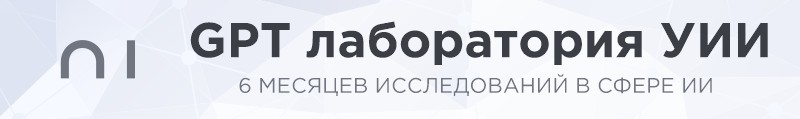